In [1761]:
import numpy as np
import matplotlib.pyplot as plt
#import galpak
#from galpak import DefaultModel, ModelSersic
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import random
import scipy.odr as odr


from ultranest import ReactiveNestedSampler
import os
import scipy as sc
import pandas as pd
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import constants as const
from astropy import units as u
from astropy.coordinates import SkyCoord, Distance
from astropy.coordinates import Angle, Distance
from astropy.cosmology import Planck15
from astropy.cosmology import WMAP9 as cosmo
from scipy.stats import binned_statistic
import matplotlib.backends.backend_pdf
from scipy import integrate
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec




import mpdaf
from mpdaf.obj import Cube
from mpdaf.drs import PixTable
#from galpak import MoffatPointSpreadFunction, GaussianLineSpreadFunction
from mpdaf.sdetect import Source

from astropy.io import fits 

import pymultinest

# the home made tool package:
import galpak_tools as gt

#import logistic
#import run_covering_2

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1762]:
R = pd.read_csv("results_decomp_4.csv")

bad_runs_ids = [11083, 12121, 23086, 26092, 28102, 30070, 30093]
#bad_runs_ids = [11083, 12121, 23086, 23120, 26056, 26092, 29002, 29084, 28102, 30070, 30093, 31005]
low_cstr = [14120]
no_morpho = [11083, 12103, 20077, 21117, 23086, 24038, 25087, 27094, 29073, 30070]

no_morpho_isol = [11083, 12103, 20077, 23086, 24038, 27094, 30070]

to_remove = [11083, 24052]

R['sed_logMass'] = R['sed_logMass'].fillna(6)
R.loc[R['sed_logMass'] < 1, 'sed_logMass'] = 6 # because we have some galaxy with sed_logMass = -21
R["logSFR"] = np.log10(R["SFR_gilbank"])
R["logSSFR"] = np.log10(R["SFR_gilbank"]/(10**R["sed_logMass"]))
R['logSFR'] = R['logSFR'].fillna(-2)
R['logSSFR'] = R['logSSFR'].fillna(-11)
R["sed_logMass_2sig_err"] = (R["sed_logMass_u95"] - R["sed_logMass_l95"])/2
R["sed_logMass_1sig_err"] = (R["sed_logMass_u95"] - R["sed_logMass_l95"])/4

R["orientation"] = 1 #an alternative method is to use a flag. 0 = accretion, 1 = middle, 2 = wind.
R.loc[R["alpha"] < 30, "orientation"] = 0
R.loc[R["alpha"] > 60, "orientation"] = 2

fov_size = 60 #arcsec
arcsec_per_pixel = 0.2 #arcesc per pixel
kpc_per_arcsec = cosmo.kpc_proper_per_arcmin(np.array(R["Z"])).value/60
kpc_per_pixel = kpc_per_arcsec*arcsec_per_pixel
R["rs_pixel"] = R["rs_kpc"]/kpc_per_pixel
R["rs_pixel_err"] = R["rs_kpc_err"]/kpc_per_pixel
R["radius_kpc_err"] = R["radius_err"]*kpc_per_pixel

In [1763]:
R = gt.isolated_auto_modif3(R, Mh = 10**(11.7), b_sep = 0, dv = 0.5e6, group_threshold = 4, logm_sat = 0)
R = gt.get_closest(R, dv = 0.5e6, group_threshold = 4, logm_sat = 0, ZCONF_lim = 0)

In [1764]:
R["log_NMgII"] = 20.053 + np.log10(R["REW_2796"]/2796) - 3.236
R["log_NMgII_limit"] = 20.053 + np.log10(R["detection_limit_p75"]/2796) - 3.236

/home/cherrey/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [1765]:
f100 = R["B_KPC"] <= 100
f150 = R["B_KPC"] <= 150
f200 = R["B_KPC"] <= 200
fsnr3 = R["snr_eff"]>=3
fsnr5 = R["snr_from_src"]>=5
fsnr8 = R["snr_from_src"]>=8
fincl30 = R["inclination"] >= 30 
fabs = R["bool_absorption"] == 1
fqso = R["is_QSO"] == 0
fclosest = R["is_closest"] == 1
fzlow = R["Z"] > 0.4
fzlow_08 = R["Z"] > 0.8
fzhigh = R["Z"] < 1.5
fzhigh_1 = R["Z"] < 1
fzhigh_09 = R["Z"] < 0.9
fzhigh_08 = R["Z"] < 0.8
fzconf_0 = R["ZCONF"] > 0
fzconf_1 = R["ZCONF"] > 1
fstar = R["is_star"] == 0
flowa = R["alpha"] <= 30
fmida = (R["alpha"] >= 30) & (R["alpha"] <= 60)
fhigha = R["alpha"] >= 60
fisol = R["isolated_auto"] == 1
fm9 = R["sed_logMass"] >= 9
fconv = R["run_convergence_global"] >= 0.99
fbad = R["ID"].isin(bad_runs_ids)
fno_morpho = R["ID"].isin(no_morpho)
fnomass = R["sed_logMass"].isna()
f_SFR1 = np.log10(R["SFR_gilbank"]) >= 0
f_SFR01 = np.log10(R["SFR_gilbank"]) >= 0
fbehind = R["Z"]<(R["zqso_sdss"] - 1e6*(R["zqso_sdss"]+1)/const.c.value)
fnomass = R["sed_logMass"] == 6
frot = (R["v22"]+0.01)/R["velocity_dispersion_2Rd"] > 1
frot2 = (R["v22"]+0.01)/R["velocity_dispersion_2Rd"] > 2
fremove = R["ID"].isin(to_remove)
finner_slope = R["rs_pixel"] > 3
fradius = R["radius"]> 1.0
fgamma_err = R["gamma_err"] < 0.2

In [1766]:
Rforeground = R[fqso & fstar & fbehind & fzconf_0]
Rforeground_zconf1 = R[fqso & fstar & fbehind & fzconf_1]
Rforeground_mass = R[fqso & fstar & fbehind & fzconf_0 & ~fnomass]
Rforeground_zconf1_mass = R[fqso & fstar & fbehind & fzconf_1 & ~fnomass]
Rforeground_nomass = R[fqso & fstar & fbehind & fzconf_0 & fnomass]
Rforeground_zconf1_nomass = R[fqso & fstar & fbehind & fzconf_0 & fnomass]

R_04_15 = R[fzlow & fzhigh & fqso & fstar & fbehind & fzconf_0 & ~fnomass]
R_04_15_zconf1 = R[fzlow & fzhigh & fqso & fstar & fbehind & fzconf_1 & ~fnomass]
R_08_15_zconf1 = R[fzlow_08 & fzhigh & fqso & fstar & fbehind & fzconf_1 & ~fnomass]

R_04_1 = R[fzlow & fzhigh_1 & fqso & fstar & fbehind & fzconf_0 & ~fnomass]
R_04_1_zconf1 = R[fzlow & fzhigh_1 & fqso & fstar & fbehind & fzconf_1 & ~fnomass]
R_04_09 = R[fzlow & fzhigh_09 & fqso & fstar & fbehind & fzconf_0 & ~fnomass]
R_04_09_zconf1 = R[fzlow & fzhigh_09 & fqso & fstar & fbehind & fzconf_1 & ~fnomass]
R_04_08 = R[fzlow & fzhigh_08 & fqso & fstar & fbehind & fzconf_0 & ~fnomass]
R_04_08_zconf1 = R[fzlow & fzhigh_08 & fqso & fstar & fbehind & fzconf_1 & ~fnomass]
R_04_08_zconf1 = R[fzlow & fzhigh_08 & fqso & fstar & fbehind & fzconf_1 & ~fnomass]

R_9 = R[fqso & fstar & f100 & fzlow & fzhigh & fzconf_1 & fbehind & fm9]
R100 = R[fqso & fstar & fzlow & fzhigh & fbehind & f100] 
R150 = R[fqso & fstar & fzlow & fzhigh & fbehind & f150]
R150_snr3 = R[fqso & fstar & fzlow & fzhigh & f150 & fconv & fsnr3 & ~fbad & fzconf_1]
R200 = R[fqso & fstar & fzlow & fzhigh & fbehind & f200]

isol = R[fqso & fstar & fisol & fbehind & ~fremove] #isolated galaxies
isol_abs = R[fqso & fstar & fisol & fabs & fbehind & ~fremove]
isol_noabs = R[fqso & fstar & fisol & ~fabs & fbehind & ~fremove]
isol_zconf = R[fqso & fstar & fisol & fzconf_1 & fbehind & ~fremove]
isol_zconf_abs = R[fqso & fstar & fisol & fzconf_1 & fabs & fbehind & ~fremove]
isol_zconf_noabs = R[fqso & fstar & fisol & fzconf_1 & ~fabs & fbehind & ~fremove]
isol_zselec = R[fqso & fstar & fisol & fzlow & fzhigh & fbehind & ~fremove] # isolated in z= 0.4 - 1.5
isol_zselec_mass = R[fqso & fstar & fisol & fzconf_1 & fzlow & fzhigh & fbehind & ~fnomass & ~fremove] 
isol_zselec_nomass = R[fqso & fstar & fisol & fzconf_1 & fzlow & fzhigh & fbehind & fnomass & ~fremove]
isol_zconf_1 = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fbehind & ~fremove] # isolated with z = 0.4-1.5 and zconf = 1
isol_9 = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fremove] # isolated with z = 0.4-1.5 and zconf = 1 and M* above 1e9
isol_9_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fabs & fbehind & ~fremove] # isolated with z = 0.4-1.5 and zconf = 1 and M* above 1e9
isol_9_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & ~fabs & fbehind & ~fremove] # isolated with z = 0.4-1.5 and zconf = 1 and M* above 1e9
isol_lowM = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & ~fm9 & fbehind & ~fremove] # isolated with z = 0.4-1.5 and zconf = 1 and M* below 1e9
isol_lowM_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & ~fm9 & fabs & fbehind & ~fremove]
isol_lowM_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & ~fm9 & ~fabs & fbehind & ~fremove]
isol_9_convergence = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fbehind & ~fremove] # idem with good convergence
isol_9_noconvergence = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & ~fconv & fbehind & ~fremove] # idem with good convergence
isol_lowM_convergence = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & ~fm9 & fconv & fbehind & ~fremove]
isol_snr3 = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fbehind & ~fremove] # idem with good snr
isol_snr3_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fbehind & fabs & ~fremove] # idem with good snr
isol_snr3_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fbehind & ~fabs & ~fremove] # idem with good snr


isol_lowM_snr3 = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & ~fm9 & fconv & fsnr3 & fbehind]
isol_good_runs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & ~fbad & fbehind] # good runs
isol_notgood_runs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fbad & fbehind]
isol_snr3_good_runs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & ~fbad & fbehind] # good runs
isol_snr3_notgood_runs = R[fqso & fstar& fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fbad & fbehind]
isol_snr3_good_runs_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & ~fbad & fabs & fbehind] # good runs
isol_snr3_good_runs_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & ~fbad & ~fabs & fbehind] # good runs
isol_snr3_good_runs_rot = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & ~fbad & fbehind & frot] # good runs
isol_snr3_good_runs_rot_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & ~fbad & fbehind & frot & fabs] # good runs
isol_snr3_good_runs_rot_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & ~fbad & fbehind & frot & ~fabs] # good runs

isol_incl_good_runs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & frot] # good runs
isol_incl_good_runs_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fabs & fbehind & frot] # good runs
isol_incl_good_runs_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & ~fabs & fbehind & frot] # good runs


isol_high_alpha = R[fqso & fstar & fincl30 & fhigha & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & frot & ~fremove]
isol_high_alpha_abs = R[fqso & fstar & fincl30 & fhigha & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & fabs & frot & ~fremove]
isol_high_alpha_noabs = R[fqso & fstar & fincl30 & fhigha & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & ~fabs & frot & ~fremove]
isol_mid_alpha = R[fqso & fstar & fincl30 & fmida & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & frot & ~fremove]
isol_mid_alpha_abs = R[fqso & fstar & fincl30 & fmida & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & fabs & frot & ~fremove]
isol_mid_alpha_noabs = R[fqso & fstar & fincl30 & fmida & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & ~fabs & frot & ~fremove]
isol_low_alpha = R[fqso & fstar & fincl30 & flowa & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & frot & ~fremove]
isol_low_alpha_abs = R[fqso & fstar & fincl30 & flowa & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & fabs & frot & ~fremove]
isol_low_alpha_noabs = R[fqso & fstar & fincl30 & flowa & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & ~fabs & frot & ~fremove]


#---- from visual inspection----
isol_behroozi = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho]
isol_visu = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & ~fremove]
isol_visu_nok = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & (fno_morpho | fremove)]
isol_visu_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fabs & ~fremove]
isol_visu_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & ~fabs & ~fremove]
isol_visu_rot = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & frot & ~fremove]
isol_visu_rot_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & frot & fabs & ~fremove]
isol_visu_rot_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & frot & ~fabs & ~fremove]
isol_incl_visu_rot = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & ~fremove]
isol_incl_visu_rot_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & fabs & frot & ~fremove]
isol_incl_visu_rot_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & ~fabs & frot & ~fremove]
inner_slope = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & frot & ~fremove & finner_slope]
inner_slope_2 = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & frot2 & ~fremove & fradius & fsnr8]
inner_slope_3 = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & frot2 & ~fremove & fradius & fsnr5]
inner_slope_4 = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & frot2 & ~fremove]
inner_slope_5 = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & frot2 & ~fremove & fgamma_err]


isol_visu_rot_incl = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & ~fremove]
isol_visu_low_incl = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & ~fincl30 & frot & ~fremove]
isol_visu_high_alpha = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & fhigha & ~fremove]
isol_visu_high_alpha_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & fhigha & ~fremove & fabs]
isol_visu_high_alpha_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & fhigha & ~fremove & ~fabs]
isol_visu_low_alpha = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & flowa & ~fremove]
isol_visu_low_alpha_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & flowa & ~fremove & fabs]
isol_visu_low_alpha_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & flowa & ~fremove & ~fabs]


#----


closest = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & ~fremove]
closest_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fabs & ~fremove]
closest_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & ~fabs & ~fremove]
closest_9 = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fm9 & ~fremove]
closest_9_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fabs & fm9 & ~fremove]
closest_9_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & ~fabs & fm9 & ~fremove]
closest_9_snr3 = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fm9 & fsnr3 & ~fremove]
closest_9_snr3_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fm9 & fsnr3 & fabs & ~fremove]
closest_9_snr3_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fm9 & fsnr3 & ~fabs & ~fremove]
closest_9_snr3_good_runs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fm9 & fsnr3 & ~fbad & ~fremove & ~fremove]
closest_9_snr3_good_runs_rot = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & ~fbad & fbehind & frot & ~fremove] # good runs
closest_9_snr3_good_runs_rot_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & ~fbad & fbehind & frot & fabs & ~fremove] # good runs
closest_9_snr3_good_runs_rot_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & ~fbad & fbehind & frot & ~fabs & ~fremove] # good runs
closest_9_snr3_good_runs_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fabs & fm9 & fsnr3 & ~fbad & ~fremove]
closest_9_snr3_good_runs_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & ~fabs & fm9 & fsnr3 & ~fbad & ~fremove]



closest_incl = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fm9 & fsnr3 & ~fbad & fincl30 & ~fremove]
closest_incl_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fabs & fm9 & fsnr3 & ~fbad & fincl30 & ~fremove]
closest_incl_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & ~fabs & fm9 & fsnr3 & ~fbad & fincl30 & ~fremove]

closest_high_alpha = R[fqso & fstar & fincl30 & fhigha & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & ~fremove]
closest_high_alpha_abs = R[fqso & fstar & fincl30 & fhigha & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & fabs & ~fremove]
closest_high_alpha_noabs = R[fqso & fstar & fincl30 & fhigha & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & ~fabs & ~fremove]
closest_mid_alpha = R[fqso & fstar & fincl30 & fmida & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & ~fremove]
closest_mid_alpha_abs = R[fqso & fstar & fincl30 & fmida & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & fabs & ~fremove]
closest_mid_alpha_noabs = R[fqso & fstar & fincl30 & fmida & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & ~fabs & ~fremove]
closest_low_alpha = R[fqso & fstar & fincl30 & flowa & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & ~fremove]
closest_low_alpha_abs = R[fqso & fstar & fincl30 & flowa & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & fabs & ~fremove]
closest_low_alpha_noabs = R[fqso & fstar & fincl30 & flowa & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & ~fabs & ~fremove]
closest_inner_slope_2 = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & frot2 & ~fremove & fradius & fsnr8]



print("Number of foreground galaxies: ", len(Rforeground))
print("Number of galaxies with logM > 9, good z, QSO behind, good zconf = ", len(R_9))
print("Number of isolated = ", len(isol))
print("Number of isolated with abs = ", len(isol_abs))
print("Number of distinct absorptions associated with isolated  = ", len(isol_abs["abs_id"].unique()))
print("Number of isolated with zconf >= 2 ", len(isol_zconf))
print("Number of isolated at 0.4 < z < 1.5 = ", len(isol_zselec))
print("Number of isolated at 0.4 < z < 1.5 and zconf >= 2 ", len(isol_zconf_1))
print("and with mass = ", len(isol_zselec_mass))
print("or without mass = ", len(isol_zselec_nomass))
print("with the previous filters on isolation, z, zconf and QSO behind:")
print("Number of isolated with logM > 9 = ", len(isol_9))
print("Number of isolated with logM > 9 and multinest run = ", len(isol_9[isol_9["run_name"] == "run_OII_multinest"]))
print("Number of isolated with logM > 9 with abs = ", len(isol_9_abs))
print("Number of isolated with logM > 9 without abs = ", len(isol_9_noabs))
print("Number of isolated with logM > 9 and good convergence = ", len(isol_9_convergence))
print("Number of isolated with logM > 9 and snr_eff > 3  = ", len(isol_snr3))
print("Number of isolated with logM > 9 and good galpak runs  = ", len(isol_good_runs))
print("Number of isolated with logM > 9 and good runs and snr_eff > 3  = ", len(isol_snr3_good_runs))
print("Number of isolated with logM > 9 and good galpak runs, rot dominated  = ", len(isol_snr3_good_runs_rot))
print("Number of isolated with logM > 9 and good galpak runs, rot dominated with abs = ", len(isol_snr3_good_runs_rot_abs))
print("Number of isolated with logM > 9 and good galpak runs, rot dominated without abs= ", len(isol_snr3_good_runs_rot_noabs))
print("Number of isolated with logM > 9 and good galpak runs and incl>30 = ", len(isol_incl_good_runs))
print("Number of closest galaxies at 0.4 < z < 1.5 and zconf >= 2 ", len(closest))
print("Number of closest galaxies at 0.4 < z < 1.5 and zconf >= 2 and logM> 9", len(closest_9))
print("Number of closest galaxies at 0.4 < z < 1.5 and zconf >= 2 and logM> 9 and abs", len(closest_9_abs))
print("Number of isolated rotation dominated galaxies: ", len(isol_visu_rot))
print("Number of isolated rotation dominated galaxies with rs>3 pixel: ", len(inner_slope))
print("Number of isolated rotation dominated galaxies (>2), snr>8,radius>1: ", len(inner_slope_2))
print("Number of isolated rotation dominated galaxies (>2), snr>5,radius>1: ", len(inner_slope_3))
print("Number of isolated rotation dominated galaxies (>2): ", len(inner_slope_4))
print("Number of isolated rotation dominated galaxies (>2), gamma_err<0.2: ", len(inner_slope_5))


print("")
print("** FOR THE PAPER: **")
print("** Volume limited sample (A)**")
print("Nb of galaxies in 0.4 - 1.5:", len(R[fzlow & fzhigh & fqso & fstar & fzconf_0]))
print("Nb of galaxies in 0.4 - 1.5 and zconf >= 2 :", len(R[fzlow & fzhigh & fqso & fstar & fzconf_1]))
print("Nb of galaxies in 0.4 - 1.5 and zconf >= 2 log(M) > 9:", len(R[fzlow & fzhigh & fqso & fstar & fzconf_1 & fm9]))
print("Nb of galaxies in 0.4 - 1.5 and zconf >= 2 log(M) > 9 and foreground:", len(R[fzlow & fzhigh & fqso & fstar & fzconf_1 & fm9 & fbehind]))
print("** Isolated galaxies **")
print(" (A) and isolated:", len(R[fzlow & fzhigh & fqso & fstar & fzconf_1 & fm9 & fbehind & fisol]))
print("** closest galaxies **")
print(" (A) and closest:", len(R[fzlow & fzhigh & fqso & fstar & fzconf_1 & fm9 & fbehind & fclosest]))

Number of foreground galaxies:  1210
Number of galaxies with logM > 9, good z, QSO behind, good zconf =  127
Number of isolated =  257
Number of isolated with abs =  43
Number of distinct absorptions associated with isolated  =  43
Number of isolated with zconf >= 2  205
Number of isolated at 0.4 < z < 1.5 =  176
Number of isolated at 0.4 < z < 1.5 and zconf >= 2  144
and with mass =  116
or without mass =  28
with the previous filters on isolation, z, zconf and QSO behind:
Number of isolated with logM > 9 =  72
Number of isolated with logM > 9 and multinest run =  0
Number of isolated with logM > 9 with abs =  33
Number of isolated with logM > 9 without abs =  39
Number of isolated with logM > 9 and good convergence =  72
Number of isolated with logM > 9 and snr_eff > 3  =  51
Number of isolated with logM > 9 and good galpak runs  =  71
Number of isolated with logM > 9 and good runs and snr_eff > 3  =  50
Number of isolated with logM > 9 and good galpak runs, rot dominated  =  43
Numb

In [1767]:
len(isol_9)

72

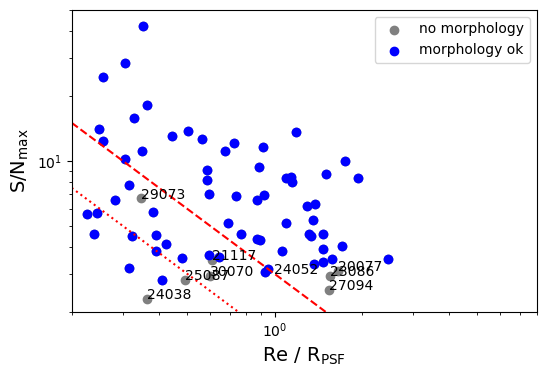

In [189]:
xx = np.linspace(0.2, 1.5, 100)
yy = 3/xx
yy1 = 1.5/xx
muse_sampling = 0.2
plt.figure(dpi = 100)
plt.scatter(isol_9["radius"]*muse_sampling/isol_9["psf_fwhm"], isol_9["snr_max"], c = "gray", \
            label = "no morphology")
#plt.scatter(isol_snr3["radius"]*muse_sampling/isol_snr3["psf_fwhm"], isol_snr3["snr_max"], c = "blue", \
#            label = "isolated S/N$_{\mathrm{eff}} > 3$")
plt.scatter(isol_visu["radius"]*muse_sampling/isol_visu["psf_fwhm"], isol_visu["snr_max"], c = "blue", \
            label = "morphology ok")
#plt.scatter(isol_snr3_good_runs["radius"]/isol_snr3_good_runs["psf_fwhm"], isol_snr3_good_runs["snr_max"], c = "blue")
#plt.scatter(isol_notgood_runs["radius"]*muse_sampling/isol_notgood_runs["psf_fwhm"], isol_notgood_runs["snr_max"], \
#            facecolors = "none", edgecolors = "red", s = 100, label = "bad runs")
plt.plot(xx, yy, c = "red", linestyle = "--")
#label = "S/N$_{\mathrm{eff}} = 3$"
plt.plot(xx, yy1, c = "red", linestyle = "dotted")
#label = "S/N$_{\mathrm{eff}} = 1.5$"
plt.xlabel("Re / R$_{\mathrm{PSF}}$", size = 14)
plt.ylabel("S/N$_{\mathrm{max}}$", size = 14)
#plt.axvline(3, color = "red", linestyle = "--")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.xlim((0.2,8))
plt.ylim((2,50))


X = np.array(isol_visu_nok["radius"]*muse_sampling/isol_visu_nok["psf_fwhm"])
Y = np.array(isol_visu_nok["snr_max"])
txt = np.array(isol_visu_nok["ID"])

for i in range(len(isol_visu_nok)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))

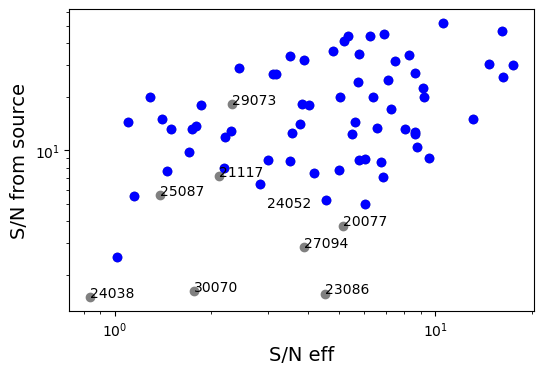

In [192]:
xx = np.linspace(0.2, 1.5, 100)
yy = 3/xx
yy1 = 1.5/xx
muse_sampling = 0.2
plt.figure(dpi = 100)
plt.scatter(isol_9["snr_eff"], isol_9["snr_from_src"], c = "gray",)
#plt.scatter(isol_snr3["snr_eff"], isol_snr3["snr_from_src"], c = "blue", \
#            label = "isolated S/N$_{\mathrm{eff}} > 3$")
plt.scatter(isol_visu["snr_eff"], isol_visu["snr_from_src"], c = "blue", \
            label = "visually ok for morpho")
#plt.scatter(isol_snr3_good_runs["radius"]/isol_snr3_good_runs["psf_fwhm"], isol_snr3_good_runs["snr_max"], c = "blue")
#plt.scatter(isol_notgood_runs["snr_eff"], isol_notgood_runs["snr_from_src"], \
#            facecolors = "none", edgecolors = "red", s = 100, label = "bad runs")
#plt.plot(xx, yy, c = "red", linestyle = "--", label = "S/N$_{\mathrm{eff}} = 3$")
#plt.plot(xx, yy1, c = "pink", linestyle = "--", label = "S/N$_{\mathrm{eff}} = 1.5$")
plt.xlabel("S/N eff", size = 14)
plt.ylabel("S/N from source", size = 14)
#plt.axvline(3, color = "red", linestyle = "--")
plt.xscale("log")
plt.yscale("log")
plt.axhline()
#plt.legend()
#plt.xlim((0.2,8))
#plt.ylim((2,50))


X = np.array(isol_visu_nok["snr_eff"])
Y = np.array(isol_visu_nok["snr_from_src"])
txt = np.array(isol_visu_nok["ID"])

for i in range(len(isol_visu_nok)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    

## Comparison logM estimations

Text(0, 0.5, 'sed logM*')

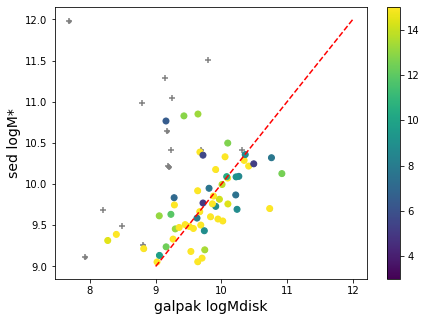

In [193]:
plt.figure(figsize = (7, 5))
plt.scatter(isol_9["log_Mdisk"], isol_9["sed_logMass"], c = "gray", marker = "+")
plt.scatter(isol_visu["log_Mdisk"], isol_visu["sed_logMass"], c = "grey", marker = ".")
plt.scatter(isol_visu_rot["log_Mdisk"], isol_visu_rot["sed_logMass"], \
            #c = (isol_visu_rot["v22"]+0.01)/isol_visu_rot["velocity_dispersion_2Rd"]),\
            c = isol_visu_rot["snr_from_src"], vmin = 3, vmax = 15)
plt.colorbar()
plt.plot([9,12], [9,12], c = "r", linestyle = "--")
plt.xlabel("galpak logMdisk", size = 14)
plt.ylabel("sed logM*", size = 14)

## Selection from S/N

To study the cusp/core problem, we need sources with sufficient S/N and also sufficiently extended compared to the spatial resolution.

Text(0, 0.5, 'galpak rs [pixel]')

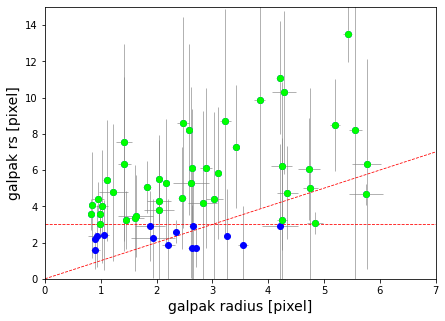

In [194]:
plt.figure(figsize = (7,5))
plt.errorbar(np.array(isol_visu_rot["radius"]), np.array(isol_visu_rot["rs_pixel"]),\
            yerr = np.array(isol_visu_rot["rs_pixel_err"]),\
            xerr = np.array(isol_visu_rot["radius_err"]), \
             linestyle = "none", color = "gray", linewidth = 0.6);
plt.scatter(np.array(isol_visu_rot["radius"]), np.array(isol_visu_rot["rs_pixel"]), \
            c = "blue", zorder = 3);
plt.scatter(np.array(inner_slope["radius"]), np.array(inner_slope["rs_pixel"]), \
            c = "lime", zorder = 3, label = "Ok for inner slope");
plt.xlim((0,7))
plt.ylim((0,15))
plt.plot([0,15], [0,15], c = "r", linestyle = "--", linewidth = 0.8)
plt.axhline(3, c = "r", linestyle = "--", linewidth = 0.8)
#plt.plot([1,2,4,10], [2, 4, 8, 20], c = "orange", linestyle = "--", linewidth = 0.8)
plt.xlabel("galpak radius [pixel]", size = 14)
plt.ylabel("galpak rs [pixel]", size = 14)

Text(0, 0.5, 'galpak rs [pixel]')

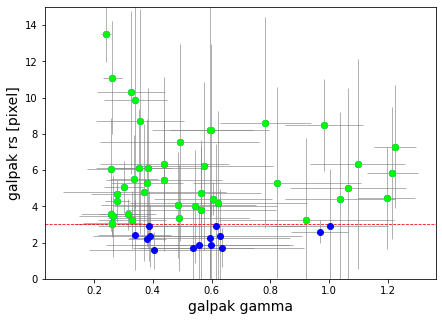

In [195]:
plt.figure(figsize = (7,5))
plt.errorbar(np.array(isol_visu_rot["gamma"]), np.array(isol_visu_rot["rs_pixel"]),\
            yerr = np.array(isol_visu_rot["rs_pixel_err"]),\
            xerr = np.array(isol_visu_rot["gamma_err"]), \
             linestyle = "none", color = "gray", linewidth = 0.6);
plt.scatter(np.array(isol_visu_rot["gamma"]), np.array(isol_visu_rot["rs_pixel"]), \
            c = "blue", zorder = 3);
plt.scatter(np.array(inner_slope["gamma"]), np.array(inner_slope["rs_pixel"]), \
            c = "lime", zorder = 3, label = "Ok for inner slope");
#plt.xlim((0,7))
plt.ylim((0,15))
#plt.plot([0,15], [0,15], c = "r", linestyle = "--", linewidth = 0.8)
plt.axhline(3, c = "r", linestyle = "--", linewidth = 0.8)
#plt.plot([1,2,4,10], [2, 4, 8, 20], c = "orange", linestyle = "--", linewidth = 0.8)
plt.xlabel("galpak gamma", size = 14)
plt.ylabel("galpak rs [pixel]", size = 14)

In [660]:
inner_slope_4["run_name"]

74           run_OII_decomp
94           run_OII_decomp
230          run_OII_decomp
294          run_OII_decomp
314          run_OII_decomp
354          run_OII_decomp
355          run_OII_decomp
436          run_OII_decomp
439          run_OII_decomp
474          run_OII_decomp
509          run_OII_decomp
577          run_OII_decomp
583          run_OII_decomp
591          run_OII_decomp
605          run_OII_decomp
646          run_OII_decomp
673          run_OII_decomp
687          run_OII_decomp
709     run_OII_decomp_logX
742          run_OII_decomp
755          run_OII_decomp
788          run_OII_decomp
834          run_OII_decomp
865          run_OII_decomp
910          run_OII_decomp
922          run_OII_decomp
924          run_OII_decomp
1023         run_OII_decomp
1027    run_OII_decomp_logX
1042         run_OII_decomp
1110         run_OII_decomp
1195    run_OII_decomp_logX
1204    run_OII_decomp_logX
1222         run_OII_decomp
1224         run_OII_decomp
1397         run_OII

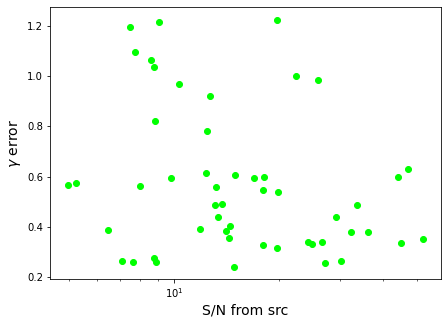

In [659]:
plt.figure(figsize = (7,5))
plt.scatter(inner_slope_4["snr_from_src"], inner_slope_4["gamma"], \
            c = "lime", zorder = 3);
plt.xlabel("S/N from src", size = 14)
plt.ylabel("$\gamma$ error", size = 14)
plt.xscale("log")

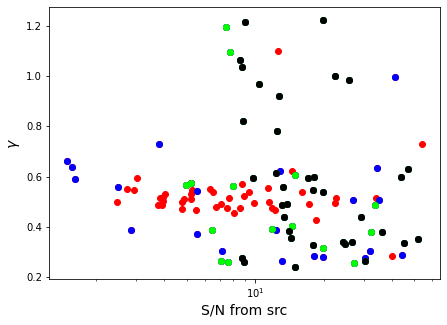

In [661]:
plt.figure(figsize = (7,5))
plt.scatter(isol["snr_from_src"], isol["gamma"], \
            c = "red", zorder = 3);
plt.scatter(isol_9["snr_from_src"], isol_9["gamma"], \
            c = "blue", zorder = 3);
plt.scatter(inner_slope_4["snr_from_src"], inner_slope_4["gamma"], \
            c = "lime", zorder = 3);
plt.scatter(inner_slope_2["snr_from_src"], inner_slope_2["gamma"], \
            c = "black", zorder = 3);
plt.xlabel("S/N from src", size = 14)
plt.ylabel("$\gamma$", size = 14)
plt.xscale("log")

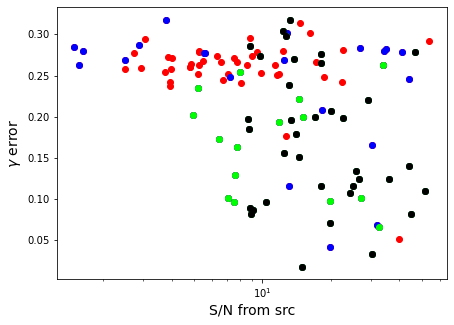

In [664]:
plt.figure(figsize = (7,5))
plt.scatter(isol["snr_from_src"], isol["gamma_err"], \
            c = "red", zorder = 3);
plt.scatter(isol_9["snr_from_src"], isol_9["gamma_err"], \
            c = "blue", zorder = 3);
plt.scatter(inner_slope_4["snr_from_src"], inner_slope_4["gamma_err"], \
            c = "lime", zorder = 3);
plt.scatter(inner_slope_2["snr_from_src"], inner_slope_2["gamma_err"], \
            c = "black", zorder = 3);
plt.xlabel("S/N from src", size = 14)
plt.ylabel("$\gamma$ error", size = 14)
plt.xscale("log")

Text(0, 0.5, '$\\gamma$ error')

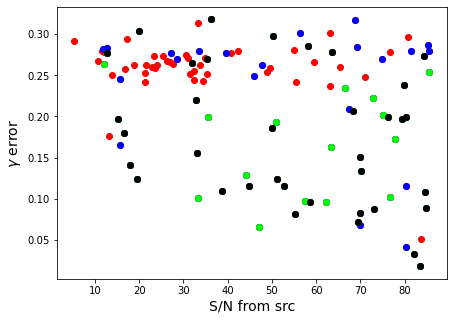

In [666]:
plt.figure(figsize = (7,5))
plt.scatter(isol["inclination"], isol["gamma_err"], \
            c = "red", zorder = 3);
plt.scatter(isol_9["inclination"], isol_9["gamma_err"], \
            c = "blue", zorder = 3);
plt.scatter(inner_slope_4["inclination"], inner_slope_4["gamma_err"], \
            c = "lime", zorder = 3);
plt.scatter(inner_slope_2["inclination"], inner_slope_2["gamma_err"], \
            c = "black", zorder = 3);
plt.xlabel("S/N from src", size = 14)
plt.ylabel("$\gamma$ error", size = 14)
#plt.xscale("log")

Text(0, 0.5, '$\\gamma$ error')

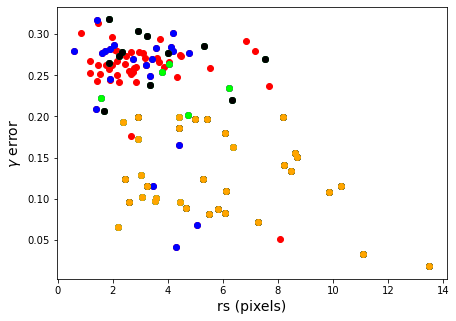

In [672]:
plt.figure(figsize = (7,5))
plt.scatter(isol["rs_pixel"], isol["gamma_err"], \
            c = "red", zorder = 3);
plt.scatter(isol_9["rs_pixel"], isol_9["gamma_err"], \
            c = "blue", zorder = 3);
plt.scatter(inner_slope_4["rs_pixel"], inner_slope_4["gamma_err"], \
            c = "lime", zorder = 3);
plt.scatter(inner_slope_2["rs_pixel"], inner_slope_2["gamma_err"], \
            c = "black", zorder = 3);
plt.scatter(inner_slope_5["rs_pixel"], inner_slope_5["gamma_err"], \
            c = "orange", zorder = 3);
plt.xlabel("rs (pixels)", size = 14)
plt.ylabel("$\gamma$ error", size = 14)
#plt.xscale("log")

(0.0, 17.0)

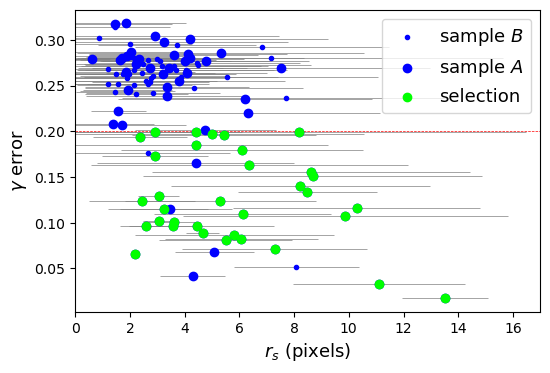

In [733]:
plt.figure(figsize = (6,4), dpi = 100)
plt.errorbar(np.array(isol["rs_pixel"]), np.array(isol["gamma_err"]), \
            xerr = np.array(isol["rs_pixel_err"]), linestyle = "none", color = "gray", linewidth = 0.5,\
            zorder = 0)
plt.scatter(isol["rs_pixel"], isol["gamma_err"], \
            c = "blue", marker = ".", zorder = 1, label = "sample $B$");
plt.scatter(isol_9["rs_pixel"], isol_9["gamma_err"], \
            c = "blue", zorder = 2, label = "sample $A$");
plt.scatter(inner_slope_5["rs_pixel"], inner_slope_5["gamma_err"], \
            c = "lime", zorder = 3, label = "selection");
plt.axhline(0.2, color = "r", linestyle = "--", linewidth = 0.5, zorder = 0)
plt.xlabel("$r_s$ (pixels)", size = 13)
plt.ylabel("$\gamma$ error", size = 13)
plt.legend(fontsize = 13)
plt.xlim((0, 17))
#plt.xscale("log")

In [734]:
len(inner_slope_5)

34

In [790]:
for c in inner_slope_5.columns:
    print(c)

Unnamed: 0
ID
field_id
DATASET
FROM
Z
ZCONF
is_QSO
is_star
DR1_id
DR1_nbmatch
RA
DEC
B_KPC
B_ARCSEC
REFSPEC
REFCENTER
FELINE_ID
WHITE_ID
WHITE_ID.1
MANUAL_ID
fel_ID
FEL_score
FEL_sigma
WHITE_ID.2
WHITE_ID.3
wh_SDSS_r
wh_SDSS_i
sp_F775W
sp_SDSS_r
sp_SDSS_i
SDSS_r
SDSS_r_ERR
SDSS_i
SDSS_i_ERR
MAG_F775W
MAG_F775W_ERR
OII3726_FLUX
OII3726_FLUX_ERR
OII3726_EQW
OII3726_FLUX_EQW
OII3729_FLUX
OII3729_FLUX_ERR
OII3729_EQW
OII3729_EQW_ERR
MGII2796_EMI_FLUX
MGII2796_EMI_FLUX_ERR
MGII2796_ABS_EQW
MGII2796_ABS_EQW_ERR
MGII2803_EMI_FLUX
MGII2803_EMI_FLUX_ERR
MGII2803_ABS_EQW
MGII2803_ABS_EQW_ERR
sed_logMass
sed_logMass_l95
sed_logMass_u95
sed_rchisq
sed_ebv
sed_ebv_l95
sed_ebv_u95
sed_age
sed_age_l95
sed_age_u95
sed_metallicity
sed_tau
sed_tau_l95
sed_tau_u95
sed_curr_sfr
sed_curr_sfr_l95
sed_curr_sfr_u95
sed_sfr_100
sed_sfr_100_l95
sed_sfr_100_u95
photoz_zbest
photoz_zbest_l95
photoz_zbest_u95
photoz_rchisq
EXPTIME(s)
PSF_qso
Comments_qso
zqso_sdss
depth_qso
ebv_sfd_qso
ebv_sandf_qso
ebv_planck_qso

In [798]:
inner_slope_5[["DR1_id", "ID", "field_id", "Z", "B_KPC", "REW_2796", "gamma", "DR1_nbmatch"]]

DR1_id     ID    field_id        Z   B_KPC  REW_2796     gamma  \
74       NaN  11097  J0014m0028  0.40815  125.99     0.000  0.437619   
94       NaN  11117  J0014m0028  0.95172   67.91     0.000  0.329581   
230      NaN  12108  J0014p0912  0.60386   65.52     0.000  0.599425   
294      NaN  13063  J0015m0751  0.73143   34.64     1.571  1.096800   
314    b'91'  13088  J0015m0751  0.81654   19.23     2.394  0.605086   
354    b'88'  13128  J0015m0751  0.50687   24.35     1.686  0.595222   
355      NaN  13129  J0015m0751  0.56124   65.59     0.000  0.326404   
439      NaN  14112  J0058p0111  0.81190   71.86     0.000  0.384792   
583    b'12'  16070  J0131p1303  1.01040   26.33     1.315  0.335062   
591      NaN  16079  J0131p1303  0.91361  115.18     0.000  1.196560   
673      NaN  17066  J0134p0051  0.91766   72.12     0.000  0.380920   
709      NaN  17102  J0134p0051  1.04924  111.99     0.000  0.241278   
742    b'19'  18049  J0145p1056  0.54994   21.34     0.540  0.314866   
788      NaN  18097  J0145p1056  0.45100  105.78     0.000  1.225465   
834      NaN  19072  J0800p1849  0.51553  137.78     0.000  0.356821   
865    b'25'  19103  J0800p1849  0.99337   80.22     0.824  0.982795   
910    b'32'  20052  J0838p0257  1.10063   61.71     0.160  0.379985   
922    b'30'  20064  J0838p0257  1.33043   42.21     1.537  0.390915   
1023     NaN  21107  J0937p0656  0.63718  104.48     0.000  0.782549   
1042     NaN  21126  J0937p0656  0.74275   58.64     0.000  0.338806   
1195     NaN  23092  J1107p1021  1.10869  105.21     0.000  0.256982   
1204     NaN  23102  J1107p1021  0.73981   71.71     0.376  0.257836   
1222     NaN  23120  J1107p1021  1.33986   73.38     0.156  0.261208   
1397   b'52'  25095  J1236p0725  0.91200   17.78     2.126  0.967441   
1579     NaN  27102  J1352p0614  0.67106   85.96     0.000  1.063853   
1722  b'158'  29059  J1425p1209  0.86564   63.63     0.850  0.353143   
1779     NaN  30015  J1509p1506  1.45330  102.61     0.000  0.386560   
1802  b'167'  30047  J1509p1506  1.04669   14.55     1.480  1.001815   
1812     NaN  30060  J1509p1506  0.91746  124.27     0.000  0.262632   
1866     NaN  31005  J2137p0012  1.04028   84.85     0.000  0.277133   
1902     NaN  31079  J2137p0012  0.54402   63.18     0.000  0.341005   
1930     NaN  31107  J2137p0012  0.97861  114.46     0.000  1.037119   
1994   b'68'  32055  J2152p0625  1.05287   49.92     0.518  1.214667   
2019     NaN  32081  J2152p0625  0.87357  106.10     0.000  0.262541   

     DR1_nbmatch  
74           NaN  
94           NaN  
230          NaN  
294          NaN  
314         b'1'  
354         b'1'  
355          NaN  
439          NaN  
583         b'1'  
591          NaN  
673          NaN  
709          NaN  
742         b'1'  
788          NaN  
834          NaN  
865         b'1'  
910         b'1'  
922         b'1'  
1023         NaN  
1042         NaN  
1195         NaN  
1204         NaN  
1222         NaN  
1397        b'2'  
1579         NaN  
1722        b'1'  
1779         NaN  
1802        b'1'  
1812         NaN  
1866         NaN  
1902         NaN  
1930         NaN  
1994        b'1'  
2019         NaN

In [801]:
winds = [[13128, 19.6, 200, 30, 10.7, 4.2, 0.42, 1.2],\
                [13063, 20.0, 100, 25, 10.7, 5.3, 0.23, 1.3],\
                [13088, 20.1, 150, 35, 10.8, 9.2, 0.29, 1.5],\
                [16070, 19.6, 79, 40, 9.6, 1.2, 0.43, 0.1],\
                [19103, 19.5, 250, 25, 9.4, 10.1, 2.90, 1.2],\
                [29059, 19.4, 190, 35, 9.5, 7.0, 1.76, 1.7]]
cols = ["ID", "Sc_logNHI", "Sc_Vout", "Sc_theta_max", "Sc_logM", "Sc_Mout", "Sc_Vout_Vesc", "Sc_load_factor"]

winds_Sch_19 = pd.DataFrame(data = winds, columns = cols)

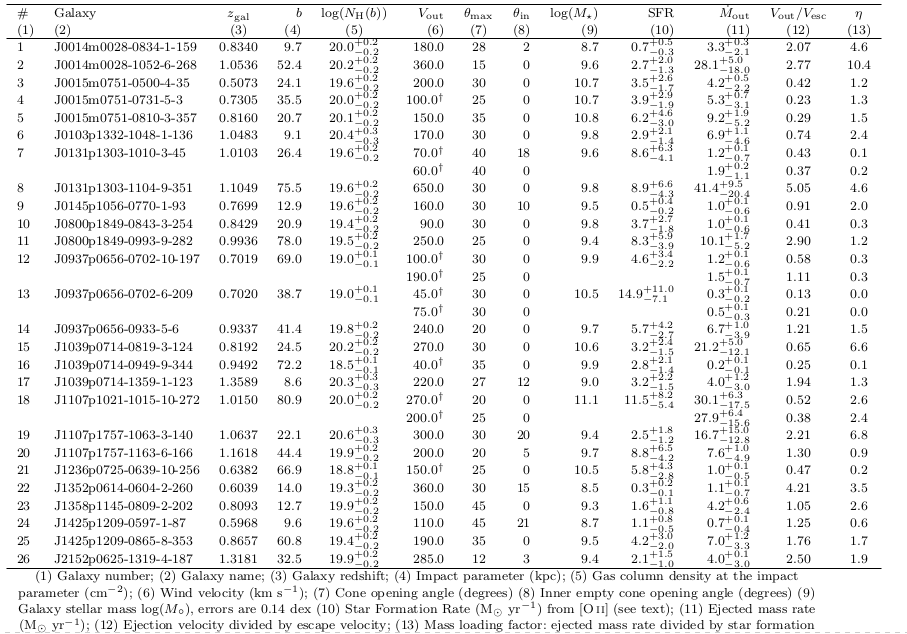

In [802]:
winds_Sch_19

ID  Sc_logNHI  Sc_Vout  Sc_theta_max  Sc_logM  Sc_Mout  Sc_Vout_Vesc  \
0  13128       19.6      200            30     10.7      4.2          0.42   
1  13063       20.0      100            25     10.7      5.3          0.23   
2  13088       20.1      150            35     10.8      9.2          0.29   
3  16070       19.6       79            40      9.6      1.2          0.43   
4  19103       19.5      250            25      9.4     10.1          2.90   
5  29059       19.4      190            35      9.5      7.0          1.76   

   Sc_load_factor  
0             1.2  
1             1.3  
2             1.5  
3             0.1  
4             1.2  
5             1.7

In [803]:
inner_slope_5 = pd.merge(inner_slope_5, winds_Sch_19, how="left", on=["ID"])

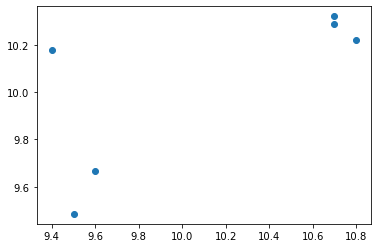

In [804]:
plt.scatter(inner_slope_5["Sc_logM"], inner_slope_5["sed_logMass"])

Text(0, 0.5, 'gamma')

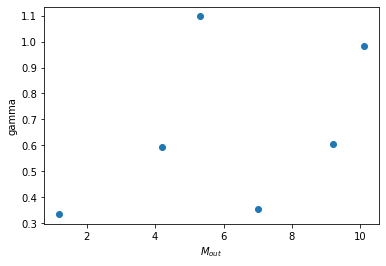

In [806]:
plt.scatter(inner_slope_5["Sc_Mout"], inner_slope_5["gamma"])
plt.xlabel("$M_{out}$")
plt.ylabel("gamma")

Text(0, 0.5, 'gamma')

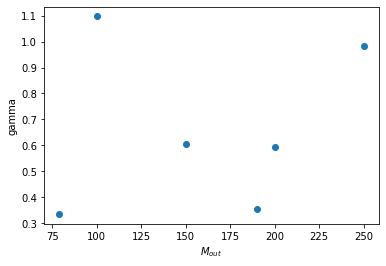

In [808]:
plt.scatter(inner_slope_5["Sc_Vout"], inner_slope_5["gamma"])
plt.xlabel("$M_{out}$")
plt.ylabel("gamma")

Text(0, 0.5, 'gamma')

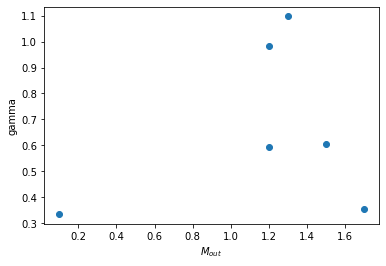

In [809]:
plt.scatter(inner_slope_5["Sc_load_factor"], inner_slope_5["gamma"])
plt.xlabel("$M_{out}$")
plt.ylabel("gamma")

Text(0, 0.5, 'gamma')

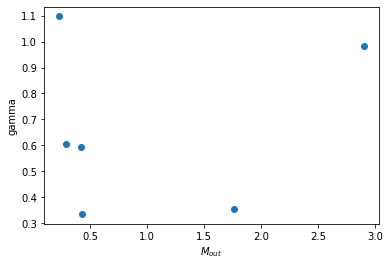

In [810]:
plt.scatter(inner_slope_5["Sc_Vout_Vesc"], inner_slope_5["gamma"])
plt.xlabel("$M_{out}$")
plt.ylabel("gamma")

### Inner slope error as a function of rs

Text(0.5, 0, 'galpak rs [pixel]')

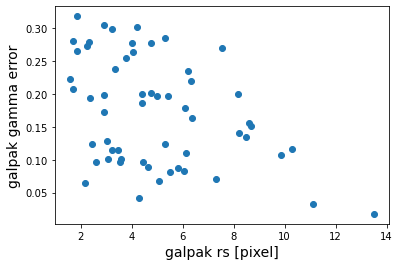

In [197]:
plt.scatter(isol_visu_rot["rs_pixel"], isol_visu_rot["gamma_err"])
plt.ylabel("galpak gamma error", size = 14)
plt.xlabel("galpak rs [pixel]", size = 14)

## b/rs and b/Rvir

Text(0, 0.5, 'REW 2796')

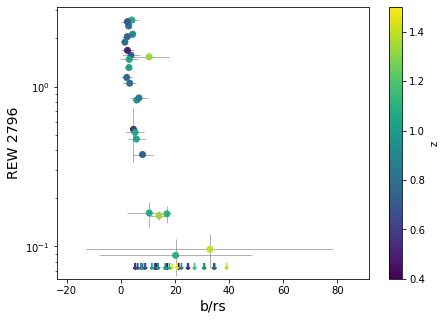

In [491]:
plt.figure(figsize = (7,5))
plt.errorbar(np.array(isol_visu_rot["B_KPC"]/isol_visu_rot["rs_kpc"]), np.array(isol_visu_rot["REW_2796"]),\
            xerr = np.array(isol_visu_rot["rs_kpc_err"]*isol_visu_rot["B_KPC"]/(isol_visu_rot["rs_kpc"]**2)),\
            yerr = np.array(isol_visu_rot["sig_REW_2796"]), \
             linestyle = "none", color = "gray", linewidth = 0.6);
plt.scatter(np.array(isol_visu_rot_abs["B_KPC"]/isol_visu_rot_abs["rs_kpc"]), np.array(isol_visu_rot_abs["REW_2796"]), \
            c = isol_visu_rot_abs["Z"], zorder = 3, vmin = 0.4, vmax = 1.5);
plt.colorbar(label = "z")
#plt.scatter(np.array(inner_slope["B_KPC"]/inner_slope["rs_kpc"]), np.array(inner_slope["REW_2796"]), \
#            c = "lime", zorder = 3);
plt.scatter(np.array(isol_visu_rot_noabs["B_KPC"]/isol_visu_rot_noabs["rs_kpc"]), np.array(isol_visu_rot_noabs["detection_limit_p75"]), \
            c = isol_visu_rot_noabs["Z"], zorder = 3, vmin = 0.4, vmax = 1.5, marker = "$\downarrow$");
plt.xlim((0,25))
#plt.xscale("log")
plt.yscale("log")
plt.xlabel("b/rs", size = 14)
plt.ylabel("REW 2796", size= 14)

In [200]:
len(isol_visu_rot)

57

Text(0, 0.5, 'REW 2796')

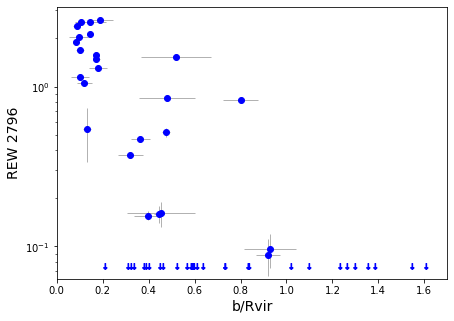

In [201]:
plt.figure(figsize = (7,5))
plt.errorbar(np.array(isol_visu_rot["B_KPC"]/isol_visu_rot["Rvir"]), np.array(isol_visu_rot["REW_2796"]),\
            xerr = np.array(isol_visu_rot["Rvir_err"]*isol_visu_rot["B_KPC"]/(isol_visu_rot["Rvir"]**2)),\
            yerr = np.array(isol_visu_rot["sig_REW_2796"]), \
             linestyle = "none", color = "gray", linewidth = 0.6);
plt.scatter(np.array(isol_visu_rot_abs["B_KPC"]/isol_visu_rot_abs["Rvir"]), np.array(isol_visu_rot_abs["REW_2796"]), \
            c = "blue", zorder = 3);
plt.scatter(np.array(isol_visu_rot_noabs["B_KPC"]/isol_visu_rot_noabs["Rvir"]), np.array(isol_visu_rot_noabs["detection_limit_p75"]), \
            c = "blue", zorder = 3, marker = "$\downarrow$");
plt.xlim((0,1.7))
#plt.xscale("log")
plt.yscale("log")
plt.xlabel("b/Rvir", size = 14)
plt.ylabel("REW 2796", size= 14)

In [202]:
len(isol_visu_rot)

57

Text(0, 0.5, 'REW 2796')

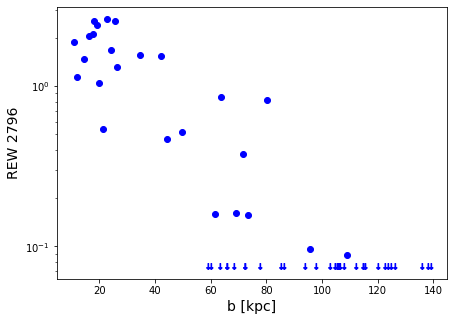

In [203]:
plt.figure(figsize = (7,5))
plt.scatter(np.array(isol_visu_rot_abs["B_KPC"]), np.array(isol_visu_rot_abs["REW_2796"]), \
            c = "blue", zorder = 3);
plt.scatter(np.array(isol_visu_rot_noabs["B_KPC"]), np.array(isol_visu_rot_noabs["detection_limit_p75"]), \
            c = "blue", zorder = 3, marker = "$\downarrow$");
#plt.xlim((0,40))
#plt.xscale("log")
plt.yscale("log")
plt.xlabel("b [kpc]", size = 14)
plt.ylabel("REW 2796", size= 14)

Text(0, 0.5, 'Rvir')

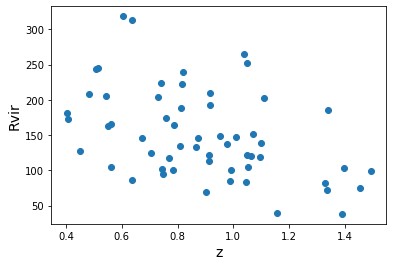

In [204]:
plt.scatter(isol_visu_rot["Z"], isol_visu_rot["Rvir"])
plt.xlabel("z", size = 14),
plt.ylabel("Rvir", size = 14)

## Mh - M* relation

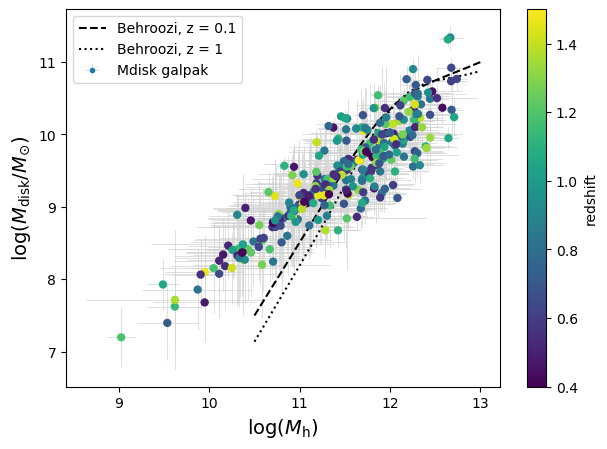

In [523]:
R_04_15_zconf1
logMh = np.linspace(10.5,13.,20)
logMstar_1 = gt.Behroozi_2019_inv(logMh, 1)
logMstar_01 = gt.Behroozi_2019_inv(logMh, 0.1)

plt.figure(figsize = (7,5), dpi = 100)
plt.errorbar(np.array(R_04_15_zconf1["log_Mvir"]), np.array(R_04_15_zconf1["log_Mdisk"]),\
             xerr = np.array(R_04_15_zconf1["log_Mvir_err"]), \
             yerr = np.array(R_04_15_zconf1["log_Mdisk_err"]), \
             label = "Mdisk galpak", linestyle = "none", marker = ".", ecolor = "lightgray", \
            linewidth = 0.5)
plt.scatter(np.array(R_04_15_zconf1["log_Mvir"]), np.array(R_04_15_zconf1["log_Mdisk"]),\
             c = np.array(R_04_15_zconf1["Z"]), edgecolor = "none", vmin = 0.4, vmax = 1.5, zorder = 3)
plt.colorbar(label = "redshift")
plt.plot(logMh, logMstar_01, c = "black", linestyle = "--", label = "Behroozi, z = 0.1")
plt.plot(logMh, logMstar_1, c = "black", linestyle = "dotted", label = "Behroozi, z = 1")
plt.legend()
plt.xlabel("$\log(M_{\mathrm{h}})$", size = 14)
plt.ylabel("$\log(M_{\mathrm{disk}}/M_{\odot})$", size = 14)

X = np.array(R_04_15_zconf1["log_Mvir"])
Y = np.array(R_04_15_zconf1["log_Mdisk"])
txt = np.array(R_04_15_zconf1["ID"])

#for i in range(len(isol_behroozi)):
#    plt.annotate(str(txt[i]), (X[i], Y[i]))

## Redshift evo of Rvir and Rs

Text(0, 0.5, 'Rvir')

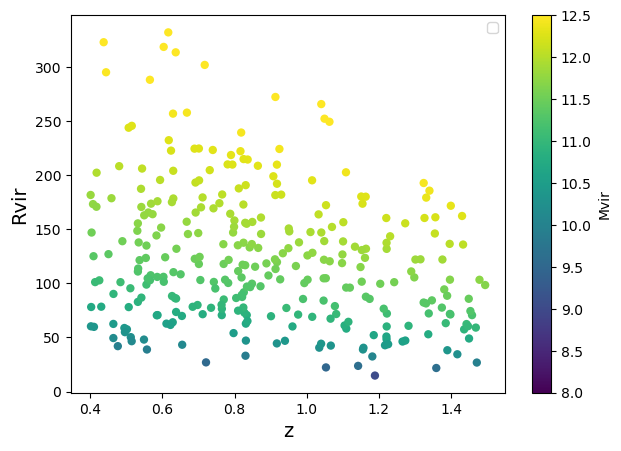

In [207]:
R_04_15_zconf1

plt.figure(figsize = (7,5), dpi = 100)
plt.scatter(np.array(R_04_15_zconf1["Z"]), np.array(R_04_15_zconf1["Rvir"]),\
             c = np.array(R_04_15_zconf1["log_Mvir"]), edgecolor = "none", vmin = 8, vmax = 12.5, zorder = 3)
plt.colorbar(label = "Mvir")
plt.legend()
plt.xlabel("z", size = 14)
plt.ylabel("Rvir", size = 14)

#X = np.array(R_04_15_zconf1["log_Mvir"])
#Y = np.array(R_04_15_zconf1["log_Mdisk"])
#txt = np.array(R_04_15_zconf1["ID"])

#for i in range(len(isol_behroozi)):
#    plt.annotate(str(txt[i]), (X[i], Y[i]))

Text(0, 0.5, 'Rs')

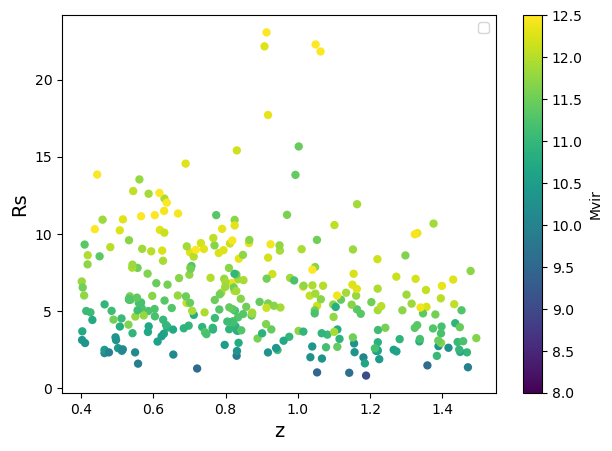

In [208]:
R_04_15_zconf1

plt.figure(figsize = (7,5), dpi = 100)
plt.scatter(np.array(R_04_15_zconf1["Z"]), np.array(R_04_15_zconf1["rs_kpc"]),\
             c = np.array(R_04_15_zconf1["log_Mvir"]), edgecolor = "none", vmin = 8, vmax = 12.5, zorder = 3)
plt.colorbar(label = "Mvir")
plt.legend()
plt.xlabel("z", size = 14)
plt.ylabel("Rs", size = 14)

#X = np.array(R_04_15_zconf1["log_Mvir"])
#Y = np.array(R_04_15_zconf1["log_Mdisk"])
#txt = np.array(R_04_15_zconf1["ID"])

#for i in range(len(isol_behroozi)):
#    plt.annotate(str(txt[i]), (X[i], Y[i]))

Text(0, 0.5, 'B kpc')

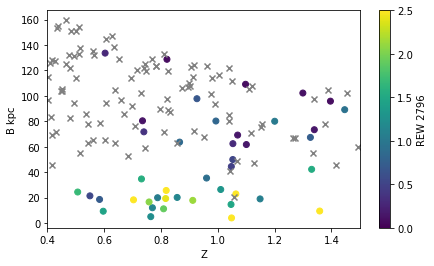

In [209]:
plt.figure(figsize = (7,4))
plt.scatter(isol_zconf_abs["Z"], isol_zconf_abs["B_KPC"], c = isol_zconf_abs["REW_2796"], vmin = 0, vmax = 2.5)
plt.colorbar(label = "REW 2796")
plt.scatter(isol_zconf_noabs["Z"], isol_zconf_noabs["B_KPC"], c = "gray", marker = "x")
plt.xlim((0.4, 1.5))
plt.xlabel("Z")
plt.ylabel("B kpc")

Text(0, 0.5, 'B kpc')

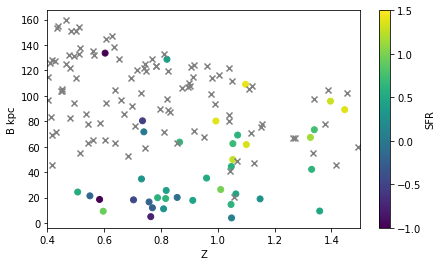

In [210]:
plt.figure(figsize = (7,4))
plt.scatter(isol_zconf_abs["Z"], isol_zconf_abs["B_KPC"], c = np.log10(isol_zconf_abs["SFR_gilbank"]), \
            vmin = -1, vmax = 1.5)
plt.colorbar(label = "SFR")
plt.scatter(isol_zconf_noabs["Z"], isol_zconf_noabs["B_KPC"], c = "gray", marker = "x")
plt.xlim((0.4, 1.5))
plt.xlabel("Z")
plt.ylabel("B kpc")

# Inner slope

- Inner slope dependance to SFR
- Inner slope dependance to REW
- Inner slope dependance to down-the-barrel absorption
- Inner slope dependance to mass
- Inner slope dependance to z
- Inner slope dependance to velocity dispersion
- Link between SFR and vdisp?

### For high alpha sample

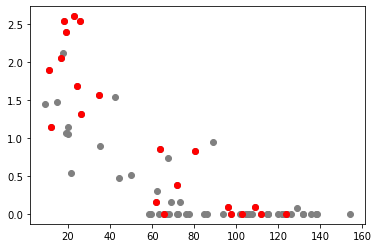

In [1463]:
plt.scatter(isol_9["B_KPC"], isol_9["REW_2796"], c = "grey")
plt.scatter(isol_visu_high_alpha["B_KPC"], isol_visu_high_alpha["REW_2796"], c = "r")

Text(0, 0.5, '$W^{2796}_{\\mathrm{r}}$ [$\\AA]$')

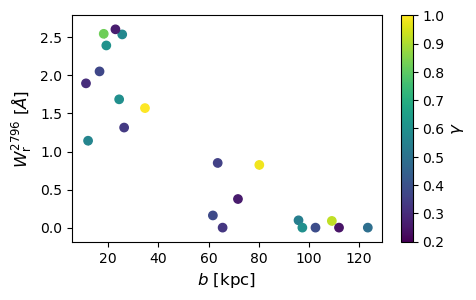

In [1494]:
plt.figure(figsize = (5,3), dpi = 100)
plt.errorbar(np.array(isol_visu_high_alpha["B_KPC"]), np.array(isol_visu_high_alpha["REW_2796"]), \
            yerr = np.maximum(isol_visu_high_alpha["sig_REW_2796"], 0.05), \
            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5)
plt.scatter(isol_visu_high_alpha["B_KPC"], isol_visu_high_alpha["REW_2796"], \
            c = isol_visu_high_alpha["gamma"], vmin = 0.2, vmax = 1)
cbar = plt.colorbar()
cbar.set_label("$\gamma$", fontsize = 12)
plt.xlabel("$b$ [kpc]", size = 12)
plt.ylabel("$W^{2796}_{\mathrm{r}}$ [$\AA]$", size = 12)

Text(50, 2.5, 'Minor axis')

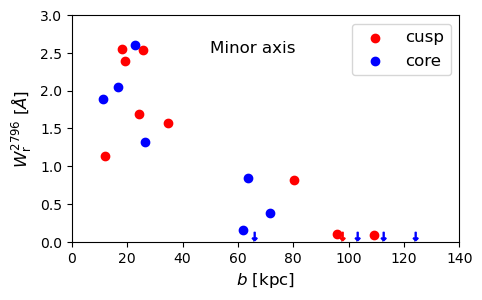

In [1755]:
plt.figure(figsize = (5,3), dpi = 100)
higha_cusp_abs = isol_visu_high_alpha_abs[isol_visu_high_alpha_abs["gamma"]>0.5]
higha_cusp_noabs = isol_visu_high_alpha_noabs[isol_visu_high_alpha_noabs["gamma"]>0.5]
higha_core_abs = isol_visu_high_alpha_abs[isol_visu_high_alpha_abs["gamma"]<=0.5]
higha_core_noabs = isol_visu_high_alpha_noabs[isol_visu_high_alpha_noabs["gamma"]<=0.5]
plt.errorbar(np.array(isol_visu_high_alpha["B_KPC"]), np.array(isol_visu_high_alpha["REW_2796"]), \
            yerr = np.maximum(isol_visu_high_alpha["sig_REW_2796"], 0.05), \
            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5)
plt.scatter(higha_cusp_abs["B_KPC"], higha_cusp_abs["REW_2796"], c = "red", label = "cusp")
plt.scatter(higha_cusp_noabs["B_KPC"], higha_cusp_noabs["detection_limit_p75"], c = "red", marker = "$\downarrow$")
plt.scatter(higha_core_abs["B_KPC"], higha_core_abs["REW_2796"], c = "blue", label = "core")
plt.scatter(higha_core_noabs["B_KPC"], higha_core_noabs["detection_limit_p75"], c = "blue", marker = "$\downarrow$")
cbar.set_label("$\gamma$", fontsize = 12)
plt.xlabel("$b$ [kpc]", size = 12)
plt.ylabel("$W^{2796}_{\mathrm{r}}$ [$\AA]$", size = 12)
plt.legend(fontsize = 12)
plt.xlim((0, 140))
plt.ylim((0, 3))
plt.text(50, 2.5, "Minor axis", size = 12)

Text(0, 0.5, '$W^{2796}_{\\mathrm{r}}$ [$\\AA]$')

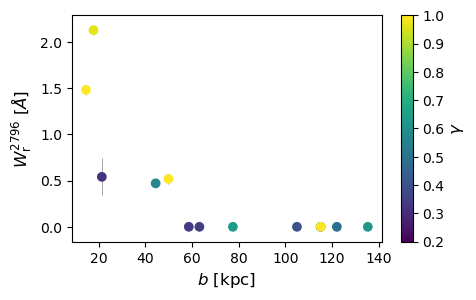

In [1495]:
plt.figure(figsize = (5,3), dpi = 100)
plt.errorbar(np.array(isol_visu_low_alpha["B_KPC"]), np.array(isol_visu_low_alpha["REW_2796"]), \
            yerr = np.maximum(isol_visu_low_alpha["sig_REW_2796"], 0.05), \
            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5)
plt.scatter(isol_visu_low_alpha["B_KPC"], isol_visu_low_alpha["REW_2796"], \
            c = isol_visu_low_alpha["gamma"], vmin = 0.2, vmax = 1)
cbar = plt.colorbar()
cbar.set_label("$\gamma$", fontsize = 12)
plt.xlabel("$b$ [kpc]", size = 12)
plt.ylabel("$W^{2796}_{\mathrm{r}}$ [$\AA]$", size = 12)

Text(50, 2.5, 'Major axis')

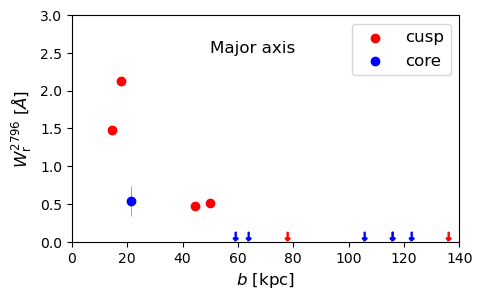

In [1756]:
plt.figure(figsize = (5,3), dpi = 100)
lowa_cusp_abs = isol_visu_low_alpha_abs[isol_visu_low_alpha_abs["gamma"]>0.5]
lowa_cusp_noabs = isol_visu_low_alpha_noabs[isol_visu_low_alpha_noabs["gamma"]>0.5]
lowa_core_abs = isol_visu_low_alpha_abs[isol_visu_low_alpha_abs["gamma"]<=0.5]
lowa_core_noabs = isol_visu_low_alpha_noabs[isol_visu_low_alpha_noabs["gamma"]<=0.5]
plt.errorbar(np.array(isol_visu_low_alpha["B_KPC"]), np.array(isol_visu_low_alpha["REW_2796"]), \
            yerr = np.maximum(isol_visu_low_alpha["sig_REW_2796"], 0.05), \
            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5)
plt.scatter(lowa_cusp_abs["B_KPC"], lowa_cusp_abs["REW_2796"], c = "red", label = "cusp")
plt.scatter(lowa_cusp_noabs["B_KPC"], lowa_cusp_noabs["detection_limit_p75"], c = "red", marker = "$\downarrow$")
plt.scatter(lowa_core_abs["B_KPC"], lowa_core_abs["REW_2796"], c = "blue", label = "core")
plt.scatter(lowa_core_noabs["B_KPC"], lowa_core_noabs["detection_limit_p75"], c = "blue", marker = "$\downarrow$")
cbar.set_label("$\gamma$", fontsize = 12)
plt.xlabel("$b$ [kpc]", size = 12)
plt.ylabel("$W^{2796}_{\mathrm{r}}$ [$\AA]$", size = 12)
plt.legend(fontsize = 12)
plt.xlim((0, 140))
plt.ylim((0, 3))
plt.text(50, 2.5, "Major axis", size = 12)

/home/cherrey/anaconda3/lib/python3.9/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


Text(0, 0.5, '$W^{2796}_{\\mathrm{r}}$ [$\\AA]$')

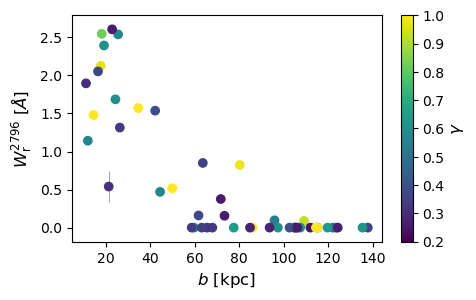

In [1501]:
plt.figure(figsize = (5,3), dpi = 100)
plt.errorbar(np.array(isol_visu_rot_incl["B_KPC"]), np.array(isol_visu_rot_incl["REW_2796"]), \
            yerr = np.maximum(isol_visu_rot_incl["sig_REW_2796"], 0.05), \
            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5)
plt.scatter(isol_visu_rot_incl["B_KPC"], isol_visu_rot_incl["REW_2796"], \
            c = isol_visu_rot_incl["gamma"], vmin = 0.2, vmax = 1)
cbar = plt.colorbar()
cbar.set_label("$\gamma$", fontsize = 12)
plt.xlabel("$b$ [kpc]", size = 12)
plt.ylabel("$W^{2796}_{\mathrm{r}}$ [$\AA]$", size = 12)

Text(0, 0.5, '$W^{2796}_{\\mathrm{r}}$ [$\\AA]$')

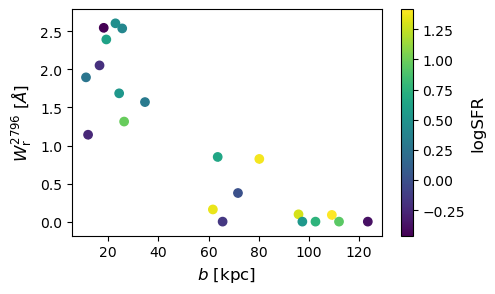

In [1498]:
plt.figure(figsize = (5,3), dpi = 100)
plt.errorbar(np.array(isol_visu_high_alpha["B_KPC"]), np.array(isol_visu_high_alpha["REW_2796"]), \
            yerr = np.maximum(isol_visu_high_alpha["sig_REW_2796"], 0.05), \
            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5)
plt.scatter(isol_visu_high_alpha["B_KPC"], isol_visu_high_alpha["REW_2796"], \
            c = isol_visu_high_alpha["logSFR"])
cbar = plt.colorbar()
cbar.set_label("logSFR", fontsize = 12)
plt.xlabel("$b$ [kpc]", size = 12)
plt.ylabel("$W^{2796}_{\mathrm{r}}$ [$\AA]$", size = 12)

(9.0, 11.0)

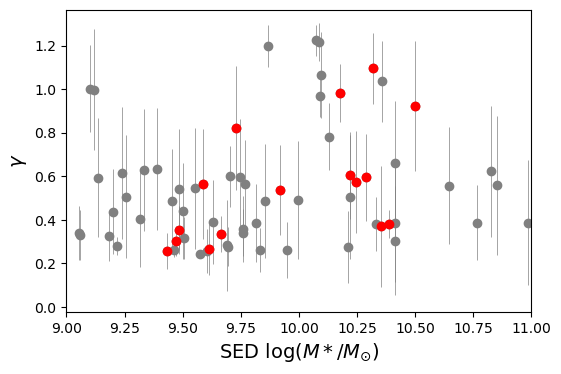

In [1701]:
plt.figure(figsize = (6,4), dpi = 100)
plt.errorbar(np.array(isol_9["sed_logMass"]), np.array(isol_9["gamma"]), \
            yerr = np.array(isol_9["gamma_err"]), \
            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5, marker = "o")
plt.scatter(isol_visu_high_alpha_abs["sed_logMass"], isol_visu_high_alpha_abs["gamma"], color = "red", zorder = 2)
plt.xlabel("SED log($M*/M_{\odot}$)", size = 14)
plt.ylabel("$\gamma$", size = 14)
plt.xlim((9, 11))

(-1.0, 2.5)

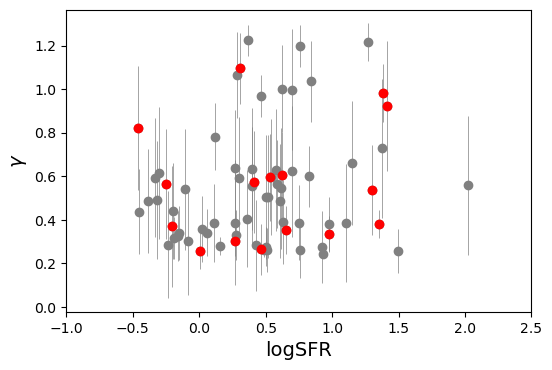

In [1713]:
plt.figure(figsize = (6,4), dpi = 100)
plt.errorbar(np.array(isol_9["logSFR"]), np.array(isol_9["gamma"]), \
            yerr = np.array(isol_9["gamma_err"]), \
            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5, marker = "o")
plt.scatter(isol_visu_high_alpha_abs["logSFR"], isol_visu_high_alpha_abs["gamma"], color = "red", zorder = 2)
plt.xlabel("logSFR", size = 14)
plt.ylabel("$\gamma$", size = 14)
#plt.xscale("log")
plt.xlim((-1, 2.5))
#plt.xlim((9, 11))

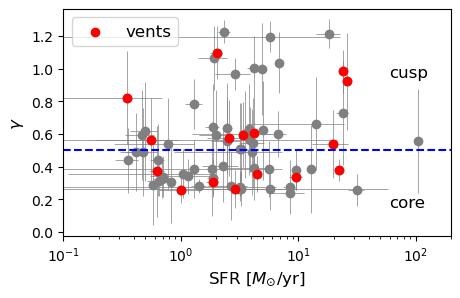

In [1738]:
plt.figure(figsize = (5,3), dpi = 100)
plt.errorbar(np.array(isol_9["SFR_gilbank"]), np.array(isol_9["gamma"]), \
            xerr = np.array(isol_9["SFR_gilbank_ERR"]),\
            yerr = np.array(isol_9["gamma_err"]), \
            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5, marker = "o")
plt.scatter(10**isol_visu_high_alpha_abs["logSFR"], isol_visu_high_alpha_abs["gamma"], \
            color = "red", zorder = 2, label = "vents")
plt.xlabel("SFR [$M_{\odot}$/yr]", size = 12)
plt.ylabel("$\gamma$", size = 12)
plt.xscale("log")
plt.xlim((0.1,200))
plt.axhline(0.5, c = "b", linestyle = "--")
plt.text(60, 0.95, "cusp", size = 12)
plt.text(60, 0.15, "core", size = 12)
#plt.xlim((9, 11))
plt.legend(fontsize = 12, loc = "upper left")

In [1735]:
len(isol_9[isol_9["gamma"]>0.5])/len(isol_9)

0.5

In [1736]:
len(isol_visu_high_alpha_abs[isol_visu_high_alpha_abs["gamma"]>0.5])/len(isol_visu_high_alpha_abs)

0.5625

In [1725]:
len(isol_9)

72

In [1724]:
len(isol_visu_high_alpha_abs)

16

Text(0, 0.5, '$\\gamma$')

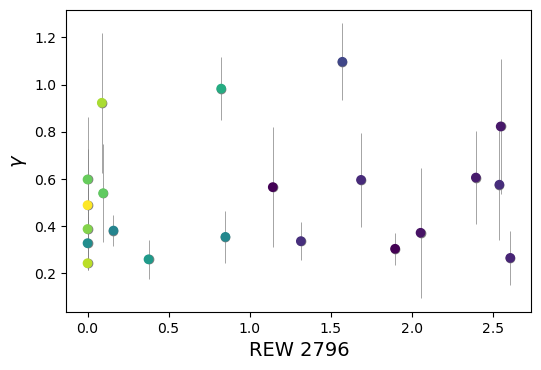

In [1474]:
plt.figure(figsize = (6,4), dpi = 100)
plt.errorbar(np.array(isol_visu_high_alpha["REW_2796"]), np.array(isol_visu_high_alpha["gamma"]), \
            yerr = np.array(isol_visu_high_alpha["gamma_err"]), \
            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5, marker = "o")
plt.scatter(isol_visu_high_alpha["REW_2796"], isol_visu_high_alpha["gamma"], \
            c = isol_visu_high_alpha["B_KPC"], zorder = 2)
plt.xlabel("REW 2796", size = 14)
plt.ylabel("$\gamma$", size = 14)
#plt.xlim((9, 11))

(9.0, 11.0)

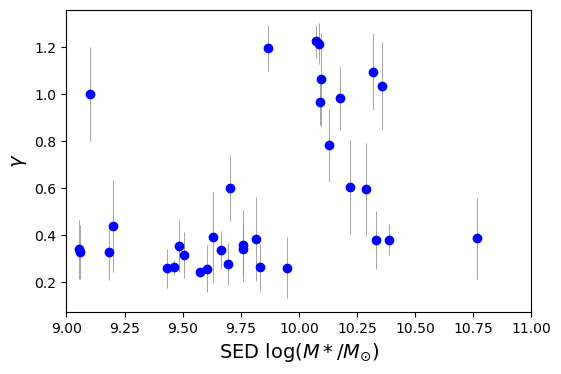

In [678]:
plt.figure(figsize = (6,4), dpi = 100)
plt.errorbar(np.array(inner_slope_5["sed_logMass"]), np.array(inner_slope_5["gamma"]), \
            yerr = np.array(inner_slope_5["gamma_err"]), \
            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5)
plt.scatter(inner_slope_5["sed_logMass"], inner_slope_5["gamma"], color = "blue", zorder = 2)
plt.xlabel("SED log($M*/M_{\odot}$)", size = 14)
plt.ylabel("$\gamma$", size = 14)
plt.xlim((9, 11))

Text(0, 0.5, 'inner slope')

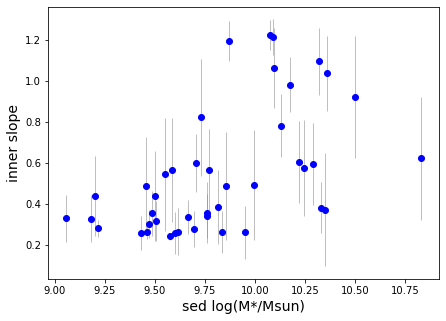

In [169]:
plt.figure(figsize = (7,5))
plt.errorbar(np.array(inner_slope_5["sed_logMass"]), np.array(inner_slope_5["gamma"]), \
            yerr = np.array(inner_slope_5["gamma_err"]), \
            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5)
plt.scatter(inner_slope_5["sed_logMass"], inner_slope_5["gamma"], color = "blue", zorder = 2)
plt.xlabel("sed log(M*/Msun)", size = 14)
plt.ylabel("inner slope", size = 14)

Text(0, 0.5, '$\\gamma$')

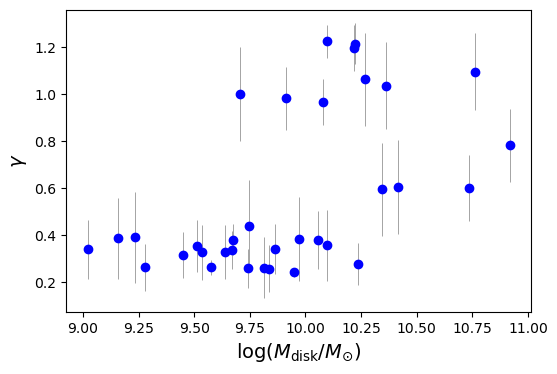

In [684]:
plt.figure(figsize = (6,4), dpi = 100)
plt.errorbar(np.array(inner_slope_5["log_Mdisk"]), np.array(inner_slope_5["gamma"]), \
            yerr = np.array(inner_slope_5["gamma_err"]), \
            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5)
plt.scatter(inner_slope_5["log_Mdisk"], inner_slope_5["gamma"], color = "blue", zorder = 2)
plt.xlabel("$\log(M_{\mathrm{disk}}/M_{\odot})$", size = 14)
plt.ylabel("$\gamma$", size = 14)

Text(0, 0.5, 'inner slope')

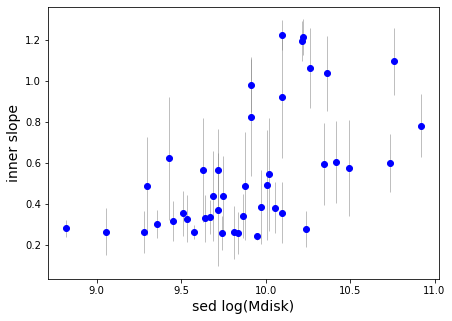

In [171]:
plt.figure(figsize = (7,5))
plt.errorbar(np.array(inner_slope["log_Mdisk"]), np.array(inner_slope["gamma"]), \
            yerr = np.array(inner_slope["gamma_err"]), \
            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5)
plt.scatter(inner_slope["log_Mdisk"], inner_slope["gamma"], color = "blue", zorder = 2)
plt.xlabel("sed log(Mdisk)", size = 14)
plt.ylabel("inner slope", size = 14)

Text(0, 0.5, '$\\gamma$')

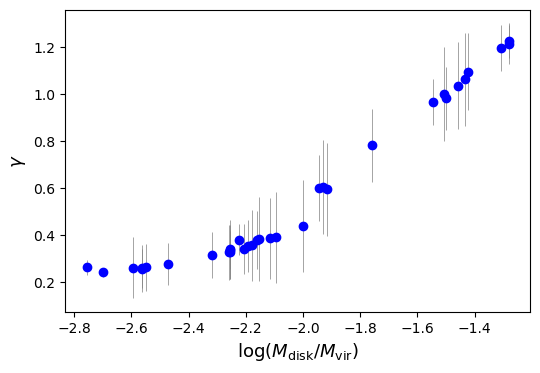

In [738]:
plt.figure(figsize = (6,4), dpi = 100)
plt.errorbar(np.array(np.log10(10**inner_slope_5["log_Mdisk"]/(10**inner_slope_5["log_Mvir"]))), \
             np.array(inner_slope_5["gamma"]), \
            yerr = np.array(inner_slope_5["gamma_err"]), \
            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5)
plt.scatter(np.array(np.log10(10**inner_slope_5["log_Mdisk"]/(10**inner_slope_5["log_Mvir"]))),\
            inner_slope_5["gamma"], color = "blue", zorder = 2)
plt.xlabel("$\log(M_{\mathrm{disk}}/M_{\mathrm{vir}})$", size = 13)
plt.ylabel("$\gamma$", size = 13)

Text(0, 0.5, 'inner slope')

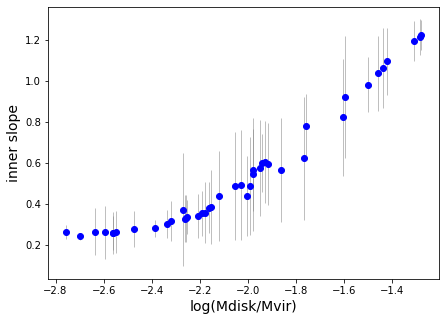

In [172]:
plt.figure(figsize = (7,5))
plt.errorbar(np.array(np.log10(10**inner_slope["log_Mdisk"]/(10**inner_slope["log_Mvir"]))), \
             np.array(inner_slope["gamma"]), \
            yerr = np.array(inner_slope["gamma_err"]), \
            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5)
plt.scatter(np.array(np.log10(10**inner_slope["log_Mdisk"]/(10**inner_slope["log_Mvir"]))),\
            inner_slope["gamma"], color = "blue", zorder = 2)
plt.xlabel("log(Mdisk/Mvir)", size = 14)
plt.ylabel("inner slope", size = 14)

Text(0, 0.5, '$\\gamma$')

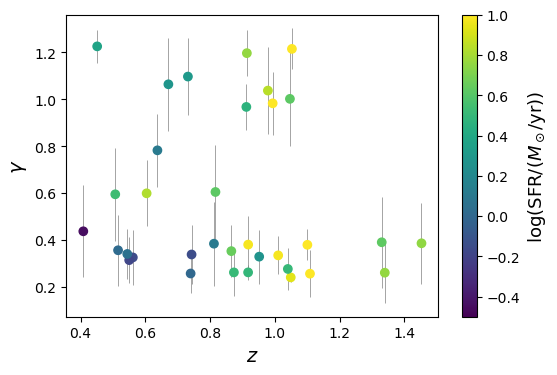

In [702]:
plt.figure(figsize = (6,4), dpi = 100)
plt.errorbar(np.array(inner_slope_5["Z"]), np.array(inner_slope_5["gamma"]), \
            yerr = np.array(inner_slope_5["gamma_err"]), \
            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5)
plt.scatter(inner_slope_5["Z"], inner_slope_5["gamma"], c = inner_slope_5["logSFR"], zorder = 2, vmin = -0.5, vmax = 1)
plt.xlabel("$z$", size = 14)
cbar = plt.colorbar()
cbar.set_label("log(SFR/$(M_\odot$/yr))", fontsize = 13)
plt.ylabel("$\gamma$", size = 14)

(-1.0, 2.0)

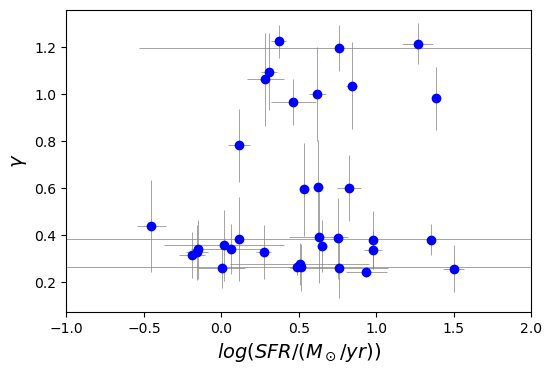

In [751]:
plt.figure(figsize = (6,4), dpi = 100)
plt.errorbar(np.array(inner_slope_5["logSFR"]), np.array(inner_slope_5["gamma"]), \
            xerr = np.array(inner_slope_5["SFR_gilbank_ERR"]/inner_slope_5["SFR_gilbank"]/np.log(10)),\
            yerr = np.array(inner_slope_5["gamma_err"]), \
            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5)
plt.scatter(inner_slope_5["logSFR"], inner_slope_5["gamma"], zorder = 2, vmin = -0.5, vmax = 1, c = "blue")
plt.xlabel("$log(SFR/(M_\odot/yr))$", size = 14)
plt.ylabel("$\gamma$", size = 14)
plt.xlim((-1,2))

Text(0, 0.5, '$\\gamma$')

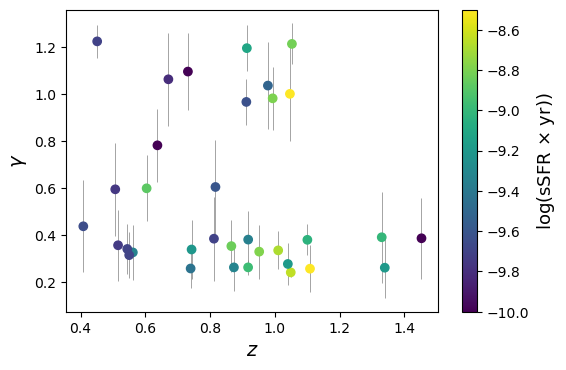

In [712]:
plt.figure(figsize = (6,4), dpi = 100)
plt.errorbar(np.array(inner_slope_5["Z"]), np.array(inner_slope_5["gamma"]), \
            yerr = np.array(inner_slope_5["gamma_err"]), \
            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5)
plt.scatter(inner_slope_5["Z"], inner_slope_5["gamma"], c = inner_slope_5["logSSFR"], \
            zorder = 2, vmin = -10, vmax = -8.5)
plt.xlabel("$z$", size = 14)
cbar = plt.colorbar()
cbar.set_label("log(sSFR $\\times$ yr))", fontsize = 13)
plt.ylabel("$\gamma$", size = 14)

In [ ]:
inner_slope_5["log"]

(-10.5, -7.5)

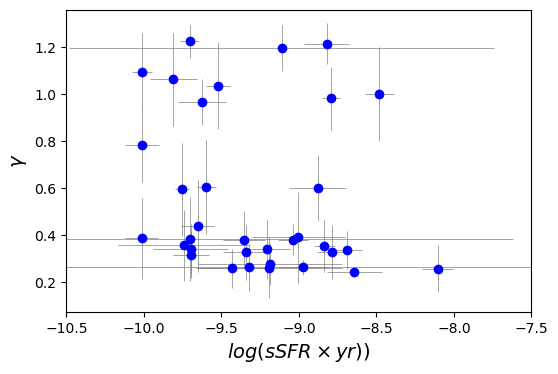

In [760]:
err_sSFR = inner_slope_5["SFR_gilbank_ERR"]/(10**inner_slope_5["sed_logMass"]) + \
            inner_slope_5["SFR_gilbank"]*inner_slope_5["sed_logMass_ERR"]*np.log(10)/(10**inner_slope_5["sed_logMass"])
plt.figure(figsize = (6,4), dpi = 100)
plt.errorbar(np.array(inner_slope_5["logSSFR"]), np.array(inner_slope_5["gamma"]), \
            xerr = np.array(err_sSFR/(10**inner_slope_5["logSSFR"])/np.log(10)),\
            yerr = np.array(inner_slope_5["gamma_err"]), \
            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5)
plt.scatter(inner_slope_5["logSSFR"], inner_slope_5["gamma"], zorder = 2, vmin = -0.5, vmax = 1, c = "blue")
plt.xlabel("$log(sSFR \\times yr))$", size = 14)
plt.ylabel("$\gamma$", size = 14)
plt.xlim((-10.5,-7.5))

(-10.5, -7.5)

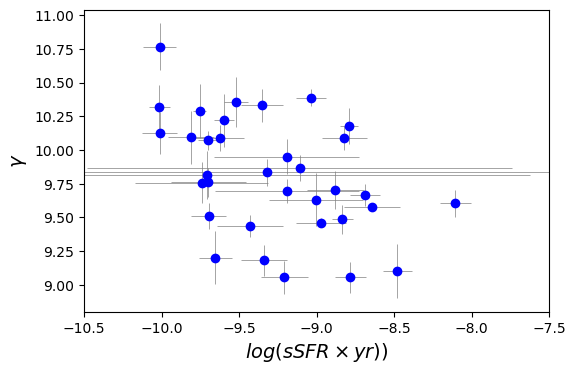

In [766]:
err_sSFR = inner_slope_5["SFR_gilbank_ERR"]/(10**inner_slope_5["sed_logMass"]) + \
            inner_slope_5["SFR_gilbank"]*inner_slope_5["sed_logMass_ERR"]*np.log(10)/(10**inner_slope_5["sed_logMass"])
plt.figure(figsize = (6,4), dpi = 100)
plt.errorbar(np.array(inner_slope_5["logSSFR"]), np.array(inner_slope_5["sed_logMass"]), \
            xerr = np.array(err_sSFR/(10**inner_slope_5["logSSFR"])/np.log(10)),\
            yerr = np.array(inner_slope_5["gamma_err"]), \
            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5)
plt.scatter(inner_slope_5["logSSFR"], inner_slope_5["sed_logMass"], zorder = 2, vmin = -0.5, vmax = 1, c = "blue")
plt.xlabel("$log(sSFR \\times yr))$", size = 14)
plt.ylabel("$\gamma$", size = 14)
plt.xlim((-10.5,-7.5))

Text(0, 0.5, 'inner slope')

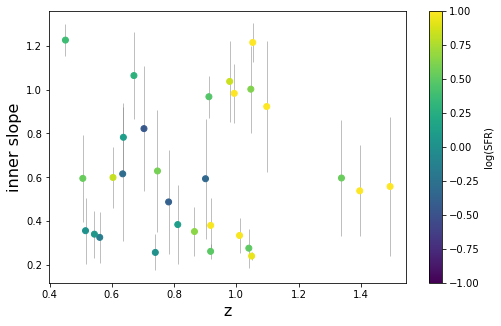

In [174]:
plt.figure(figsize = (8,5))
plt.errorbar(np.array(inner_slope_2["Z"]), np.array(inner_slope_2["gamma"]), \
            yerr = np.array(inner_slope_2["gamma_err"]), \
            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5)
plt.scatter(inner_slope_2["Z"], inner_slope_2["gamma"], c = inner_slope_2["logSFR"], zorder = 2, vmin = -1, vmax = 1)
plt.xlabel("z", size = 16)
plt.colorbar(label = "log(SFR)")
plt.ylabel("inner slope", size = 16)

Text(0, 0.5, '$W^{2796}_{\\mathrm{r}}$')

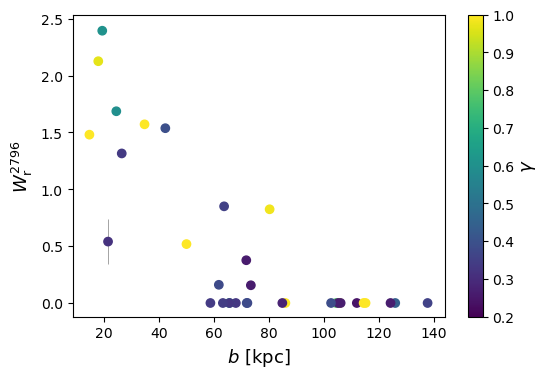

In [765]:
plt.figure(figsize = (6,4), dpi = 100)
plt.errorbar(np.array(inner_slope_5["B_KPC"]), np.array(inner_slope_5["REW_2796"]), \
            yerr = np.array(inner_slope_5["sig_REW_2796"]), \
            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5)
plt.scatter(inner_slope_5["B_KPC"], inner_slope_5["REW_2796"], c = inner_slope_5["gamma"], zorder = 2, \
            vmin = 0.2, vmax = 1)
plt.xlabel("$b$ [kpc]", size = 13)
cbar = plt.colorbar()
cbar.set_label("$\gamma$", fontsize = 13)
plt.ylabel("$W^{2796}_{\mathrm{r}}$", size = 13)
#plt.xscale("log")

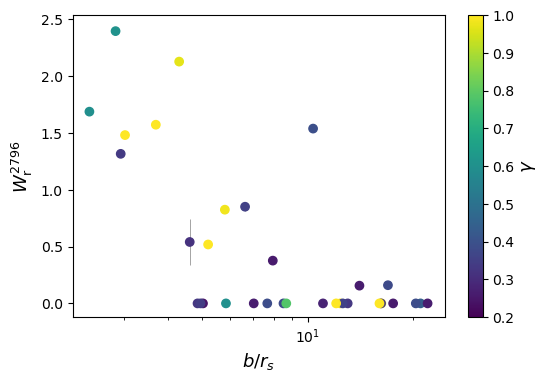

In [762]:
plt.figure(figsize = (6,4), dpi = 100)
plt.errorbar(np.array(inner_slope_5["B_KPC"]/inner_slope_5["rs_kpc"]), np.array(inner_slope_5["REW_2796"]), \
            yerr = np.array(inner_slope_5["sig_REW_2796"]), \
            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5)
plt.scatter(inner_slope_5["B_KPC"]/inner_slope_5["rs_kpc"], inner_slope_5["REW_2796"], c = inner_slope_5["gamma"], zorder = 2, \
            vmin = 0.2, vmax = 1)
plt.xlabel("$b/r_s$", size = 13)
cbar = plt.colorbar()
cbar.set_label("$\gamma$", fontsize = 13)
plt.ylabel("$W^{2796}_{\mathrm{r}}$", size = 13)
plt.xscale("log")

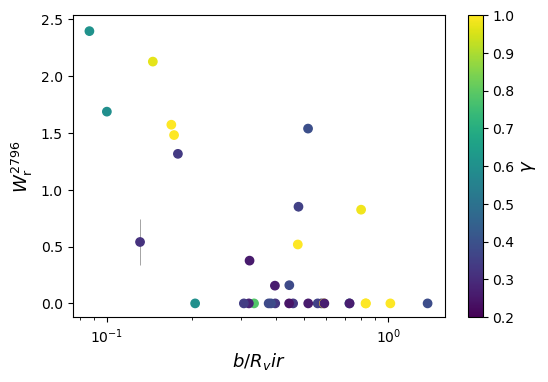

In [764]:
plt.figure(figsize = (6,4), dpi = 100)
plt.errorbar(np.array(inner_slope_5["B_KPC"]/inner_slope_5["Rvir"]), np.array(inner_slope_5["REW_2796"]), \
            yerr = np.array(inner_slope_5["sig_REW_2796"]), \
            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5)
plt.scatter(inner_slope_5["B_KPC"]/inner_slope_5["Rvir"], inner_slope_5["REW_2796"], c = inner_slope_5["gamma"], zorder = 2, \
            vmin = 0.2, vmax = 1)
plt.xlabel("$b/R_vir$", size = 13)
cbar = plt.colorbar()
cbar.set_label("$\gamma$", fontsize = 13)
plt.ylabel("$W^{2796}_{\mathrm{r}}$", size = 13)
plt.xscale("log")

Text(0, 0.5, 'gas density')

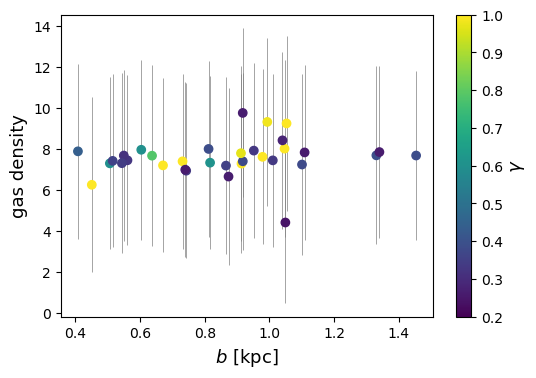

In [701]:
plt.figure(figsize = (6,4), dpi = 100)
plt.errorbar(np.array(inner_slope_5["Z"]), np.array(inner_slope_5["gas_density"]), \
            yerr = np.array(inner_slope_5["gas_density_err"]), \
            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5)
plt.scatter(inner_slope_5["Z"], inner_slope_5["gas_density"], c = inner_slope_5["gamma"], zorder = 2, \
            vmin = 0.2, vmax = 1)
plt.xlabel("$b$ [kpc]", size = 13)
cbar = plt.colorbar()
cbar.set_label("$\gamma$", fontsize = 13)
plt.ylabel("gas density", size = 13)

Text(0, 0.5, 'inner slope')

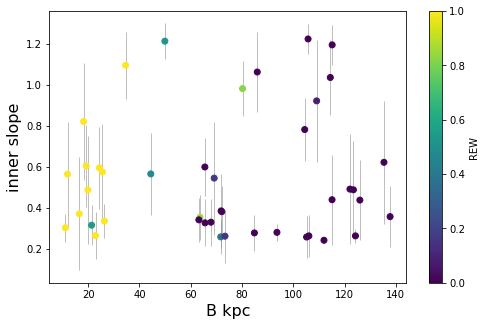

In [175]:
plt.figure(figsize = (8,5))
plt.errorbar(np.array(inner_slope["B_KPC"]), np.array(inner_slope["gamma"]), \
            yerr = np.array(inner_slope["gamma_err"]), \
            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5)
plt.scatter(inner_slope["B_KPC"], inner_slope["gamma"], c = inner_slope["REW_2796"], zorder = 2, \
            vmin = 0, vmax = 1)
plt.xlabel("B kpc", size = 16)
plt.colorbar(label = "REW")
plt.ylabel("inner slope", size = 16)

Text(0, 0.5, 'inner slope')

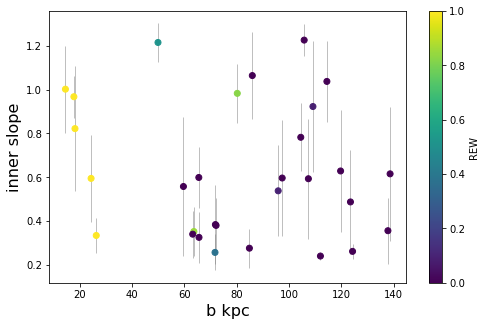

In [176]:
plt.figure(figsize = (8,5))
plt.errorbar(np.array(inner_slope_2["B_KPC"]), np.array(inner_slope_2["gamma"]), \
            yerr = np.array(inner_slope_2["gamma_err"]), \
            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5)
plt.scatter(inner_slope_2["B_KPC"], inner_slope_2["gamma"], c = inner_slope_2["REW_2796"], zorder = 2, \
            vmin = 0, vmax = 1)
plt.xlabel("b kpc", size = 16)
plt.colorbar(label = "REW")
plt.ylabel("inner slope", size = 16)

Text(0, 0.5, 'inner slope')

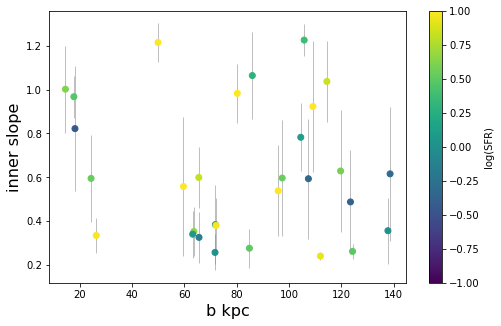

In [177]:
plt.figure(figsize = (8,5))
plt.errorbar(np.array(inner_slope_2["B_KPC"]), np.array(inner_slope_2["gamma"]), \
            yerr = np.array(inner_slope_2["gamma_err"]), \
            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5)
plt.scatter(inner_slope_2["B_KPC"], inner_slope_2["gamma"], c = inner_slope_2["logSFR"], zorder = 2, vmin = -1, vmax = 1)
plt.xlabel("b kpc", size = 16)
plt.colorbar(label = "log(SFR)")
plt.ylabel("inner slope", size = 16)

Text(0, 0.5, 'inner slope')

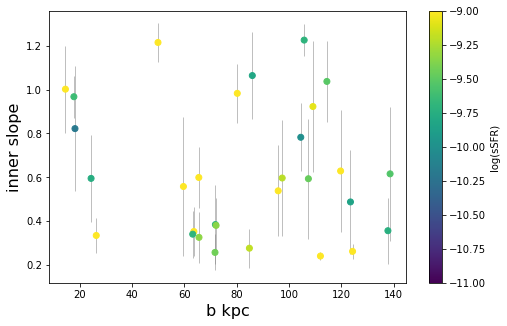

In [183]:
plt.figure(figsize = (8,5))
plt.errorbar(np.array(inner_slope_2["B_KPC"]), np.array(inner_slope_2["gamma"]), \
            yerr = np.array(inner_slope_2["gamma_err"]), \
            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5)
plt.scatter(inner_slope_2["B_KPC"], inner_slope_2["gamma"], c = inner_slope_2["logSSFR"], zorder = 2,\
            vmin = -11, vmax = -9)
plt.xlabel("b kpc", size = 16)
plt.colorbar(label = "log(sSFR)")
plt.ylabel("inner slope", size = 16)

Text(0, 0.5, 'REW 2796')

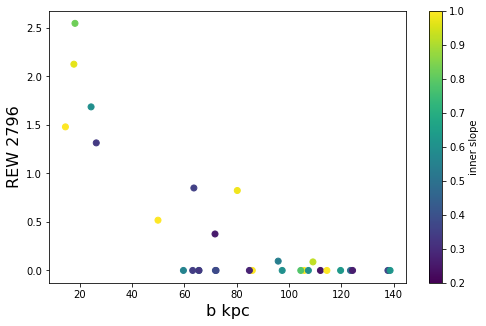

In [111]:
plt.figure(figsize = (8,5))
plt.scatter(inner_slope_2["B_KPC"], inner_slope_2["REW_2796"], c = inner_slope_2["gamma"], zorder = 2,\
            vmin = 0.2, vmax = 1)
plt.xlabel("b kpc", size = 16)
plt.colorbar(label = "inner slope")
plt.ylabel("REW 2796", size = 16)

Text(0, 0.5, 'REW 2796')

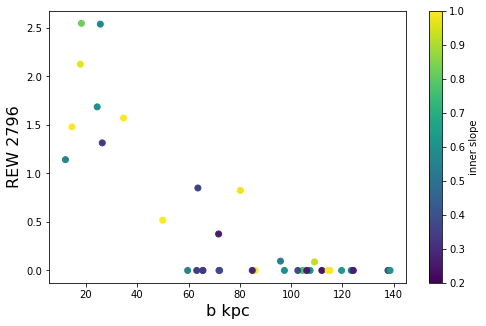

In [116]:
plt.figure(figsize = (8,5))
plt.scatter(inner_slope_3["B_KPC"], inner_slope_3["REW_2796"], c = inner_slope_3["gamma"], zorder = 2,\
            vmin = 0.2, vmax = 1)
plt.xlabel("b kpc", size = 16)
plt.colorbar(label = "inner slope")
plt.ylabel("REW 2796", size = 16)

Text(0, 0.5, 'inner slope')

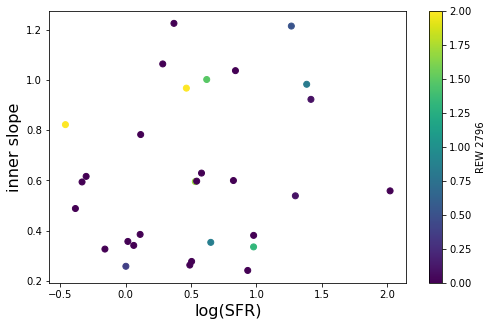

In [132]:
plt.figure(figsize = (8,5))
plt.scatter(inner_slope_2["logSFR"], inner_slope_2["gamma"], zorder = 2,\
            vmin = 0.0, vmax = 2., c = inner_slope_2["REW_2796"])
plt.colorbar(label = "REW 2796")
plt.xlabel("log(SFR)", size = 16)
plt.ylabel("inner slope", size = 16)


Text(0, 0.5, 'inner slope')

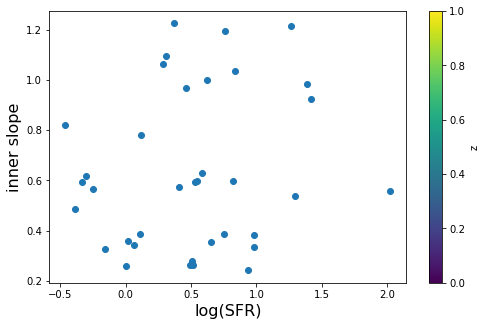

In [121]:
plt.figure(figsize = (8,5))
plt.scatter(inner_slope_3["logSFR"], inner_slope_3["gamma"], zorder = 2,\
            vmin = 0.2, vmax = 1)
plt.colorbar(label = "z")
plt.xlabel("log(SFR)", size = 16)
plt.ylabel("inner slope", size = 16)


Text(0, 0.5, 'inner slope')

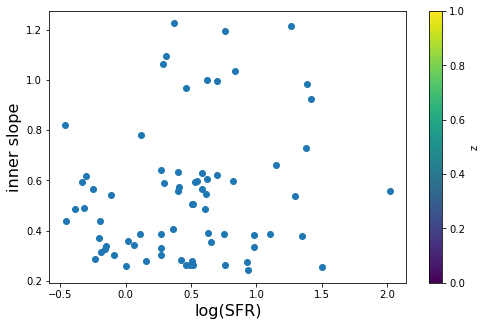

In [123]:
plt.figure(figsize = (8,5))
plt.scatter(isol_9["logSFR"], isol_9["gamma"], zorder = 2,\
            vmin = 0.2, vmax = 1)
plt.colorbar(label = "z")
plt.xlabel("log(SFR)", size = 16)
plt.ylabel("inner slope", size = 16)

(6.0, 10.0)

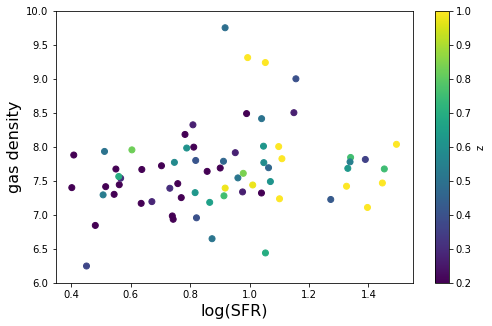

In [211]:
plt.figure(figsize = (8,5))
plt.scatter(isol_9["Z"], isol_9["gas_density"], zorder = 2,\
            vmin = 0.2, vmax = 1, c = isol_9["logSFR"])
plt.colorbar(label = "z")
plt.xlabel("log(SFR)", size = 16)
plt.ylabel("gas density", size = 16)
plt.ylim((6,10))

Text(0, 0.5, 'inner slope')

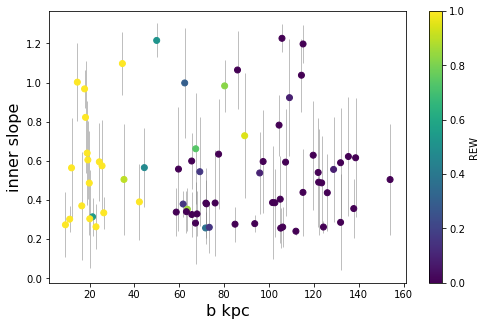

In [97]:
plt.figure(figsize = (8,5))
plt.errorbar(np.array(isol_9["B_KPC"]), np.array(isol_9["gamma"]), \
            yerr = np.array(isol_9["gamma_err"]), \
            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5)
plt.scatter(isol_9["B_KPC"], isol_9["gamma"], c = isol_9["REW_2796"], zorder = 2, \
            vmin = 0, vmax = 1)
plt.xlabel("b kpc", size = 16)
plt.colorbar(label = "REW")
plt.ylabel("inner slope", size = 16)

(0.0, 150.0)

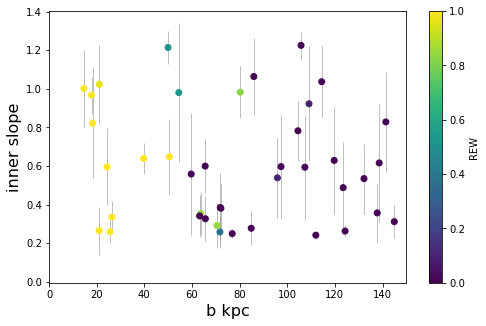

In [107]:
plt.figure(figsize = (8,5))
plt.errorbar(np.array(closest_inner_slope_2["B_KPC"]), np.array(closest_inner_slope_2["gamma"]), \
            yerr = np.array(closest_inner_slope_2["gamma_err"]), \
            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5)
plt.scatter(closest_inner_slope_2["B_KPC"], closest_inner_slope_2["gamma"], c = closest_inner_slope_2["REW_2796"], zorder = 2, \
            vmin = 0, vmax = 1)
plt.xlabel("b kpc", size = 16)
plt.colorbar(label = "REW")
plt.ylabel("inner slope", size = 16)
plt.xlim((0,150))

Text(0, 0.5, 'inner slope')

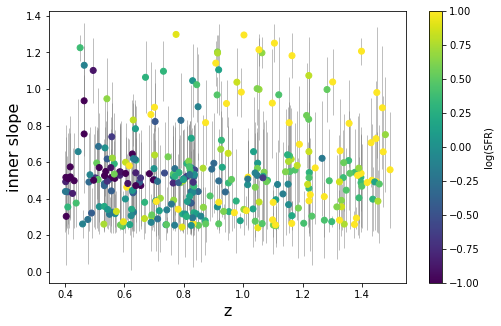

In [30]:
plt.figure(figsize = (8,5))
plt.errorbar(np.array(R_04_15_zconf1["Z"]), np.array(R_04_15_zconf1["gamma"]), \
            yerr = np.array(R_04_15_zconf1["gamma_err"]), \
            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5)
plt.scatter(R_04_15_zconf1["Z"], R_04_15_zconf1["gamma"], c = R_04_15_zconf1["logSFR"], zorder = 2, vmin = -1, vmax = 1)
plt.colorbar(label = "log(SFR)")
plt.xlabel("z", size = 16)
plt.ylabel("inner slope", size = 16)

Text(0, 0.5, 'logSFR')

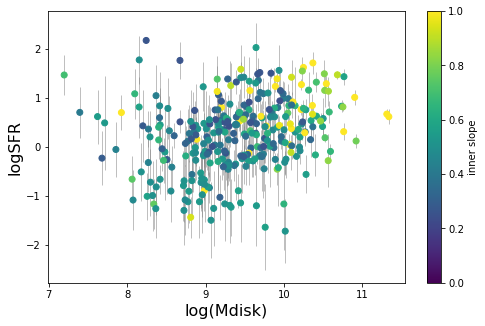

In [117]:
plt.figure(figsize = (8,5))
plt.errorbar(np.array(R_04_15_zconf1["log_Mdisk"]), np.array(R_04_15_zconf1["logSFR"]), \
            yerr = np.array(R_04_15_zconf1["log_Mdisk_err"]), \
            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5)
plt.scatter(R_04_15_zconf1["log_Mdisk"], R_04_15_zconf1["logSFR"], c = R_04_15_zconf1["gamma"], zorder = 2, vmin = 0, vmax = 1)
plt.colorbar(label = "inner slope")
plt.xlabel("log(Mdisk)", size = 16)
plt.ylabel("logSFR", size = 16)

Text(0, 0.5, 'sed')

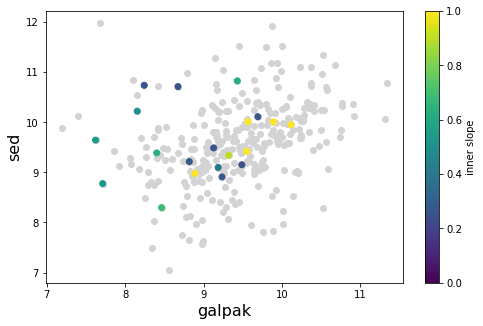

In [32]:
plt.figure(figsize = (8,5))
sel = (R_04_15_zconf1['radius']>2)
sel = (R_04_15_zconf1['radius']>2) * (R_04_15_zconf1['snr_from_src']>8)
sel = (R_04_15_zconf1['radius']>2) * (R_04_15_zconf1['snr_from_src']>8)*(R_04_15_zconf1['v22']/R_04_15_zconf1['velocity_dispersion_2Rd']<2)
#plt.errorbar(np.array(R_04_15_zconf1["sed_logMass"][sel]), np.array(R_04_15_zconf1["logSFR"][sel]), \
#            yerr = np.array(R_04_15_zconf1["sed_logMass_err"]), \
#            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5)
plt.scatter(R_04_15_zconf1["log_Mdisk"], R_04_15_zconf1["sed_logMass"], c = "lightgray", zorder = 2, vmin = 0, vmax = 1)
plt.scatter(R_04_15_zconf1["log_Mdisk"][sel], R_04_15_zconf1["sed_logMass"][sel], c = R_04_15_zconf1["gamma"][sel], zorder = 2, vmin = 0, vmax = 1)
plt.colorbar(label = "inner slope")
plt.xlabel("galpak", size = 16)
plt.ylabel("sed", size = 16)

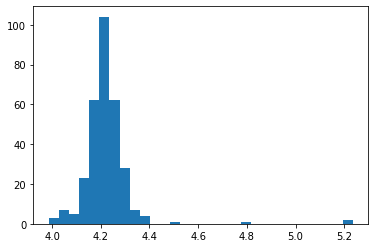

In [33]:
plt.hist(np.log10(R_04_15_zconf1["BIC"]), bins = 30);

Text(0, 0.5, 'sed')

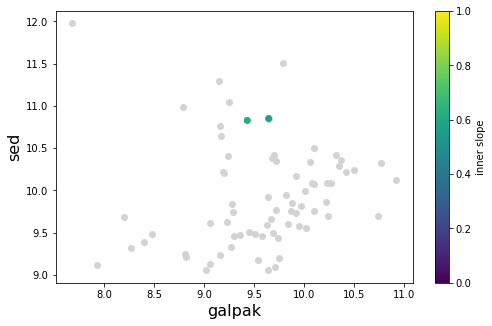

In [34]:
plt.figure(figsize = (8,5))
sel = (isol_9['radius']>2)
sel = (isol_9['radius']>2) * (isol_9['snr_from_src']>8)
sel = (isol_9['radius']>2) * (isol_9['snr_from_src']>8)*(isol_9['sed_logMass']>10.5)
#plt.errorbar(np.array(R_04_15_zconf1["sed_logMass"][sel]), np.array(R_04_15_zconf1["logSFR"][sel]), \
#            yerr = np.array(R_04_15_zconf1["sed_logMass_err"]), \
#            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5)
plt.scatter(isol_9["log_Mdisk"], isol_9["sed_logMass"], c = "lightgray", zorder = 2, vmin = 0, vmax = 1)
plt.scatter(isol_9["log_Mdisk"][sel], isol_9["sed_logMass"][sel], c = isol_9["gamma"][sel], zorder = 2, vmin = 0, vmax = 1)
plt.colorbar(label = "inner slope")
plt.xlabel("galpak", size = 16)
plt.ylabel("sed", size = 16)

In [35]:
isol_9[sel]

Unnamed: 0     ID    field_id    DATASET       FROM        Z  ZCONF  \
1027           0  21111  J0937p0656  b'psfsub'  b'FELINE'  1.49418      3   
1910           0  31087  J2137p0012  b'psfsub'  b'FELINE'  0.55956      3   

      is_QSO  is_star DR1_id  ...    logSFR   logSSFR  sed_logMass_2sig_err  \
1027       0        0    NaN  ...  2.021209  0.985757              0.069828   
1910       0        0    NaN  ...  0.698003 -0.336547              0.026136   

      sed_logMass_1sig_err  orientation  rs_pixel rs_pixel_err radius_kpc_err  \
1027              0.034914            1  1.871027     2.167876       0.155481   
1910              0.013068            0  4.195803     5.059346       0.339900   

     isolation_dist        Rfov  
1027     101.640940  258.951478  
1910     153.036766  196.906095  

[2 rows x 268 columns]

In [527]:
k1 = R_04_15_zconf1['radius']>1
k2 = R_04_15_zconf1['snr_from_src']>5
k3 = (R_04_15_zconf1['v22']/R_04_15_zconf1['velocity_dispersion_2Rd']>2)

T = R_04_15_zconf1[k1 & k2 & k3]

In [635]:
len(T)

149

## sed logm versus logmdisk

(7.5, 11.8)

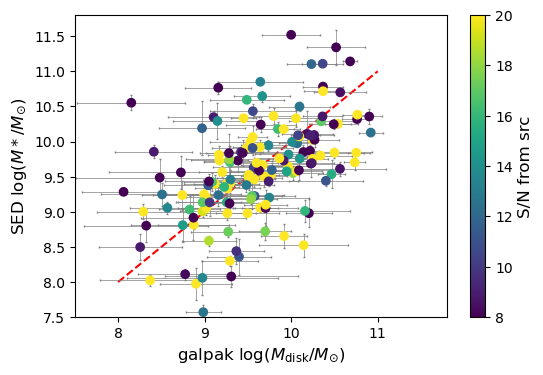

In [532]:
plt.figure(figsize = (6,4), dpi = 100)
#plt.errorbar(np.array(R_04_15_zconf1["log_Mdisk"]), np.array(R_04_15_zconf1["sed_logMass"]), \
#            xerr = np.array(R_04_15_zconf1["log_Mdisk_err"]), \
#            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5, alpha = 0.3)
plt.errorbar(np.array(T["log_Mdisk"]), np.array(T["sed_logMass"]), \
            xerr = np.array(T["log_Mdisk_err"]), yerr = np.array(T["sed_logMass_ERR"]),\
            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5, alpha = 1, capsize = 1)
#plt.vlines(R_04_15_zconf1["log_Mdisk"], R_04_15_zconf1["sed_logMass_l95"], \
#           R_04_15_zconf1["sed_logMass_u95"],color = "gray", zorder = 1, linewidth = 0.5, alpha = 0.3)
#plt.vlines(T["log_Mdisk"], T["sed_logMass_l95"], \
#          T["sed_logMass_u95"],color = "gray", zorder = 1, linewidth = 0.5, alpha = 0.3)
#plt.scatter(R_04_15_zconf1["log_Mdisk"], R_04_15_zconf1["sed_logMass"], c = "lightgray", \
#            zorder = 2, vmin = 0, vmax = 1, alpha = 0.3)
plt.scatter(T["log_Mdisk"], T["sed_logMass"], c = np.abs(T["snr_from_src"]), zorder = 2, vmin =8 , vmax = 20)
cbar = plt.colorbar(label = "S/N from src")
cbar.set_label('S/N from src', fontsize=12)
plt.plot([8,11], [8,11], c = 'r', linestyle = "--", zorder = 0)
plt.xlabel("galpak log($M_{\mathrm{disk}}/M_{\odot})$", size = 12)
plt.ylabel("SED log($M*/M_{\odot}$)", size = 12)
plt.xlim((7.5, 11.8))
plt.ylim((7.5, 11.8))

## main sequence

In [38]:
T["SFR_gilbank_mdisk"], T["SFR_gilbank_mdisk_ERR"] = gt.SFR_Gilbank(T["log_Mdisk"], T["log_Mdisk_err"],\
                                                           T["OII_lum"], T["OII_lum_ERR"])

/tmp/ipykernel_2336714/1337915457.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  T["SFR_gilbank_mdisk"], T["SFR_gilbank_mdisk_ERR"] = gt.SFR_Gilbank(T["log_Mdisk"], T["log_Mdisk_err"],\
/tmp/ipykernel_2336714/1337915457.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  T["SFR_gilbank_mdisk"], T["SFR_gilbank_mdisk_ERR"] = gt.SFR_Gilbank(T["log_Mdisk"], T["log_Mdisk_err"],\


(7.5, 11.5)

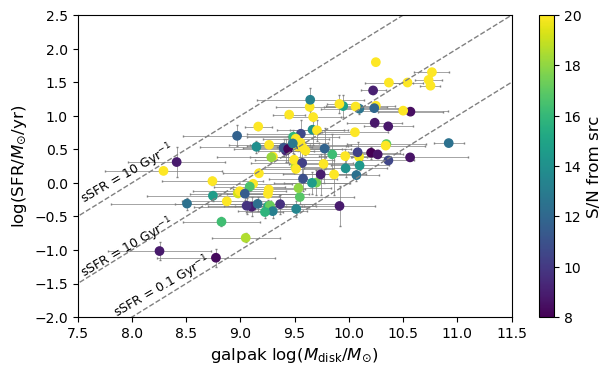

In [39]:
plt.figure(figsize = (7,4), dpi = 100)
#plt.errorbar(np.array(R_04_15_zconf1["log_Mdisk"]), np.array(R_04_15_zconf1["sed_logMass"]), \
#            xerr = np.array(R_04_15_zconf1["log_Mdisk_err"]), \
#            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5, alpha = 0.3)
plt.errorbar(np.array(T["log_Mdisk"]), np.array(np.log10(T["SFR_gilbank_mdisk"])), \
            xerr = np.array(T["log_Mdisk_err"]), \
             yerr = np.minimum(T["SFR_gilbank_mdisk_ERR"]/T["SFR_gilbank_mdisk"]/np.log(10),0.3),\
            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5, alpha = 1, capsize = 1)
#plt.vlines(R_04_15_zconf1["log_Mdisk"], R_04_15_zconf1["sed_logMass_l95"], \
#           R_04_15_zconf1["sed_logMass_u95"],color = "gray", zorder = 1, linewidth = 0.5, alpha = 0.3)
#plt.vlines(T["log_Mdisk"], T["sed_logMass_l95"], \
#          T["sed_logMass_u95"],color = "gray", zorder = 1, linewidth = 0.5, alpha = 0.3)
#plt.scatter(R_04_15_zconf1["log_Mdisk"], R_04_15_zconf1["sed_logMass"], c = "lightgray", \
#            zorder = 2, vmin = 0, vmax = 1, alpha = 0.3)
plt.scatter(T["log_Mdisk"], np.log10(T["SFR_gilbank_mdisk"]), c = np.abs(T["snr_from_src"]), zorder = 2, vmin =8 , vmax = 20)
cbar = plt.colorbar(label = "S/N from src")
cbar.set_label('S/N from src', fontsize=12)

logmm = np.linspace(7,12, 100)
plt.plot(logmm, np.log10(10*1e-9*10**logmm), "--", c = "gray", linewidth = 1)
plt.plot(logmm, np.log10(1*1e-9*10**logmm), "--", c = "gray", linewidth = 1)
plt.plot(logmm, np.log10(0.1*1e-9*10**logmm), "--", c = "gray", linewidth = 1)
plt.text(7.5, -0.3, 'sSFR = 10 Gyr$^{-1}$', fontsize = 9, color = 'black', rotation = 30)
plt.text(7.5, -1.4, 'sSFR = 10 Gyr$^{-1}$', fontsize = 9, color = 'black', rotation = 30)
plt.text(7.8, -2, 'sSFR = 0.1 Gyr$^{-1}$', fontsize = 9, color = 'black', rotation = 30)


#plt.plot([8,11], [8,11], c = 'r', linestyle = "--", zorder = 0)
plt.xlabel("galpak log($M_{\mathrm{disk}}/M_{\odot})$", size = 12)
plt.ylabel("log(SFR/$M_{\odot}$/yr)", size = 12)
plt.ylim((-2,2.5))
plt.xlim((7.5, 11.5))

(7.5, 11.5)

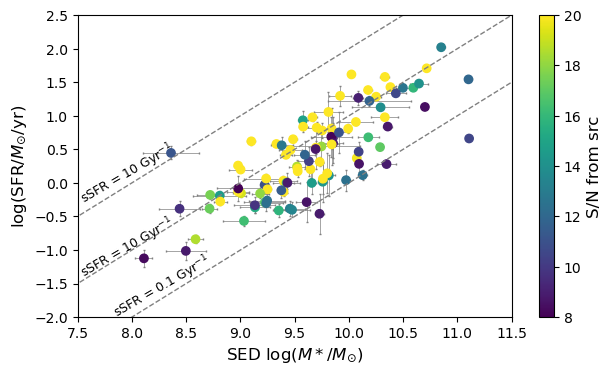

In [40]:
plt.figure(figsize = (7,4), dpi = 100)
#plt.errorbar(np.array(R_04_15_zconf1["log_Mdisk"]), np.array(R_04_15_zconf1["sed_logMass"]), \
#            xerr = np.array(R_04_15_zconf1["log_Mdisk_err"]), \
#            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5, alpha = 0.3)
plt.errorbar(np.array(T["sed_logMass"]), np.array(T["logSFR"]), \
            xerr = np.array(T["sed_logMass_ERR"]), \
             yerr = np.minimum(T["SFR_gilbank_ERR"]/T["SFR_gilbank"]/np.log(10),0.3),\
            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5, alpha = 1, capsize = 1)
#plt.vlines(R_04_15_zconf1["log_Mdisk"], R_04_15_zconf1["sed_logMass_l95"], \
#           R_04_15_zconf1["sed_logMass_u95"],color = "gray", zorder = 1, linewidth = 0.5, alpha = 0.3)
#plt.vlines(T["log_Mdisk"], T["sed_logMass_l95"], \
#          T["sed_logMass_u95"],color = "gray", zorder = 1, linewidth = 0.5, alpha = 0.3)
#plt.scatter(R_04_15_zconf1["log_Mdisk"], R_04_15_zconf1["sed_logMass"], c = "lightgray", \
#            zorder = 2, vmin = 0, vmax = 1, alpha = 0.3)
plt.scatter(T["sed_logMass"], T["logSFR"], c = np.abs(T["snr_from_src"]), zorder = 2, vmin =8 , vmax = 20)
cbar = plt.colorbar(label = "S/N from src")
cbar.set_label('S/N from src', fontsize=12)

logmm = np.linspace(7,12, 100)
plt.plot(logmm, np.log10(10*1e-9*10**logmm), "--", c = "gray", linewidth = 1)
plt.plot(logmm, np.log10(1*1e-9*10**logmm), "--", c = "gray", linewidth = 1)
plt.plot(logmm, np.log10(0.1*1e-9*10**logmm), "--", c = "gray", linewidth = 1)
plt.text(7.5, -0.3, 'sSFR = 10 Gyr$^{-1}$', fontsize = 9, color = 'black', rotation = 30)
plt.text(7.5, -1.4, 'sSFR = 10 Gyr$^{-1}$', fontsize = 9, color = 'black', rotation = 30)
plt.text(7.8, -2, 'sSFR = 0.1 Gyr$^{-1}$', fontsize = 9, color = 'black', rotation = 30)


#plt.plot([8,11], [8,11], c = 'r', linestyle = "--", zorder = 0)
plt.xlabel("SED log($M*/M_{\odot}$)", size = 12)
plt.ylabel("log(SFR/$M_{\odot}$/yr)", size = 12)
plt.ylim((-2,2.5))
plt.xlim((7.5, 11.5))

(6.5, 12.5)

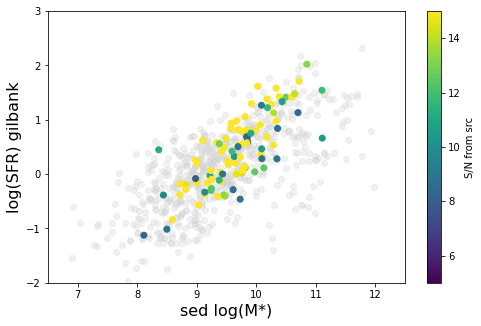

In [41]:
plt.figure(figsize = (8,5))
#plt.errorbar(np.array(R_04_15_zconf1["sed_logMass"]), np.array(R_04_15_zconf1["logSFR"]), \
#            xerr = np.array(R_04_15_zconf1["log_Mdisk_err"]),\
#            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5, alpha = 0.3)
#plt.vlines(R_04_15_zconf1["log_Mdisk"], R_04_15_zconf1["sed_logMass_l95"], \
#           R_04_15_zconf1["sed_logMass_u95"],color = "gray", zorder = 1, linewidth = 0.5, alpha = 0.3)
plt.scatter(R_04_15_zconf1["sed_logMass"], R_04_15_zconf1["logSFR"], c = "lightgray", \
            zorder = 2, vmin = 0, vmax = 1, alpha = 0.3)
plt.scatter(T["sed_logMass"], T["logSFR"], c = T["snr_from_src"], zorder = 2, vmin = 5, vmax = 15)
plt.colorbar(label = "S/N from src")
#plt.plot([8,11], [8,11], c = 'r', linestyle = "--", zorder = 0)
plt.xlabel("sed log(M*)", size = 16)
plt.ylabel("log(SFR) gilbank", size = 16)
plt.ylim((-2,3))
plt.xlim((6.5, 12.5))

### behroozi

Text(0, 0.5, 'SED log($M*/M_{\\odot}$)')

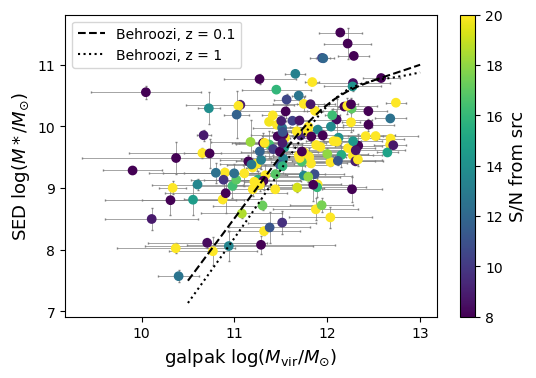

In [539]:
plt.figure(figsize = (6,4), dpi = 100)
#plt.errorbar(np.array(R_04_15_zconf1["log_Mdisk"]), np.array(R_04_15_zconf1["sed_logMass"]), \
#            xerr = np.array(R_04_15_zconf1["log_Mdisk_err"]), \
#            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5, alpha = 0.3)
plt.errorbar(np.array(T["log_Mvir"]), np.array(T["sed_logMass"]), \
            yerr = np.array(T["sed_logMass_ERR"]), xerr = np.array(T["log_Mvir_err"]), \
            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5, alpha = 1, capsize = 1)
#plt.vlines(R_04_15_zconf1["log_Mdisk"], R_04_15_zconf1["sed_logMass_l95"], \
#           R_04_15_zconf1["sed_logMass_u95"],color = "gray", zorder = 1, linewidth = 0.5, alpha = 0.3)
#plt.vlines(T["log_Mdisk"], T["sed_logMass_l95"], \
#          T["sed_logMass_u95"],color = "gray", zorder = 1, linewidth = 0.5, alpha = 0.3)
#plt.scatter(R_04_15_zconf1["log_Mdisk"], R_04_15_zconf1["sed_logMass"], c = "lightgray", \
#            zorder = 2, vmin = 0, vmax = 1, alpha = 0.3)
plt.scatter(T["log_Mvir"], T["sed_logMass"], c = np.abs(T["snr_from_src"]), zorder = 2, vmin =8 , vmax = 20)
cbar = plt.colorbar(label = "S/N from src")
cbar.set_label('S/N from src', fontsize=13)

logMh = np.linspace(10.5,13.,20)
logMstar_1 = gt.Behroozi_2019_inv(logMh, 1)
logMstar_01 = gt.Behroozi_2019_inv(logMh, 0.1)
plt.plot(logMh, logMstar_01, c = "black", linestyle = "--", label = "Behroozi, z = 0.1")
plt.plot(logMh, logMstar_1, c = "black", linestyle = "dotted", label = "Behroozi, z = 1")

plt.legend()
plt.xlabel("galpak log($M_{\mathrm{vir}}/M_{\odot})$", size = 13)
plt.ylabel("SED log($M*/M_{\odot}$)", size = 13)

Text(0, 0.5, 'galpak log($M_{\\mathrm{disk}}/M_{\\odot}$)')

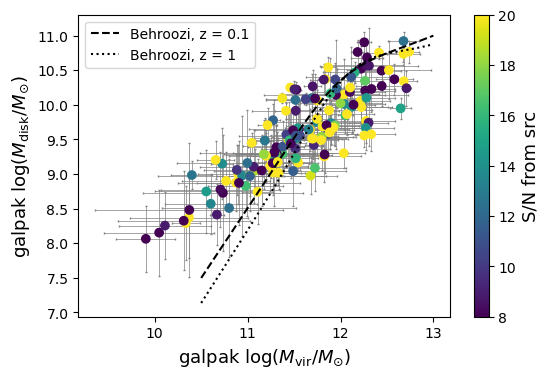

In [538]:
plt.figure(figsize = (6,4), dpi = 100)
#plt.errorbar(np.array(R_04_15_zconf1["log_Mdisk"]), np.array(R_04_15_zconf1["sed_logMass"]), \
#            xerr = np.array(R_04_15_zconf1["log_Mdisk_err"]), \
#            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5, alpha = 0.3)
plt.errorbar(np.array(T["log_Mvir"]), np.array(T["log_Mdisk"]), \
            yerr = np.array(T["log_Mdisk_err"]), xerr = np.array(T["log_Mvir_err"]), \
            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5, alpha = 1, capsize = 1)
#plt.vlines(R_04_15_zconf1["log_Mdisk"], R_04_15_zconf1["sed_logMass_l95"], \
#           R_04_15_zconf1["sed_logMass_u95"],color = "gray", zorder = 1, linewidth = 0.5, alpha = 0.3)
#plt.vlines(T["log_Mdisk"], T["sed_logMass_l95"], \
#          T["sed_logMass_u95"],color = "gray", zorder = 1, linewidth = 0.5, alpha = 0.3)
#plt.scatter(R_04_15_zconf1["log_Mdisk"], R_04_15_zconf1["sed_logMass"], c = "lightgray", \
#            zorder = 2, vmin = 0, vmax = 1, alpha = 0.3)
plt.scatter(T["log_Mvir"], T["log_Mdisk"], c = np.abs(T["snr_from_src"]), zorder = 2, vmin =8 , vmax = 20)
cbar = plt.colorbar(label = "S/N from src")
cbar.set_label('S/N from src', fontsize=13)

logMh = np.linspace(10.5,13.,20)
logMstar_1 = gt.Behroozi_2019_inv(logMh, 1)
logMstar_01 = gt.Behroozi_2019_inv(logMh, 0.1)
plt.plot(logMh, logMstar_01, c = "black", linestyle = "--", label = "Behroozi, z = 0.1")
plt.plot(logMh, logMstar_1, c = "black", linestyle = "dotted", label = "Behroozi, z = 1")

plt.legend()
plt.xlabel("galpak log($M_{\mathrm{vir}}/M_{\odot})$", size = 13)
plt.ylabel("galpak log($M_{\mathrm{disk}}/M_{\odot}$)", size = 13)

Text(0, 0.5, 'log(Mvir) galpak')

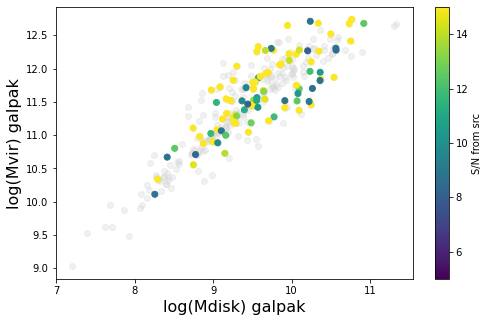

In [44]:
plt.figure(figsize = (8,5))
#plt.errorbar(np.array(R_04_15_zconf1["sed_logMass"]), np.array(R_04_15_zconf1["logSFR"]), \
#            xerr = np.array(R_04_15_zconf1["log_Mdisk_err"]),\
#            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5, alpha = 0.3)
#plt.vlines(R_04_15_zconf1["log_Mdisk"], R_04_15_zconf1["sed_logMass_l95"], \
#           R_04_15_zconf1["sed_logMass_u95"],color = "gray", zorder = 1, linewidth = 0.5, alpha = 0.3)
plt.scatter(R_04_15_zconf1["log_Mdisk"], R_04_15_zconf1["log_Mvir"], c = "lightgray", \
            zorder = 2, vmin = 0, vmax = 1, alpha = 0.3)
plt.scatter(T["log_Mdisk"], T["log_Mvir"], c = T["snr_from_src"], zorder = 2, vmin = 5, vmax = 15)
plt.colorbar(label = "S/N from src")
#plt.plot([8,11], [8,11], c = 'r', linestyle = "--", zorder = 0)
plt.xlabel("log(Mdisk) galpak", size = 16)
plt.ylabel("log(Mvir) galpak", size = 16)
#plt.ylim((-3,3))
#plt.xlim((6.5, 12.5))

Text(0, 0.5, 'inner slope')

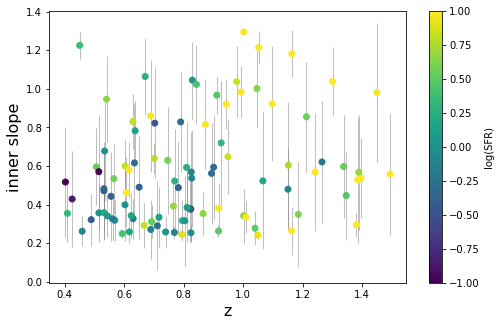

In [45]:
plt.figure(figsize = (8,5))
plt.errorbar(np.array(T["Z"]), np.array(T["gamma"]), \
            yerr = np.array(T["gamma_err"]), \
            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5)
plt.scatter(T["Z"], T["gamma"], c = T["logSFR"], zorder = 2, vmin = -1, vmax = 1)
plt.xlabel("z", size = 16)
plt.colorbar(label = "log(SFR)")
plt.ylabel("inner slope", size = 16)

Text(0, 0.5, 'logMvir')

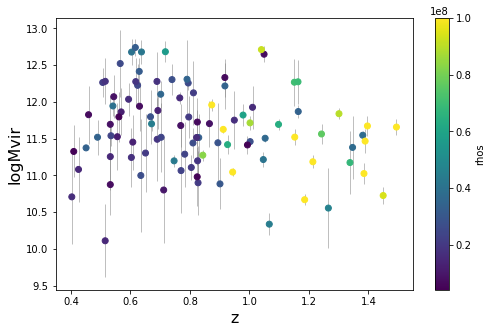

In [46]:
plt.figure(figsize = (8,5))
plt.errorbar(np.array(T["Z"]), np.array(T["log_Mvir"]), \
            yerr = np.array(T["log_Mvir_err"]), \
            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5)
plt.scatter(T["Z"], T["log_Mvir"], c = T["rhos"], zorder = 2, vmax = 1e8)
plt.xlabel("z", size = 16)
plt.colorbar(label = "rhos")
plt.ylabel("logMvir", size = 16)

Text(0, 0.5, 'rs [kpc]')

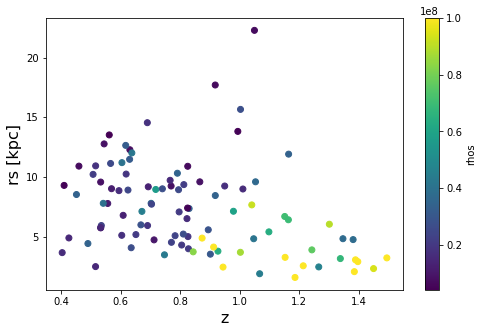

In [47]:
plt.figure(figsize = (8,5))
#plt.errorbar(np.array(T["Z"]), np.array(T["rs_kpc"]), \
#            yerr = np.array(T["log_Mvir_err"]), \
#            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5)
plt.scatter(T["Z"], T["rs_kpc"], c = T["rhos"], zorder = 2, vmax = 1e8)
plt.xlabel("z", size = 16)
plt.colorbar(label = "rhos")
plt.ylabel("rs [kpc]", size = 16)

Text(0, 0.5, 'log rhos')

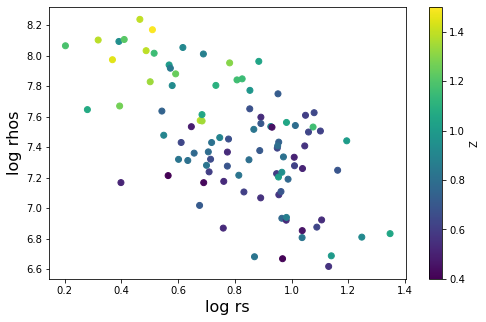

In [48]:
plt.figure(figsize = (8,5))
#plt.errorbar(np.array(T["Z"]), np.array(T["rs_kpc"]), \
#            yerr = np.array(T["log_Mvir_err"]), \
#            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5)
plt.scatter(np.log10(T["rs_kpc"]), np.log10(T["rhos"]) , c = T["Z"], zorder = 2, vmin = 0.4, vmax = 1.5)
plt.xlabel("log rs", size = 16)
plt.colorbar(label = "Z")
plt.ylabel("log rhos", size = 16)

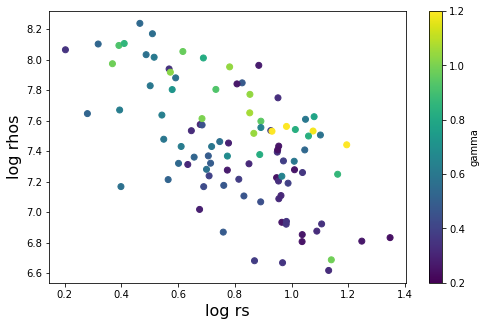

In [49]:
plt.figure(figsize = (8,5))
#plt.errorbar(np.array(T["Z"]), np.array(T["rs_kpc"]), \
#            yerr = np.array(T["log_Mvir_err"]), \
#            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5)
plt.scatter(np.log10(T["rs_kpc"]), np.log10(T["rhos"]) , c = T["gamma"], zorder = 2, vmin = 0.2, vmax = 1.2)
plt.xlabel("log rs", size = 16)
plt.ylabel("log rhos", size = 16)
plt.colorbar(label = "gamma")

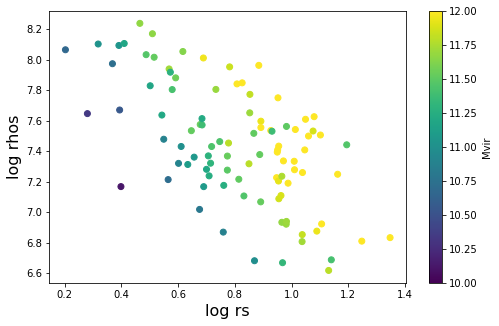

In [50]:
plt.figure(figsize = (8,5))
#plt.errorbar(np.array(T["Z"]), np.array(T["rs_kpc"]), \
#            yerr = np.array(T["log_Mvir_err"]), \
#            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5)
plt.scatter(np.log10(T["rs_kpc"]), np.log10(T["rhos"]) , c = T["log_Mvir"], zorder = 2, vmin = 10, vmax = 12)
plt.xlabel("log rs", size = 16)
plt.ylabel("log rhos", size = 16)
plt.colorbar(label = "Mvir")

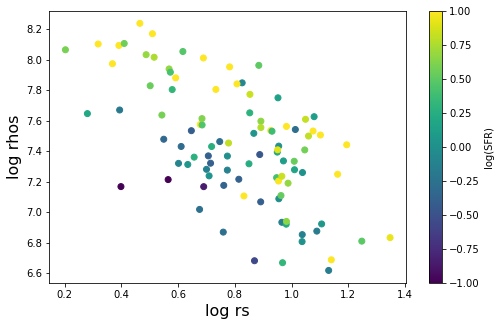

In [51]:
plt.figure(figsize = (8,5))
#plt.errorbar(np.array(T["Z"]), np.array(T["rs_kpc"]), \
#            yerr = np.array(T["log_Mvir_err"]), \
#            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5)
plt.scatter(np.log10(T["rs_kpc"]), np.log10(T["rhos"]) , c = np.log10(T["SFR_gilbank"]), zorder = 2,\
            vmin = -1, vmax = 1)
plt.xlabel("log rs", size = 16)
plt.ylabel("log rhos", size = 16)
plt.colorbar(label = "log(SFR)")

Text(0, 0.5, 'log Rvir')

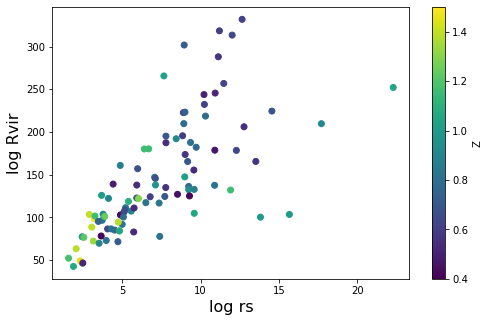

In [52]:
plt.figure(figsize = (8,5))
#plt.errorbar(np.array(T["Z"]), np.array(T["rs_kpc"]), \
#            yerr = np.array(T["log_Mvir_err"]), \
#            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5)
plt.scatter(T["rs_kpc"], T["Rvir"] , c = T["Z"], zorder = 2, vmin = 0.4, vmax = 1.5)
plt.xlabel("log rs", size = 16)
plt.colorbar(label = "Z")
plt.ylabel("log Rvir", size = 16)

Text(0, 0.5, 'concentration')

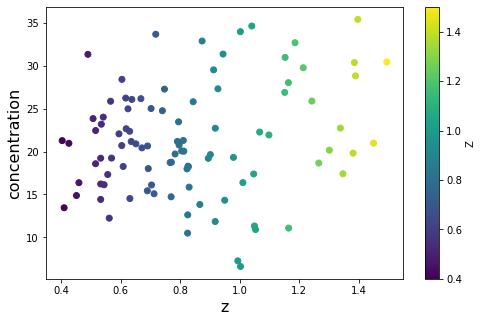

In [53]:
plt.figure(figsize = (8,5))
#plt.errorbar(np.array(T["Z"]), np.array(T["rs_kpc"]), \
#            yerr = np.array(T["log_Mvir_err"]), \
#            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5)
plt.scatter(T["Z"], T["Rvir"]/T["rs_kpc"], c = T["Z"], zorder = 2, vmin = 0.4, vmax = 1.5)
plt.xlabel("z", size = 16)
plt.colorbar(label = "Z")
plt.ylabel("concentration", size = 16)

Text(0, 0.5, 'concentration')

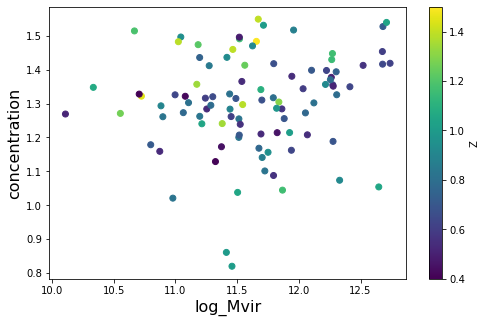

In [54]:
plt.figure(figsize = (8,5))
#plt.errorbar(np.array(T["Z"]), np.array(T["rs_kpc"]), \
#            yerr = np.array(T["log_Mvir_err"]), \
#            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5)
plt.scatter(T["log_Mvir"], np.log10(T["Rvir"]/T["rs_kpc"]), c = T["Z"], zorder = 2, vmin = 0.4, vmax = 1.5)
plt.xlabel("log_Mvir", size = 16)
plt.colorbar(label = "Z")
plt.ylabel("concentration", size = 16)

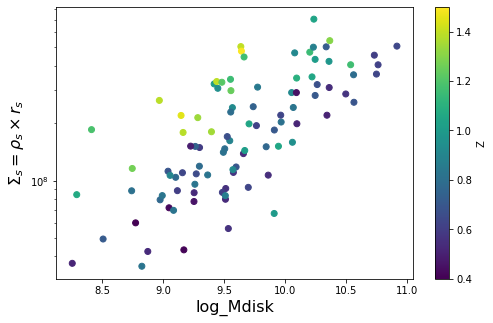

In [67]:
plt.figure(figsize = (8,5))
#plt.errorbar(T["log_Mdisk"], T["rhos"]*T["rs_kpc"], c = T["Z"], zorder = 2, vmin = 0.4, vmax = 1.5)
plt.scatter(T["log_Mdisk"], T["rhos"]*T["rs_kpc"], c = T["Z"], zorder = 2, vmin = 0.4, vmax = 1.5)
plt.xlabel("log_Mdisk", size = 16)
plt.colorbar(label = "Z")
plt.ylabel("$\Sigma_s = \\rho_s \\times r_s$", size = 16)
plt.yscale("log")

Text(0, 0.5, '$\\Sigma_s = \\rho_s \\times r_s$')

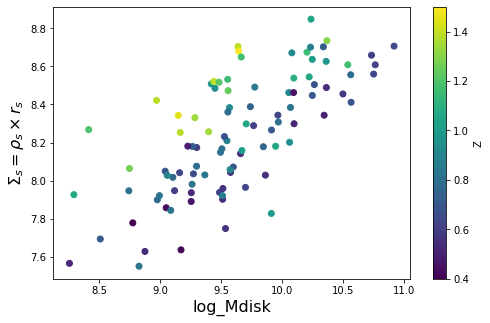

In [68]:
plt.figure(figsize = (8,5))
#plt.errorbar(T["log_Mdisk"], T["rhos"]*T["rs_kpc"], c = T["Z"], zorder = 2, vmin = 0.4, vmax = 1.5)
plt.scatter(T["log_Mdisk"], np.log10(T["rhos"]) + np.log10(T["rs_kpc"]), c = T["Z"], zorder = 2, vmin = 0.4, vmax = 1.5)
plt.xlabel("log_Mdisk", size = 16)
plt.colorbar(label = "Z")
plt.ylabel("$\Sigma_s = \\rho_s \\times r_s$", size = 16)
#plt.yscale("log")

# Comparison MgII, HI, DM

We would like to produce a plot similar to the one in the group paper. In which we compare the DM profile with the HI or MgII profile. Here we can derive more precisely the dark matter profile because we have the shape parameters $\alpha$, $\beta$, $\gamma$ as well as the virial mass and scale radius. 

**BUT** There is no analytical formula to compute the Surface density associated with a DC14 profile. So we have to compute it numerically by integrating the volume density along the line of sight at a given impact parameter.

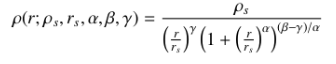
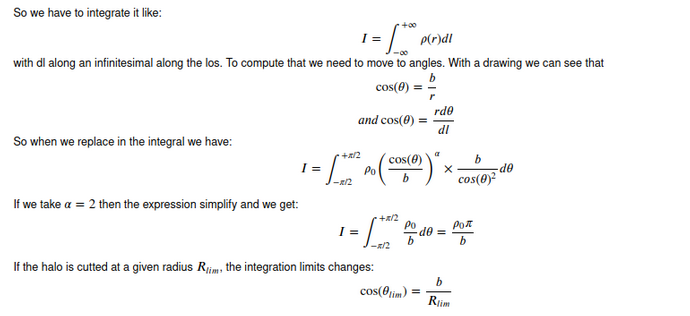

In [237]:
def DC14(r, rs, rhos, alpha = 1, beta = 3, gamma = 1):
    x = r/rs
    denominator = x**gamma*(1+x**(1/alpha))**(alpha*(beta - gamma))
    return rhos/(denominator)

In [238]:
def rho_integrand(theta, b, rhos, rs, alpha, beta, gamma):
    integrand = DC14(b/np.cos(theta), rs, rhos, alpha = alpha, beta = beta, gamma = gamma)*b/((np.cos(theta))**2)
    return integrand

In [240]:
def sigma_DM_Bartelmann(r, rhos, rs):
    x = r/rs
    Sigma = 2* rhos*rs*ff(x)/(x**2-1)
    return Sigma

def ff(x):
    if x> 1: return (1-2*np.arctan(((x-1)/(x+1))**0.5)/((x**2-1)**0.5))
    elif x<1: return (1-2*np.arctanh(((1-x)/(x+1))**0.5)/((1-x**2)**0.5))
    elif x == 1: return 0

In [249]:
b = np.linspace(10, 600, 100)
mvir = 1e12
z = 1
rvir = gt.get_Rvir(mvir, z).value
rho0, rs = gt.get_nfw_param(mvir, z)
rho0 = rho0.value
rs = rs.value

### Test with a NFW profile

For that we compare our numericla intergation with the analytical expression from Bartelmann 1996

/tmp/ipykernel_2336714/861741512.py:8: RuntimeWarning: invalid value encountered in arccos
  theta_lim = np.arccos(bb/rvir)
/tmp/ipykernel_2336714/861741512.py:9: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I2 = integrate.quad(rho_integrand, -theta_lim, theta_lim, args = (bb, rho0, rs, 1, 3, 1))


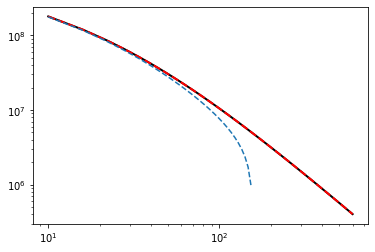

In [254]:
sig_dm = []
rho_column = []
rho_trunc = []
for bb in b:
    sig_dm.append(sigma_DM_Bartelmann(bb, rho0, rs))
    I = integrate.quad(rho_integrand, -np.pi/2, np.pi/2, args = (bb, rho0, rs, 1, 3, 1))
    rho_column.append(float(I[0]))
    theta_lim = np.arccos(bb/rvir)
    I2 = integrate.quad(rho_integrand, -theta_lim, theta_lim, args = (bb, rho0, rs, 1, 3, 1))
    rho_trunc.append(float(I2[0]))
sig_dm = np.array(sig_dm)
rho_column = np.array(rho_column)
rho_trunc = np.array(rho_trunc)

plt.loglog(b, sig_dm, c = "black", linewidth = 2) # Bartelmann
plt.loglog(b, rho_column, linestyle = "--", c = "r", linewidth = 2) # numerically integrated
plt.loglog(b, rho_trunc, linestyle = "--")

/tmp/ipykernel_2336714/3107705859.py:10: RuntimeWarning: invalid value encountered in arccos
  theta_lim = np.arccos(bb/rvir)
/tmp/ipykernel_2336714/3107705859.py:11: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I1 = integrate.quad(rho_integrand, -theta_lim, theta_lim, args = (bb, rho0, rs, 2.5, 2.5, 0))
/tmp/ipykernel_2336714/3107705859.py:14: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I2 = integrate.quad(rho_integrand, -theta_lim, theta_lim, args = (bb, rho0, rs, 1, 3, 1))


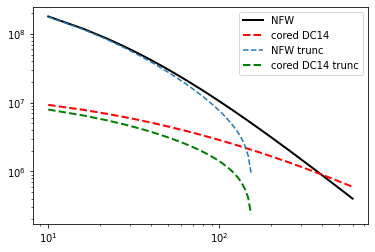

In [447]:
sig_dm = []
rho_cored = []
rho_cored_trunc = []
rho_nfw_trunc = []
for bb in b:
    sig_dm.append(sigma_DM_Bartelmann(bb, rho0, rs))
    I = integrate.quad(rho_integrand, -np.pi/2, np.pi/2, args = (bb, rho0, rs, 2.5, 2.5, 0))
    rho_cored.append(float(I[0]))
    
    theta_lim = np.arccos(bb/rvir)
    I1 = integrate.quad(rho_integrand, -theta_lim, theta_lim, args = (bb, rho0, rs, 2.5, 2.5, 0))
    rho_cored_trunc.append(float(I1[0]))
    
    I2 = integrate.quad(rho_integrand, -theta_lim, theta_lim, args = (bb, rho0, rs, 1, 3, 1))
    rho_nfw_trunc.append(float(I2[0]))
sig_dm = np.array(sig_dm)
rho_cored = np.array(rho_cored)
rho_nfw_trunc = np.array(rho_nfw_trunc)
rho_cored_trunc = np.array(rho_cored_trunc)

plt.loglog(b, sig_dm, c = "black", linewidth = 2, label = "NFW") # Bartelmann
plt.loglog(b, rho_cored, linestyle = "--", c = "r", linewidth = 2, label = "cored DC14") # numerically integrated
plt.loglog(b, rho_nfw_trunc, linestyle = "--", label = "NFW trunc")
plt.loglog(b, rho_cored_trunc, linestyle = "--", c = "g", linewidth = 2, label = "cored DC14 trunc") # numerically integrated
plt.legend()

### No we apply the code to our isolated galaxies

In [609]:
DM_surf_dens = []
DM_surf_dens_trunc = []

for i, r in isol_9.iterrows():
    r["beta"]
    #rhos is in Msun/kpc**3 we must convert it in kg/kpc
    I = integrate.quad(rho_integrand, -np.pi/2, np.pi/2, \
                       args = (r["B_KPC"], r["rhos"], r["rs_kpc"], 2, r["beta"], r["gamma"]))
    DM_surf_dens.append(float(I[0]))
    theta_lim = np.arccos(r["B_KPC"]/r["Rvir"])
    #theta_lim = np.arccos(r["B_KPC"]/100)

    I2 = integrate.quad(rho_integrand, -theta_lim, theta_lim, \
                        args = (r["B_KPC"], r["rhos"], r["rs_kpc"], 2, r["beta"], r["gamma"]))
    DM_surf_dens_trunc.append(float(I2[0]) +1e-8)
    
isol_9["DM_surf_dens"] = np.array(DM_surf_dens)
isol_9["DM_surf_dens_trunc"] = np.array(DM_surf_dens_trunc)
isol_9['DM_surf_dens_trunc'] = isol_9['DM_surf_dens_trunc'].fillna(10**(3.4))

/tmp/ipykernel_2336714/693285143.py:10: RuntimeWarning: invalid value encountered in arccos
  theta_lim = np.arccos(r["B_KPC"]/r["Rvir"])
/tmp/ipykernel_2336714/693285143.py:13: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I2 = integrate.quad(rho_integrand, -theta_lim, theta_lim, \
/tmp/ipykernel_2336714/693285143.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isol_9["DM_surf_dens"] = np.array(DM_surf_dens)
/tmp/ipykernel_2336714/693285143.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

(array([20.,  0.,  0.,  0.,  0.,  2., 12., 13., 16.,  9.]),
 array([3.4       , 3.82977094, 4.25954189, 4.68931283, 5.11908378,
        5.54885472, 5.97862566, 6.40839661, 6.83816755, 7.26793849,
        7.69770944]),
 <BarContainer object of 10 artists>)

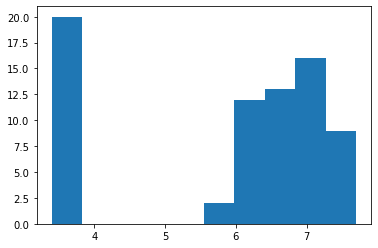

In [610]:
plt.hist(np.log10(isol_9['DM_surf_dens_trunc']))

In [611]:
isol_9["NHI"], isol_9["sigma_NHI"] = gt.Fukugita(isol_9["REW_2796"], isol_9["sig_REW_2796"], isol_9["Z"])
isol_9["NHI_limit"], _ = gt.Fukugita(isol_9["detection_limit_p75"], 0.05, isol_9["Z"])

/tmp/ipykernel_2336714/4066554378.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isol_9["NHI"], isol_9["sigma_NHI"] = gt.Fukugita(isol_9["REW_2796"], isol_9["sig_REW_2796"], isol_9["Z"])
/tmp/ipykernel_2336714/4066554378.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isol_9["NHI_limit"], _ = gt.Fukugita(isol_9["detection_limit_p75"], 0.05, isol_9["Z"])


In [1459]:
isol_9["Rvir_err"]

74      61.158767
94      29.653835
230     39.876137
294     11.327725
314     42.284130
          ...    
1923    23.455375
1930    17.045028
1994     3.972541
1998    11.951513
2019     9.379892
Name: Rvir_err, Length: 72, dtype: float64

In [1460]:
for i, r in isol_9.iterrows():
    print(r["Rvir"], r["Rvir_err"], r["rs_kpc"], r["rs_kpc_err"], r["snr_from_src"])

173.2338410339906 61.15876732193554 5.994749771289584 3.695104887323275 13.408802421854896
147.98438030745808 29.65383495896061 5.215174088852681 2.571689301834402 24.947127402730143
318.5152520965678 39.87613746291591 11.20377358886192 6.441102278205517 43.97187922276705
204.6166613575348 11.327724761758304 9.394288969513042 8.555232927328893 7.760298371743012
222.1345738630941 42.284129652046296 6.796572838842163 1.402527834242972 14.99980630319771
243.8204074638965 41.44347644697457 10.221185762286442 10.32578621465291 17.014814097309202
165.4692639287403 42.30863161593221 13.522622557095753 5.934277069126278 18.031041993273348
208.28880454792565 67.4954736750763 9.129905683898794 6.570602841761047 13.744103991761325
187.72477248299592 59.77752841244512 9.364410366442865 6.7938267450273 14.110530422144365
118.68255003271636 6.570990246705954 5.408454083443534 7.560964694901703 12.686645298096066
41.92439848075203 22.3385775260682 2.3049683653626194 1.96097732780929 44.01174822975493

In [612]:
kradius_15 = isol_9['radius']>1.5
ksnr_8 = isol_9['snr_from_src']>8
ksnr_5 = isol_9['snr_from_src']>5
kvrot_2 = (isol_9['v22']/isol_9['velocity_dispersion_2Rd']>2)
krs_3 = isol_9["rs_pixel"] > 3
kabs = isol_9["bool_absorption"] == True

sample_DM_profile = isol_9[ksnr_5 & kvrot_2]
sample_DM_profile_abs = isol_9[ksnr_5 & kvrot_2 & kabs]
sample_DM_profile_noabs = isol_9[ksnr_5 & kvrot_2 & ~kabs]

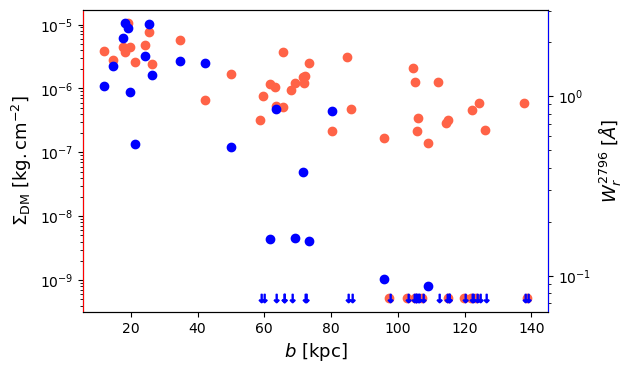

In [613]:
fig, ax1 = plt.subplots(figsize = (6,4))
fig.dpi = 100

to_kg_cm2 = (1*u.Msun/((u.kpc)**2)).to((u.kg)/(u.cm**2)).value
#plt.scatter(sample_DM_profile_abs["B_KPC"], sample_DM_profile_abs["DM_surf_dens"], c = "red")
#plt.scatter(sample_DM_profile_noabs["B_KPC"], sample_DM_profile_noabs["DM_surf_dens"], c = "red")
#plt.scatter(sample_DM_profile["B_KPC"], sample_DM_profile["DM_surf_dens_trunc"], c = "tomato")
plt.scatter(sample_DM_profile["B_KPC"], sample_DM_profile["DM_surf_dens_trunc"]*to_kg_cm2, c = "tomato")


plt.xlabel("$b$ [kpc]", size = 13)
plt.ylabel("$\Sigma_{\mathrm{DM}}$ $\mathrm{[kg.cm^{-2}]}$", size = 13)
#plt.xscale("log")
plt.yscale("log")
#plt.ylim((1e-10, 1e-3))

#--------------
ax2 = ax1.twinx()
ax2.scatter(sample_DM_profile_abs["B_KPC"], sample_DM_profile_abs["REW_2796"], c = "blue")
ax2.scatter(sample_DM_profile_noabs["B_KPC"], sample_DM_profile_noabs["detection_limit_p75"], \
            c = "blue", marker = "$\downarrow$")


#plt.ylabel("$\Sigma_{\mathrm{HI}}$ $\mathrm{[kg.cm^{-2}]}$", size = 13)
plt.ylabel("$W^{2796}_r$ [$\AA$]", size = 13)
ax2.spines['left'].set_color('red')
ax2.spines['right'].set_color('blue')
#plt.xscale("log")
plt.yscale("log")
#plt.ylim((1e-12, 1e-5))
#plt.xlim((0.07, 3))

(1e-10, 1e-06)

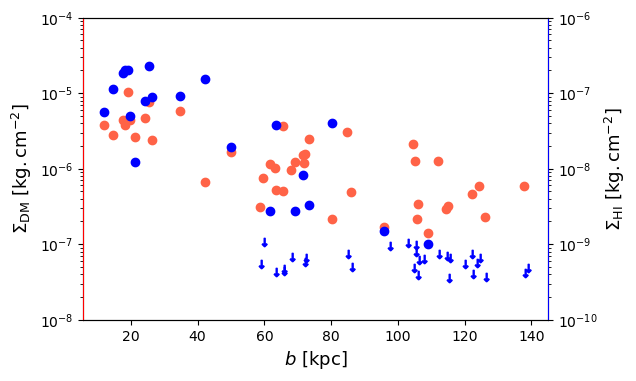

In [614]:
fig, ax1 = plt.subplots(figsize = (6,4))
fig.dpi = 100

limm = sample_DM_profile[sample_DM_profile["DM_surf_dens_trunc"] == 1e5]
ok = sample_DM_profile[sample_DM_profile["DM_surf_dens_trunc"] != 1e5]
#plt.scatter(sample_DM_profile_abs["B_KPC"], sample_DM_profile_abs["DM_surf_dens"], c = "red")
#plt.scatter(sample_DM_profile_noabs["B_KPC"], sample_DM_profile_noabs["DM_surf_dens"], c = "red")
#plt.scatter(sample_DM_profile["B_KPC"], sample_DM_profile["DM_surf_dens_trunc"]*to_kg_cm2, c = "tomato")
#plt.scatter(sample_DM_profile_noabs["B_KPC"], sample_DM_profile_noabs["DM_surf_dens_trunc"]*to_kg_cm2, c = "tomato")
plt.scatter(limm["B_KPC"], limm["DM_surf_dens_trunc"]*to_kg_cm2, c = "tomato", marker = "$\downarrow$")
plt.scatter(ok["B_KPC"], ok["DM_surf_dens_trunc"]*to_kg_cm2, c = "tomato")


plt.xlabel("$b$ [kpc]", size = 13)
plt.ylabel("$\Sigma_{\mathrm{DM}}$ $\mathrm{[kg.cm^{-2}]}$", size = 13)
#plt.xscale("log")
plt.yscale("log")
plt.ylim((1e-8, 1e-4))

#--------------
u_to_kg = 1.67355755e-27
ax2 = ax1.twinx()
ax2.scatter(sample_DM_profile_abs["B_KPC"], sample_DM_profile_abs["NHI"]*u_to_kg, c = "blue")
ax2.scatter(sample_DM_profile_noabs["B_KPC"], sample_DM_profile_noabs["NHI_limit"]*u_to_kg, \
            c = "blue", marker = "$\downarrow$")


#plt.ylabel("$\Sigma_{\mathrm{HI}}$ $\mathrm{[kg.cm^{-2}]}$", size = 13)
plt.ylabel("$\Sigma_{\mathrm{HI}}$ $\mathrm{[kg.cm^{-2}]}$", size = 13)
ax2.spines['left'].set_color('red')
ax2.spines['right'].set_color('blue')
#plt.xscale("log")
plt.yscale("log")
plt.ylim((1e-10, 1e-6))
#plt.xlim((0.07, 3))

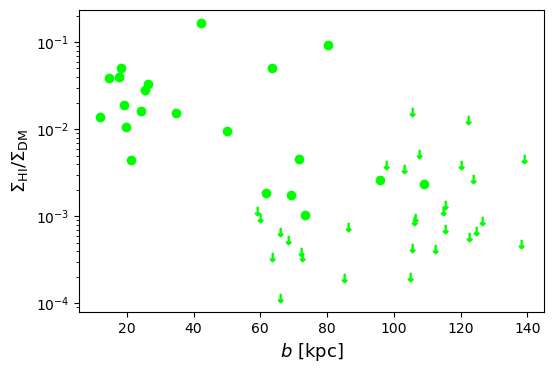

In [615]:
fig, ax1 = plt.subplots(figsize = (6,4))
fig.dpi = 100
u_to_kg = 1.67355755e-27
plt.scatter(sample_DM_profile_noabs["B_KPC"], \
            sample_DM_profile_noabs["NHI_limit"]*u_to_kg/ sample_DM_profile_noabs["DM_surf_dens"]/to_kg_cm2,\
            c = "lime", marker = "$\downarrow$")
plt.scatter(sample_DM_profile_abs["B_KPC"], \
            sample_DM_profile_abs["NHI"]*u_to_kg/sample_DM_profile_abs["DM_surf_dens"]/to_kg_cm2, c = "lime")


plt.xlabel("$b$ [kpc]", size = 13)
plt.ylabel("$\Sigma_{\mathrm{HI}}/\Sigma_{\mathrm{DM}}$", size = 13)
#plt.xscale("log")
plt.yscale("log")
#plt.ylim((1e-8, 1e-4))

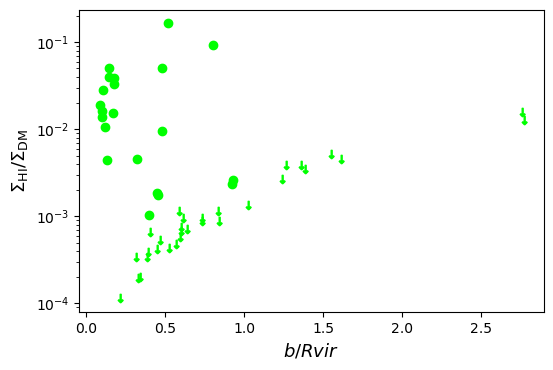

In [616]:
fig, ax1 = plt.subplots(figsize = (6,4))
fig.dpi = 100
u_to_kg = 1.67355755e-27
plt.scatter(sample_DM_profile_noabs["B_KPC"]/sample_DM_profile_noabs["Rvir"], \
            sample_DM_profile_noabs["NHI_limit"]*u_to_kg/ sample_DM_profile_noabs["DM_surf_dens"]/to_kg_cm2,\
            c = "lime", marker = "$\downarrow$")
plt.scatter(sample_DM_profile_abs["B_KPC"]/sample_DM_profile_abs["Rvir"], \
            sample_DM_profile_abs["NHI"]*u_to_kg/sample_DM_profile_abs["DM_surf_dens"]/to_kg_cm2, c = "lime")


plt.xlabel("$b/Rvir$", size = 13)
plt.ylabel("$\Sigma_{\mathrm{HI}}/\Sigma_{\mathrm{DM}}$", size = 13)
#plt.xscale("log")
plt.yscale("log")
#plt.ylim((1e-8, 1e-4))

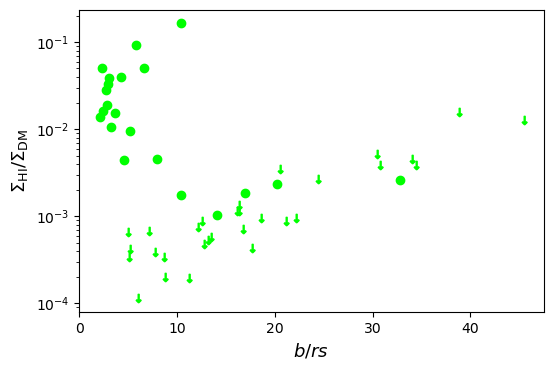

In [617]:
fig, ax1 = plt.subplots(figsize = (6,4))
fig.dpi = 100
u_to_kg = 1.67355755e-27
plt.scatter(sample_DM_profile_noabs["B_KPC"]/sample_DM_profile_noabs["rs_kpc"], \
            sample_DM_profile_noabs["NHI_limit"]*u_to_kg/ sample_DM_profile_noabs["DM_surf_dens"]/to_kg_cm2,\
            c = "lime", marker = "$\downarrow$")
plt.scatter(sample_DM_profile_abs["B_KPC"]/sample_DM_profile_abs["rs_kpc"], \
            sample_DM_profile_abs["NHI"]*u_to_kg/sample_DM_profile_abs["DM_surf_dens"]/to_kg_cm2, c = "lime")


plt.xlabel("$b/rs$", size = 13)
plt.ylabel("$\Sigma_{\mathrm{HI}}/\Sigma_{\mathrm{DM}}$", size = 13)
#plt.xscale("log")
plt.yscale("log")
#plt.ylim((1e-8, 1e-4))

(1e-10, 1e-06)

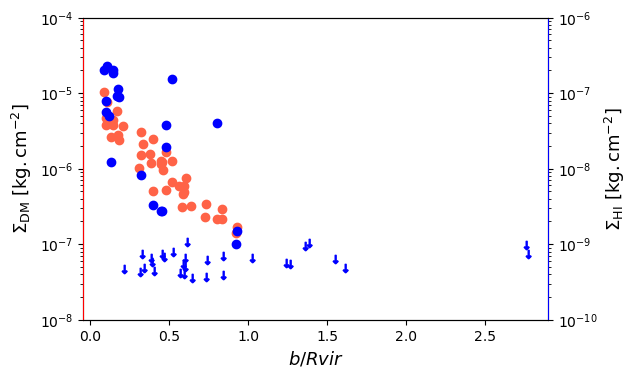

In [618]:
fig, ax1 = plt.subplots(figsize = (6,4))
fig.dpi = 100

limm = sample_DM_profile[sample_DM_profile["DM_surf_dens_trunc"] == 1e5]
ok = sample_DM_profile[sample_DM_profile["DM_surf_dens_trunc"] != 1e5]
#plt.scatter(sample_DM_profile_abs["B_KPC"], sample_DM_profile_abs["DM_surf_dens"], c = "red")
#plt.scatter(sample_DM_profile_noabs["B_KPC"], sample_DM_profile_noabs["DM_surf_dens"], c = "red")
#plt.scatter(sample_DM_profile["B_KPC"], sample_DM_profile["DM_surf_dens_trunc"]*to_kg_cm2, c = "tomato")
#plt.scatter(sample_DM_profile_noabs["B_KPC"], sample_DM_profile_noabs["DM_surf_dens_trunc"]*to_kg_cm2, c = "tomato")
plt.scatter(limm["B_KPC"]/limm["Rvir"], limm["DM_surf_dens_trunc"]*to_kg_cm2, c = "tomato", marker = "$\downarrow$")
plt.scatter(ok["B_KPC"]/ok["Rvir"], ok["DM_surf_dens_trunc"]*to_kg_cm2, c = "tomato")


plt.xlabel("$b/Rvir$", size = 13)
plt.ylabel("$\Sigma_{\mathrm{DM}}$ $\mathrm{[kg.cm^{-2}]}$", size = 13)
#plt.xscale("log")
plt.yscale("log")
plt.ylim((1e-8, 1e-4))

#--------------
u_to_kg = 1.67355755e-27
ax2 = ax1.twinx()
ax2.scatter(sample_DM_profile_abs["B_KPC"]/sample_DM_profile_abs["Rvir"], \
            sample_DM_profile_abs["NHI"]*u_to_kg, c = "blue")
ax2.scatter(sample_DM_profile_noabs["B_KPC"]/sample_DM_profile_noabs["Rvir"], \
            sample_DM_profile_noabs["NHI_limit"]*u_to_kg, \
            c = "blue", marker = "$\downarrow$")


#plt.ylabel("$\Sigma_{\mathrm{HI}}$ $\mathrm{[kg.cm^{-2}]}$", size = 13)
plt.ylabel("$\Sigma_{\mathrm{HI}}$ $\mathrm{[kg.cm^{-2}]}$", size = 13)
ax2.spines['left'].set_color('red')
ax2.spines['right'].set_color('blue')
#plt.xscale("log")
plt.yscale("log")
plt.ylim((1e-10, 1e-6))
#plt.xlim((0.07, 3))

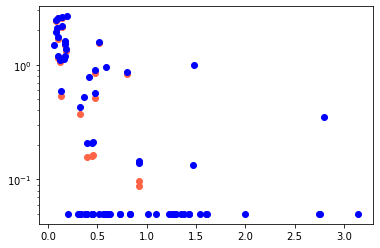

In [619]:
limm = sample_DM_profile[sample_DM_profile["DM_surf_dens_trunc"] == 1e5]
ok = sample_DM_profile[sample_DM_profile["DM_surf_dens_trunc"] != 1e5]
#plt.scatter(sample_DM_profile_abs["B_KPC"], sample_DM_profile_abs["DM_surf_dens"], c = "red")
#plt.scatter(sample_DM_profile_noabs["B_KPC"], sample_DM_profile_noabs["DM_surf_dens"], c = "red")
#plt.scatter(sample_DM_profile["B_KPC"], sample_DM_profile["DM_surf_dens_trunc"]*to_kg_cm2, c = "tomato")
#plt.scatter(sample_DM_profile_noabs["B_KPC"], sample_DM_profile_noabs["DM_surf_dens_trunc"]*to_kg_cm2, c = "tomato")
plt.scatter(limm["B_KPC"]/limm["Rvir"], limm["REW_2796"], c = "tomato", marker = "$\downarrow$")
plt.scatter(ok["B_KPC"]/ok["Rvir"], ok["REW_2796"], c = "tomato")
plt.scatter(isol_9["B_KPC"]/isol_9["Rvir"], isol_9["REW_2796"]+0.05, c = "blue")

#plt.xscale("log")
plt.yscale("log")

(1e-10, 1e-06)

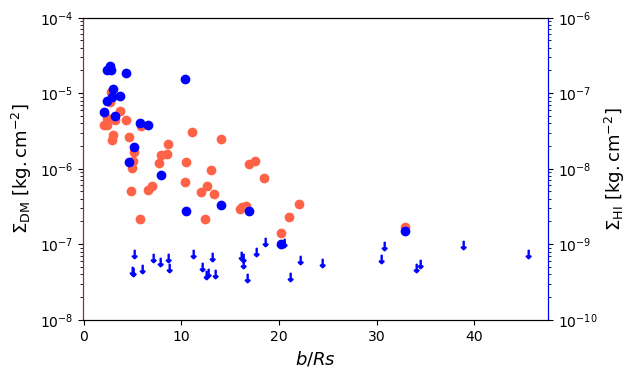

In [620]:
fig, ax1 = plt.subplots(figsize = (6,4))
fig.dpi = 100

limm = sample_DM_profile[sample_DM_profile["DM_surf_dens_trunc"] == 1e5]
ok = sample_DM_profile[sample_DM_profile["DM_surf_dens_trunc"] != 1e5]
#plt.scatter(sample_DM_profile_abs["B_KPC"], sample_DM_profile_abs["DM_surf_dens"], c = "red")
#plt.scatter(sample_DM_profile_noabs["B_KPC"], sample_DM_profile_noabs["DM_surf_dens"], c = "red")
#plt.scatter(sample_DM_profile["B_KPC"], sample_DM_profile["DM_surf_dens_trunc"]*to_kg_cm2, c = "tomato")
#plt.scatter(sample_DM_profile_noabs["B_KPC"], sample_DM_profile_noabs["DM_surf_dens_trunc"]*to_kg_cm2, c = "tomato")
plt.scatter(limm["B_KPC"]/limm["rs_kpc"], limm["DM_surf_dens_trunc"]*to_kg_cm2, c = "tomato", marker = "$\downarrow$")
plt.scatter(ok["B_KPC"]/ok["rs_kpc"], ok["DM_surf_dens_trunc"]*to_kg_cm2, c = "tomato")


plt.xlabel("$b/Rs$", size = 13)
plt.ylabel("$\Sigma_{\mathrm{DM}}$ $\mathrm{[kg.cm^{-2}]}$", size = 13)
#plt.xscale("log")
plt.yscale("log")
plt.ylim((1e-8, 1e-4))

#--------------
u_to_kg = 1.67355755e-27
ax2 = ax1.twinx()
ax2.scatter(sample_DM_profile_abs["B_KPC"]/sample_DM_profile_abs["rs_kpc"], \
            sample_DM_profile_abs["NHI"]*u_to_kg, c = "blue")
ax2.scatter(sample_DM_profile_noabs["B_KPC"]/sample_DM_profile_noabs["rs_kpc"], \
            sample_DM_profile_noabs["NHI_limit"]*u_to_kg, \
            c = "blue", marker = "$\downarrow$")


#plt.ylabel("$\Sigma_{\mathrm{HI}}$ $\mathrm{[kg.cm^{-2}]}$", size = 13)
plt.ylabel("$\Sigma_{\mathrm{HI}}$ $\mathrm{[kg.cm^{-2}]}$", size = 13)
ax2.spines['left'].set_color('red')
ax2.spines['right'].set_color('blue')
#plt.xscale("log")

plt.yscale("log")
plt.ylim((1e-10, 1e-6))
#plt.xlim((0.07, 3))

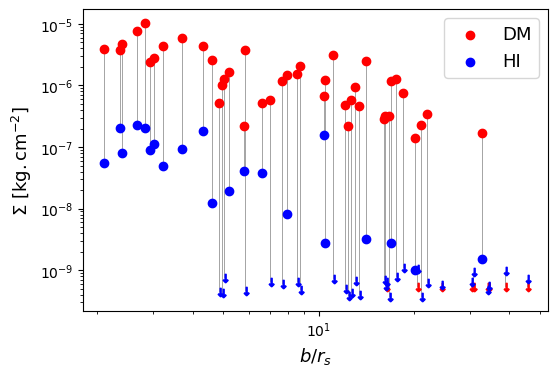

In [632]:
plt.figure(figsize = (6,4), dpi = 100)
limm = sample_DM_profile[sample_DM_profile["DM_surf_dens_trunc"] == 10**(3.4)]
ok = sample_DM_profile[sample_DM_profile["DM_surf_dens_trunc"] != 10**(3.4)]
plt.scatter(limm["B_KPC"]/limm["rs_kpc"], limm["DM_surf_dens_trunc"]*to_kg_cm2, c = "red", marker = "$\downarrow$")
plt.scatter(ok["B_KPC"]/ok["rs_kpc"], ok["DM_surf_dens_trunc"]*to_kg_cm2, c = "red", label = "DM")

plt.scatter(sample_DM_profile_abs["B_KPC"]/sample_DM_profile_abs["rs_kpc"], \
            sample_DM_profile_abs["NHI"]*u_to_kg, c = "blue", label = "HI")
plt.scatter(sample_DM_profile_noabs["B_KPC"]/sample_DM_profile_noabs["rs_kpc"], \
            sample_DM_profile_noabs["NHI_limit"]*u_to_kg, \
            c = "blue", marker = "$\downarrow$")

plt.vlines(sample_DM_profile["B_KPC"]/sample_DM_profile["rs_kpc"], \
           np.maximum(sample_DM_profile["NHI"], sample_DM_profile["NHI_limit"])*u_to_kg, \
           sample_DM_profile["DM_surf_dens_trunc"]*to_kg_cm2,\
          color = "gray", linewidth = 0.5, zorder =0)

plt.yscale("log")
plt.xscale("log")
plt.xlabel("$b/r_s$", size = 13)
plt.ylabel("$\Sigma$ $\mathrm{[kg.cm^{-2}]}$", size = 13)
plt.legend(fontsize = 13)

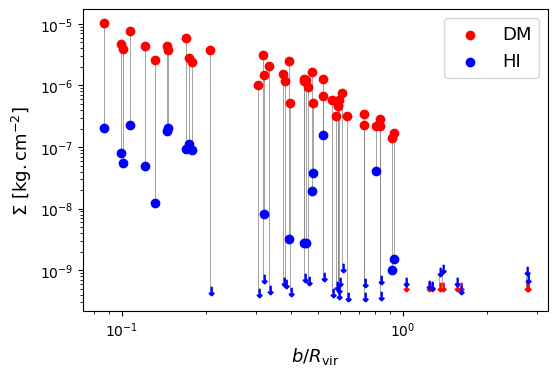

In [633]:
plt.figure(figsize = (6,4), dpi = 100)
limm = sample_DM_profile[sample_DM_profile["DM_surf_dens_trunc"] == 10**(3.4)]
ok = sample_DM_profile[sample_DM_profile["DM_surf_dens_trunc"] != 10**(3.4)]
plt.scatter(limm["B_KPC"]/limm["Rvir"], limm["DM_surf_dens_trunc"]*to_kg_cm2, c = "red", marker = "$\downarrow$")
plt.scatter(ok["B_KPC"]/ok["Rvir"], ok["DM_surf_dens_trunc"]*to_kg_cm2, c = "red", label = "DM")

plt.scatter(sample_DM_profile_abs["B_KPC"]/sample_DM_profile_abs["Rvir"], \
            sample_DM_profile_abs["NHI"]*u_to_kg, c = "blue", label = "HI")
plt.scatter(sample_DM_profile_noabs["B_KPC"]/sample_DM_profile_noabs["Rvir"], \
            sample_DM_profile_noabs["NHI_limit"]*u_to_kg, \
            c = "blue", marker = "$\downarrow$")

plt.vlines(sample_DM_profile["B_KPC"]/sample_DM_profile["Rvir"], \
           np.maximum(sample_DM_profile["NHI"], sample_DM_profile["NHI_limit"])*u_to_kg, \
           sample_DM_profile["DM_surf_dens_trunc"]*to_kg_cm2,\
          color = "gray", linewidth = 0.5, zorder =0)

plt.yscale("log")
plt.xscale("log")
plt.xlabel("$b/R_{\mathrm{vir}}$", size = 13)
plt.ylabel("$\Sigma$ $\mathrm{[kg.cm^{-2}]}$", size = 13)
plt.legend(fontsize = 13)

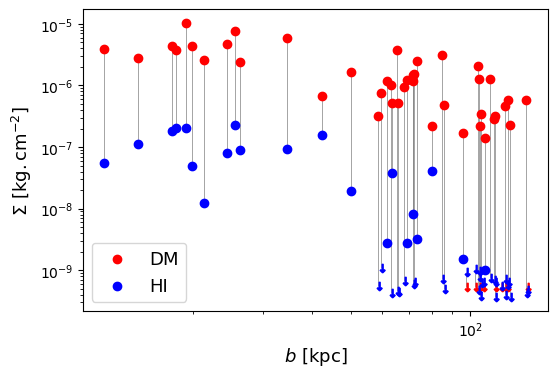

In [634]:
plt.figure(figsize = (6,4), dpi = 100)
limm = sample_DM_profile[sample_DM_profile["DM_surf_dens_trunc"] == 10**(3.4)]
ok = sample_DM_profile[sample_DM_profile["DM_surf_dens_trunc"] != 10**(3.4)]
plt.scatter(limm["B_KPC"], limm["DM_surf_dens_trunc"]*to_kg_cm2, c = "red", marker = "$\downarrow$")
plt.scatter(ok["B_KPC"], ok["DM_surf_dens_trunc"]*to_kg_cm2, c = "red", label = "DM")

plt.scatter(sample_DM_profile_abs["B_KPC"], \
            sample_DM_profile_abs["NHI"]*u_to_kg, c = "blue", label = "HI")
plt.scatter(sample_DM_profile_noabs["B_KPC"], \
            sample_DM_profile_noabs["NHI_limit"]*u_to_kg, \
            c = "blue", marker = "$\downarrow$")

plt.vlines(sample_DM_profile["B_KPC"], \
           np.maximum(sample_DM_profile["NHI"], sample_DM_profile["NHI_limit"])*u_to_kg, \
           sample_DM_profile["DM_surf_dens_trunc"]*to_kg_cm2,\
          color = "gray", linewidth = 0.5, zorder =0)

plt.yscale("log")
plt.xscale("log")
plt.xlabel("$b$ [kpc]", size = 13)
plt.ylabel("$\Sigma$ $\mathrm{[kg.cm^{-2}]}$", size = 13)
plt.legend(fontsize = 13)

(1e-10, 1e-06)

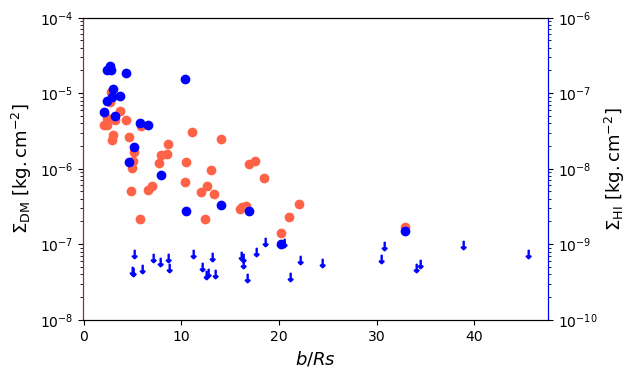

In [624]:
fig, ax1 = plt.subplots(figsize = (6,4))
fig.dpi = 100

limm = sample_DM_profile[sample_DM_profile["DM_surf_dens_trunc"] == 1e5]
ok = sample_DM_profile[sample_DM_profile["DM_surf_dens_trunc"] != 1e5]
plt.scatter(limm["B_KPC"]/limm["rs_kpc"], limm["DM_surf_dens_trunc"]*to_kg_cm2, c = "tomato", marker = "$\downarrow$")
plt.scatter(ok["B_KPC"]/ok["rs_kpc"], ok["DM_surf_dens_trunc"]*to_kg_cm2, c = "tomato")


plt.xlabel("$b/Rs$", size = 13)
plt.ylabel("$\Sigma_{\mathrm{DM}}$ $\mathrm{[kg.cm^{-2}]}$", size = 13)
#plt.xscale("log")
plt.yscale("log")
plt.ylim((1e-8, 1e-4))

#--------------
u_to_kg = 1.67355755e-27
ax2 = ax1.twinx()
ax2.scatter(sample_DM_profile_abs["B_KPC"]/sample_DM_profile_abs["rs_kpc"], \
            sample_DM_profile_abs["NHI"]*u_to_kg, c = "blue")
ax2.scatter(sample_DM_profile_noabs["B_KPC"]/sample_DM_profile_noabs["rs_kpc"], \
            sample_DM_profile_noabs["NHI_limit"]*u_to_kg, \
            c = "blue", marker = "$\downarrow$")


#plt.ylabel("$\Sigma_{\mathrm{HI}}$ $\mathrm{[kg.cm^{-2}]}$", size = 13)
plt.ylabel("$\Sigma_{\mathrm{HI}}$ $\mathrm{[kg.cm^{-2}]}$", size = 13)
ax2.spines['left'].set_color('red')
ax2.spines['right'].set_color('blue')
#plt.xscale("log")

plt.yscale("log")
plt.ylim((1e-10, 1e-6))
#plt.xlim((0.07, 3))

In [1757]:
bad_coverage_ID = [21111, 22047, 26095, 27094, 30060, 30070]
bad_coverage = isol_visu_high_alpha[isol_visu_high_alpha["ID"].isin(bad_coverage_ID)]

Text(0, 0.5, '$W^{2796}_{\\mathrm{r}}$ [$\\AA$]')

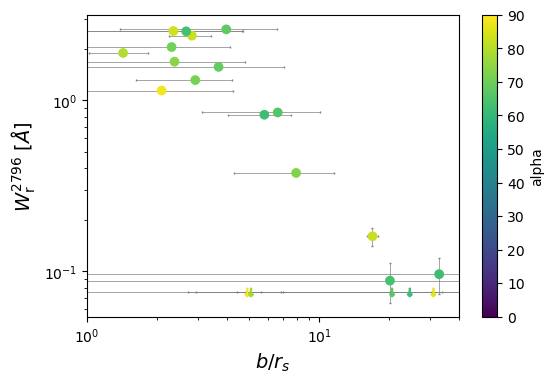

In [1760]:
plt.figure(figsize = (6,4), dpi = 100)
plt.errorbar(np.array(isol_visu_high_alpha["B_KPC"]/isol_visu_high_alpha["rs_kpc"]), \
             np.array(np.maximum(isol_visu_high_alpha["REW_2796"], 0.075)),\
            xerr = np.array(isol_visu_high_alpha["rs_kpc_err"]*isol_visu_high_alpha["B_KPC"]/(isol_visu_high_alpha["rs_kpc"]**2)),\
            yerr = np.array(isol_visu_high_alpha["sig_REW_2796"]), \
             linestyle = "none", color = "gray", linewidth = 0.5, capsize = 1);
plt.scatter(np.array(isol_visu_high_alpha_abs["B_KPC"]/isol_visu_high_alpha_abs["rs_kpc"]), \
            np.array(isol_visu_high_alpha_abs["REW_2796"]), \
            c = isol_visu_high_alpha_abs["alpha"], zorder = 3, vmin = 0., vmax = 90);
plt.colorbar(label = "alpha")
#plt.scatter(np.array(inner_slope["B_KPC"]/inner_slope["rs_kpc"]), np.array(inner_slope["REW_2796"]), \
#            c = "lime", zorder = 3);
plt.scatter(np.array(isol_visu_high_alpha_noabs["B_KPC"]/isol_visu_high_alpha_noabs["rs_kpc"]), \
            np.array(isol_visu_high_alpha_noabs["detection_limit_p75"]), \
            c = isol_visu_high_alpha_noabs["alpha"], zorder = 3, vmin = 0, vmax = 90, marker = "$\downarrow$");
plt.scatter(np.array(bad_coverage["B_KPC"]/bad_coverage["rs_kpc"]), \
            np.array(bad_coverage["REW_2796"]), zorder = 3, c = "r");
plt.xlim((1,40))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$b/r_s$", size = 14)
plt.ylabel("$W^{2796}_{\mathrm{r}}$ [$\AA$]", size= 14)

Text(0, 0.5, '$W^{2796}_{\\mathrm{r}}$ [$\\AA$]')

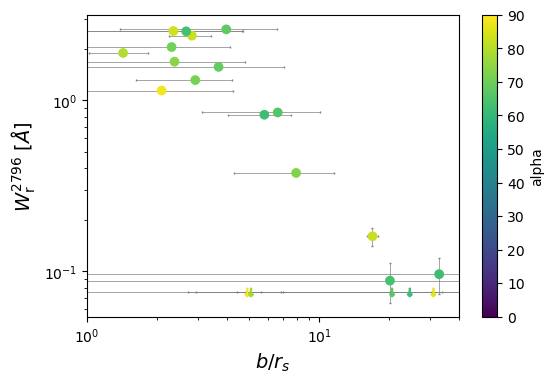

In [1519]:
plt.figure(figsize = (6,4), dpi = 100)
plt.errorbar(np.array(isol_visu_high_alpha["B_KPC"]/isol_visu_high_alpha["rs_kpc"]), \
             np.array(np.maximum(isol_visu_high_alpha["REW_2796"], 0.075)),\
            xerr = np.array(isol_visu_high_alpha["rs_kpc_err"]*isol_visu_high_alpha["B_KPC"]/(isol_visu_high_alpha["rs_kpc"]**2)),\
            yerr = np.array(isol_visu_high_alpha["sig_REW_2796"]), \
             linestyle = "none", color = "gray", linewidth = 0.5, capsize = 1);
plt.scatter(np.array(isol_visu_high_alpha_abs["B_KPC"]/isol_visu_high_alpha_abs["rs_kpc"]), \
            np.array(isol_visu_high_alpha_abs["REW_2796"]), \
            c = isol_visu_high_alpha_abs["alpha"], zorder = 3, vmin = 0., vmax = 90);
plt.colorbar(label = "alpha")
#plt.scatter(np.array(inner_slope["B_KPC"]/inner_slope["rs_kpc"]), np.array(inner_slope["REW_2796"]), \
#            c = "lime", zorder = 3);
plt.scatter(np.array(isol_visu_high_alpha_noabs["B_KPC"]/isol_visu_high_alpha_noabs["rs_kpc"]), \
            np.array(isol_visu_high_alpha_noabs["detection_limit_p75"]), \
            c = isol_visu_high_alpha_noabs["alpha"], zorder = 3, vmin = 0, vmax = 90, marker = "$\downarrow$");
plt.xlim((1,40))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$b/r_s$", size = 14)
plt.ylabel("$W^{2796}_{\mathrm{r}}$ [$\AA$]", size= 14)

In [1791]:
#f_rs_err = isol_visu_high_alpha["B_KPC"]*isol_visu_high_alpha["rs_kpc_err"]/(isol_visu_high_alpha["rs_kpc"]**2)<15
f_rs_err = isol_visu_high_alpha["rs_kpc_err"]/(isol_visu_high_alpha["rs_kpc"])<1
isol_rs = isol_visu_high_alpha[f_rs_err]
isol_rs_abs = isol_rs[isol_rs["bool_absorption"] == 1]
isol_rs_noabs = isol_rs[isol_rs["bool_absorption"] == 0]

Text(0, 0.5, '$W^{2796}_{\\mathrm{r}}$ [$\\AA$]')

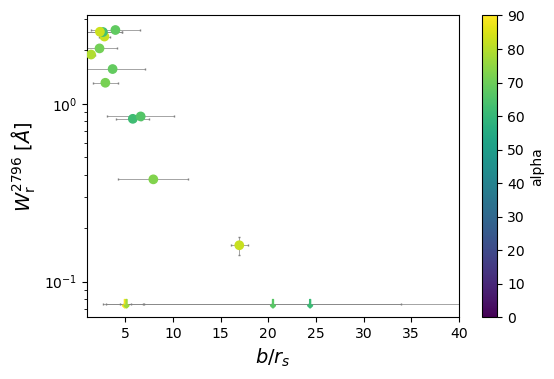

In [1659]:
plt.figure(figsize = (6,4), dpi = 100)
plt.errorbar(np.array(isol_rs["B_KPC"]/isol_rs["rs_kpc"]), \
             np.array(np.maximum(isol_rs["REW_2796"], 0.075)),\
            xerr = np.array(isol_rs["rs_kpc_err"]*isol_rs["B_KPC"]/(isol_rs["rs_kpc"]**2)),\
            yerr = np.array(isol_rs["sig_REW_2796"]), \
             linestyle = "none", color = "gray", linewidth = 0.5, capsize = 1);
plt.scatter(np.array(isol_rs_abs["B_KPC"]/isol_rs_abs["rs_kpc"]), \
            np.array(isol_rs_abs["REW_2796"]), \
            c = isol_rs_abs["alpha"], zorder = 3, vmin = 0., vmax = 90);
plt.colorbar(label = "alpha")
#plt.scatter(np.array(inner_slope["B_KPC"]/inner_slope["rs_kpc"]), np.array(inner_slope["REW_2796"]), \
#            c = "lime", zorder = 3);
plt.scatter(np.array(isol_rs_noabs["B_KPC"]/isol_rs_noabs["rs_kpc"]), \
            np.array(isol_rs_noabs["detection_limit_p75"]), \
            c = isol_rs_noabs["alpha"], zorder = 3, vmin = 0, vmax = 90, marker = "$\downarrow$");
plt.xlim((1,40))
#plt.xscale("log")
plt.yscale("log")
plt.xlabel("$b/r_s$", size = 14)
plt.ylabel("$W^{2796}_{\mathrm{r}}$ [$\AA$]", size= 14)

Text(0, 0.5, '$W^{2796}_{\\mathrm{r}}$ [$\\AA$]')

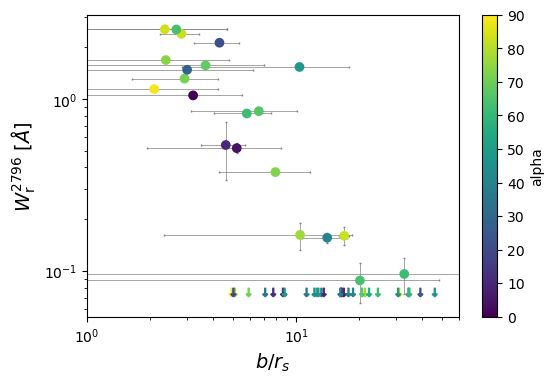

In [542]:
plt.figure(figsize = (6,4), dpi = 100)
plt.errorbar(np.array(sample_DM_profile["B_KPC"]/sample_DM_profile["rs_kpc"]), np.array(sample_DM_profile["REW_2796"]),\
            xerr = np.array(sample_DM_profile["rs_kpc_err"]*sample_DM_profile["B_KPC"]/(sample_DM_profile["rs_kpc"]**2)),\
            yerr = np.array(sample_DM_profile["sig_REW_2796"]), \
             linestyle = "none", color = "gray", linewidth = 0.5, capsize = 1);
plt.scatter(np.array(sample_DM_profile_abs["B_KPC"]/sample_DM_profile_abs["rs_kpc"]), \
            np.array(sample_DM_profile_abs["REW_2796"]), \
            c = sample_DM_profile_abs["alpha"], zorder = 3, vmin = 0., vmax = 90);
plt.colorbar(label = "alpha")
#plt.scatter(np.array(inner_slope["B_KPC"]/inner_slope["rs_kpc"]), np.array(inner_slope["REW_2796"]), \
#            c = "lime", zorder = 3);
plt.scatter(np.array(sample_DM_profile_noabs["B_KPC"]/sample_DM_profile_noabs["rs_kpc"]), \
            np.array(sample_DM_profile_noabs["detection_limit_p75"]), \
            c = sample_DM_profile_noabs["alpha"], zorder = 3, vmin = 0, vmax = 90, marker = "$\downarrow$");
plt.xlim((1,60))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$b/r_s$", size = 14)
plt.ylabel("$W^{2796}_{\mathrm{r}}$ [$\AA$]", size= 14)

Text(0, 0.5, '$W^{2796}_{\\mathrm{r}}$ [$\\AA$]')

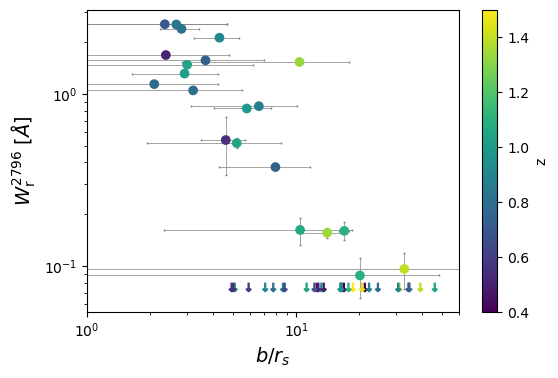

In [1032]:
plt.figure(figsize = (6,4), dpi = 100)
plt.errorbar(np.array(sample_DM_profile["B_KPC"]/sample_DM_profile["rs_kpc"]), np.array(sample_DM_profile["REW_2796"]),\
            xerr = np.array(sample_DM_profile["rs_kpc_err"]*sample_DM_profile["B_KPC"]/(sample_DM_profile["rs_kpc"]**2)),\
            yerr = np.array(sample_DM_profile["sig_REW_2796"]), \
             linestyle = "none", color = "gray", linewidth = 0.5, capsize = 1);
plt.scatter(np.array(sample_DM_profile_abs["B_KPC"]/sample_DM_profile_abs["rs_kpc"]), \
            np.array(sample_DM_profile_abs["REW_2796"]), \
            c = sample_DM_profile_abs["Z"], zorder = 3, vmin = 0.4, vmax = 1.5);
plt.colorbar(label = "z")
#plt.scatter(np.array(inner_slope["B_KPC"]/inner_slope["rs_kpc"]), np.array(inner_slope["REW_2796"]), \
#            c = "lime", zorder = 3);
plt.scatter(np.array(sample_DM_profile_noabs["B_KPC"]/sample_DM_profile_noabs["rs_kpc"]), \
            np.array(sample_DM_profile_noabs["detection_limit_p75"]), \
            c = sample_DM_profile_noabs["Z"], zorder = 3, vmin = 0.4, vmax = 1.5, marker = "$\downarrow$");
plt.xlim((1,60))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$b/r_s$", size = 14)
plt.ylabel("$W^{2796}_{\mathrm{r}}$ [$\AA$]", size= 14)

Text(0, 0.5, '$W^{2796}_{\\mathrm{r}}$ [$\\AA$]')

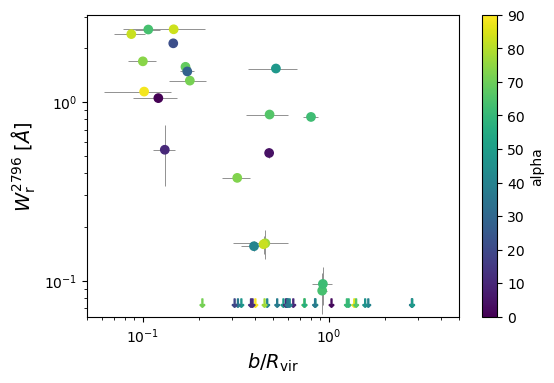

In [544]:
plt.figure(figsize = (6,4), dpi = 100)
plt.errorbar(np.array(sample_DM_profile["B_KPC"]/sample_DM_profile["Rvir"]), np.array(sample_DM_profile["REW_2796"]),\
            xerr = np.array(sample_DM_profile["Rvir_err"]*sample_DM_profile["B_KPC"]/(sample_DM_profile["Rvir"]**2)),\
            yerr = np.array(sample_DM_profile["sig_REW_2796"]), \
             linestyle = "none", color = "gray", linewidth = 0.6);
plt.scatter(np.array(sample_DM_profile_abs["B_KPC"]/sample_DM_profile_abs["Rvir"]), \
            np.array(sample_DM_profile_abs["REW_2796"]), \
            c = sample_DM_profile_abs["alpha"], zorder = 3, vmin = 0., vmax = 90);
plt.colorbar(label = "alpha")
#plt.scatter(np.array(inner_slope["B_KPC"]/inner_slope["rs_kpc"]), np.array(inner_slope["REW_2796"]), \
#            c = "lime", zorder = 3);
plt.scatter(np.array(sample_DM_profile_noabs["B_KPC"]/sample_DM_profile_noabs["Rvir"]), \
            np.array(sample_DM_profile_noabs["detection_limit_p75"]), \
            c = sample_DM_profile_noabs["alpha"], zorder = 3, vmin = 0., vmax = 90, marker = "$\downarrow$");
plt.xlim((0.05,5))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$b/R_{\mathrm{vir}}$", size = 14)
plt.ylabel("$W^{2796}_{\mathrm{r}}$ [$\AA$]", size= 14)

Text(0, 0.5, '$W^{2796}_{\\mathrm{r}}$ [$\\AA$]')

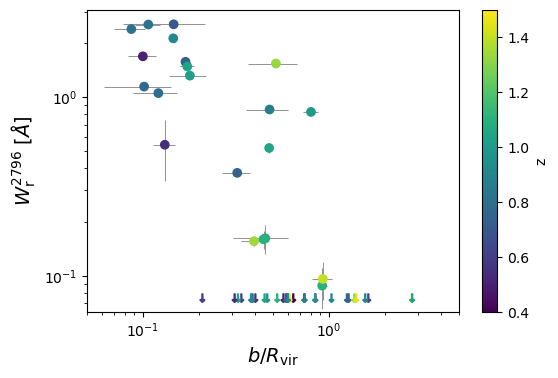

In [553]:
plt.figure(figsize = (6,4), dpi = 100)
plt.errorbar(np.array(sample_DM_profile["B_KPC"]/sample_DM_profile["Rvir"]), np.array(sample_DM_profile["REW_2796"]),\
            xerr = np.array(sample_DM_profile["Rvir_err"]*sample_DM_profile["B_KPC"]/(sample_DM_profile["Rvir"]**2)),\
            yerr = np.array(sample_DM_profile["sig_REW_2796"]), \
             linestyle = "none", color = "gray", linewidth = 0.6);
plt.scatter(np.array(sample_DM_profile_abs["B_KPC"]/sample_DM_profile_abs["Rvir"]), \
            np.array(sample_DM_profile_abs["REW_2796"]), \
            c = sample_DM_profile_abs["Z"], zorder = 3, vmin = 0.4, vmax = 1.5);
plt.colorbar(label = "z")
#plt.scatter(np.array(inner_slope["B_KPC"]/inner_slope["rs_kpc"]), np.array(inner_slope["REW_2796"]), \
#            c = "lime", zorder = 3);
plt.scatter(np.array(sample_DM_profile_noabs["B_KPC"]/sample_DM_profile_noabs["Rvir"]), \
            np.array(sample_DM_profile_noabs["detection_limit_p75"]), \
            c = sample_DM_profile_noabs["Z"], zorder = 3, vmin = 0.4, vmax = 1.5, marker = "$\downarrow$");
plt.xlim((0.05,5))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$b/R_{\mathrm{vir}}$", size = 14)
plt.ylabel("$W^{2796}_{\mathrm{r}}$ [$\AA$]", size= 14)

Text(0, 0.5, '$W^{2796}_{\\mathrm{r}}$ [$\\AA$]')

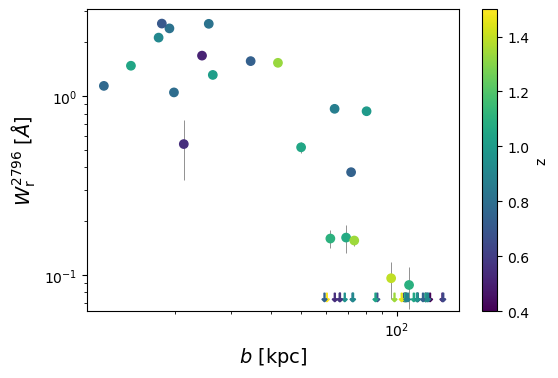

In [555]:
plt.figure(figsize = (6,4), dpi = 100)
plt.errorbar(np.array(sample_DM_profile["B_KPC"]), np.array(sample_DM_profile["REW_2796"]),\
            yerr = np.array(sample_DM_profile["sig_REW_2796"]), \
             linestyle = "none", color = "gray", linewidth = 0.6);
plt.scatter(np.array(sample_DM_profile_abs["B_KPC"]), \
            np.array(sample_DM_profile_abs["REW_2796"]), \
            c = sample_DM_profile_abs["Z"], zorder = 3, vmin = 0.4, vmax = 1.5);
plt.colorbar(label = "z")
#plt.scatter(np.array(inner_slope["B_KPC"]/inner_slope["rs_kpc"]), np.array(inner_slope["REW_2796"]), \
#            c = "lime", zorder = 3);
plt.scatter(np.array(sample_DM_profile_noabs["B_KPC"]), \
            np.array(sample_DM_profile_noabs["detection_limit_p75"]), \
            c = sample_DM_profile_noabs["Z"], zorder = 3, vmin = 0.4, vmax = 1.5, marker = "$\downarrow$");
#plt.xlim((0.05,5))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$b$ [kpc]", size = 14)
plt.ylabel("$W^{2796}_{\mathrm{r}}$ [$\AA$]", size= 14)

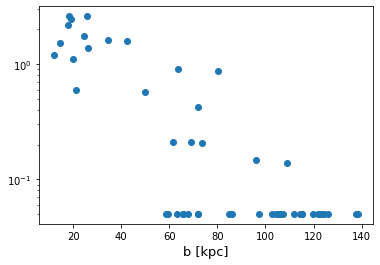

In [453]:
plt.scatter(sample_DM_profile["B_KPC"], sample_DM_profile["REW_2796"]+0.05)
plt.xlabel("b [kpc]", size = 13)
#plt.xscale("log")
plt.yscale("log")

Text(0.5, 0, 'b/Rvir')

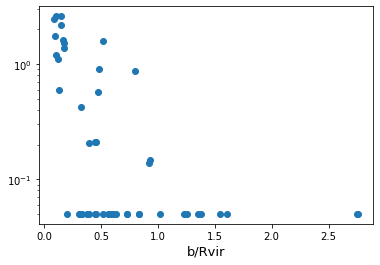

In [454]:
plt.scatter(sample_DM_profile["B_KPC"]/sample_DM_profile["Rvir"], sample_DM_profile["REW_2796"]+0.05)
#plt.xscale("log")
plt.yscale("log")
plt.xlabel("b/Rvir", size = 13)

Text(0.5, 0, 'b/Rs')

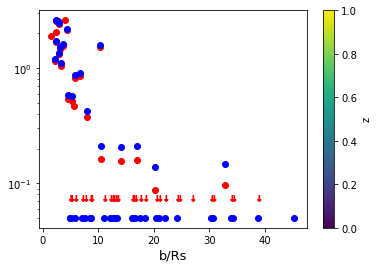

In [496]:
plt.scatter(np.array(isol_visu_rot_abs["B_KPC"]/isol_visu_rot_abs["rs_kpc"]), np.array(isol_visu_rot_abs["REW_2796"]), \
            c = "r", zorder = 3, vmin = 0.4, vmax = 1.5);
plt.colorbar(label = "z")
#plt.scatter(np.array(inner_slope["B_KPC"]/inner_slope["rs_kpc"]), np.array(inner_slope["REW_2796"]), \
#            c = "lime", zorder = 3);
plt.scatter(np.array(isol_visu_rot_noabs["B_KPC"]/isol_visu_rot_noabs["rs_kpc"]), np.array(isol_visu_rot_noabs["detection_limit_p75"]), \
            c = "r", zorder = 3, vmin = 0.4, vmax = 1.5, marker = "$\downarrow$");
plt.scatter(sample_DM_profile["B_KPC"]/sample_DM_profile["rs_kpc"], sample_DM_profile["REW_2796"]+0.05,\
            c = "blue", zorder =  3)

#plt.xscale("log")
plt.yscale("log")
plt.xlabel("b/Rs", size = 13)

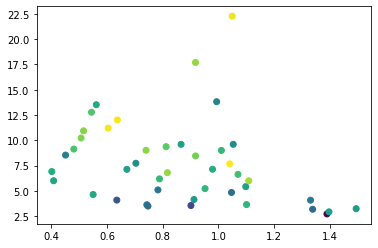

In [421]:
plt.scatter(sample_DM_profile["Z"], sample_DM_profile["rs_kpc"], c = sample_DM_profile["log_Mvir"])

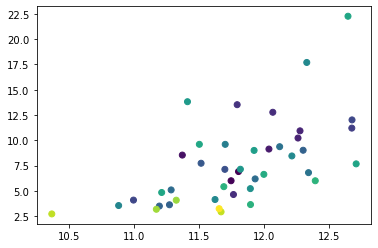

In [422]:
plt.scatter(sample_DM_profile["log_Mvir"], sample_DM_profile["rs_kpc"], c = sample_DM_profile["Z"])

# Normalize rs with z and SFR

In [456]:
x1 = np.array([isol_9_abs["B_KPC"], np.log10(1+ isol_9_abs["Z"]), isol_9_abs["logSFR"]])
x2 = np.array([isol_9_noabs["B_KPC"], np.log10(1+isol_9_noabs["Z"]), isol_9_noabs["logSFR"]])
y1 = np.array(np.log10(isol_9_abs["REW_2796"]))
y2 = np.array(np.log10(isol_9_noabs["detection_limit_p75"]))
sig_y1 = np.array(isol_9_abs["sig_REW_2796"]/isol_9_abs["REW_2796"]/np.log(10))
sig_y2 = np.array(np.ones(x2.shape[1])*0.15)

In [457]:
fit_multi2 = minimize(gt.logL_stats_total_multi, np.array([-2, -0., 2, 2, 0.]), \
               args = (x1, y1, sig_y1, x2, y2, sig_y2), method = "BFGS")
fit_multi2_1sig = np.diag(fit_multi2.hess_inv)**0.5
fit_multi2_1sig_inf = fit_multi2['x'] - fit_multi2_1sig
fit_multi2_1sig_sup = fit_multi2['x'] + fit_multi2_1sig
fit_multi2

      fun: 35.52642655442773
 hess_inv: array([[ 1.45550725e-01, -4.32497218e-05, -5.27012517e-01,
         2.32242706e-02, -1.16297944e-03],
       [-4.32497218e-05,  5.83664971e-06, -7.05706747e-04,
        -8.33775606e-05, -5.78550946e-05],
       [-5.27012517e-01, -7.05706747e-04,  2.19493248e+00,
        -1.18808379e-01,  7.05791846e-03],
       [ 2.32242706e-02, -8.33775606e-05, -1.18808379e-01,
         2.61110373e-02,  1.14039929e-03],
       [-1.16297944e-03, -5.78550946e-05,  7.05791846e-03,
         1.14039929e-03,  3.88845809e-03]])
      jac: array([ 0.00000000e+00, -4.76837158e-06,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 534
      nit: 78
     njev: 89
   status: 0
  success: True
        x: array([ 0.05741585, -0.02214058,  1.61616016,  0.20851448,  0.45147876])

In [458]:
zz = np.log10(np.linspace(0.3, 1.6, 100)+1)
sfr = np.linspace(-2.5, 2.5, 100)
logm = np.linspace(6, 12, 100)
eval_at = [zz, 0]
bb01_z, sig01_z = gt.predict_b(fit_multi2, eval_at = eval_at, rew = 0.1)
#bb01_z, sig01_z = gt.predict_b(fit_multi, z = zz, sfr = 0, logm = 9, rew = 0.1)
eval_at = [np.log10(1+1), sfr]
bb01_sfr, sig01_sfr = gt.predict_b(fit_multi2, eval_at = eval_at, rew = 0.1)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


[Text(1, 0.0, ''),
 Text(1, 25.0, ''),
 Text(1, 50.0, ''),
 Text(1, 75.0, ''),
 Text(1, 100.0, ''),
 Text(1, 125.0, ''),
 Text(1, 150.0, ''),
 Text(1, 175.0, '')]

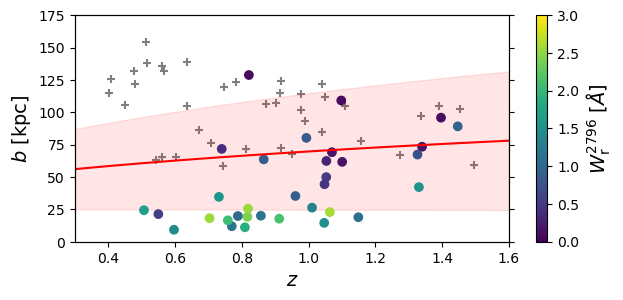

In [460]:
fig, ax1 = plt.subplots(figsize = (7,3), dpi = 100)
cm = plt.cm.get_cmap('RdYlBu')
im = ax1.scatter(isol_9_abs["Z"], isol_9_abs["B_KPC"], c = isol_9_abs["REW_2796"],\
            zorder = 2, vmin = 0, vmax = 3, alpha = 1)
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label("$W^{2796}_{\mathrm{r}}$ $[\AA]$", fontsize=14)
#cbar = plt.colorbar(im, ax=ax1, location='right', shrink=1, pad=0.1)
#cbar.set_label('Colorbar Label')
#ax1.colorbar(label = "$W^{2796}_{\mathrm{r}}$")
ax1.scatter(isol_9_noabs["Z"], isol_9_noabs["B_KPC"], c = "grey",\
             marker = "+", alpha = 1)
ax1.plot(10**zz-1, bb01_z, c = 'red', linestyle = "-", label = "fit W$^{2796}_{\mathrm{r}} = 0.1 \AA$")
#plt.plot(z_predict01 +sig01, bb, c = 'pink', linestyle = "dotted")
#plt.plot(z_predict01 -sig01, bb, c = 'pink', linestyle = "dotted")
ax1.fill_between(10**zz-1, bb01_z - sig01_z, bb01_z + sig01_z, color = "red", alpha = 0.1)
#ax1.plot(np.array(fc_z["z"]), np.array(fc_z["pbest"]), color = "blue", \
#         linestyle = "--", label = "fc($0.1 \AA$) = 50%")
#ax1.fill_between(np.array(fc_z["z"]), np.array(fc_z["plow"]), np.array(fc_z["phigh"]), color = "blue", alpha = 0.1)


ax2 = ax1.twinx()
ax1.set_xlim((0.3, 1.6))
ax1.set_ylim((0., 175))
ax2.set_ylim((0., 175))
ax1.set_ylabel("$b$ [kpc]", size = 14)
ax1.set_xlabel("$z$", size = 14)
ax2.yaxis.set_ticklabels([])
#ax1.legend(loc='upper right', fontsize = 12)
#ax2.legend(loc='upper right')

#plt.axhline(0.5, c = "r")
#plt.legend()

[Text(1, 0.0, ''),
 Text(1, 25.0, ''),
 Text(1, 50.0, ''),
 Text(1, 75.0, ''),
 Text(1, 100.0, ''),
 Text(1, 125.0, ''),
 Text(1, 150.0, ''),
 Text(1, 175.0, '')]

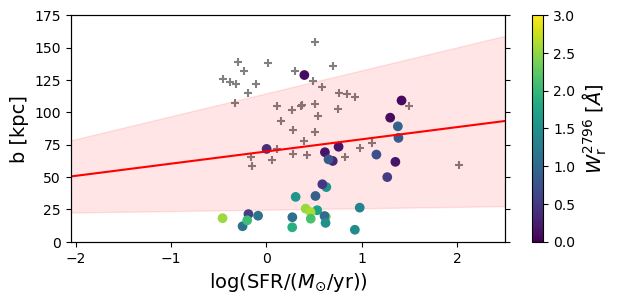

In [461]:
fig, ax1 = plt.subplots(figsize = (7,3), dpi = 100)
cm = plt.cm.get_cmap('RdYlBu')
im = ax1.scatter(isol_9_abs["logSFR"], isol_9_abs["B_KPC"], c = isol_9_abs["REW_2796"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 0, vmax = 3, alpha = 1)
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label("$W^{2796}_{\mathrm{r}}$ $[\AA]$", fontsize=14)
ax1.scatter(isol_9_noabs["logSFR"], isol_9_noabs["B_KPC"], c = "grey",\
             marker = "+", alpha = 1)
ax1.plot(sfr, bb01_sfr, c = 'red', linestyle = "-")
#plt.plot(z_predict01 +sig01, bb, c = 'pink', linestyle = "dotted")
#plt.plot(z_predict01 -sig01, bb, c = 'pink', linestyle = "dotted")
ax1.fill_between(sfr, bb01_sfr - sig01_sfr, bb01_sfr + sig01_sfr, color = "red", alpha = 0.1)
#ax1.plot(np.array(fc_sfr["logsfr"]), np.array(fc_sfr["pbest"]), color = "blue", linestyle = "--")
#ax1.fill_between(np.array(fc_sfr["logsfr"]), np.array(fc_sfr["plow"]), np.array(fc_sfr["phigh"]), color = "blue", alpha = 0.1)

ax2 = ax1.twinx()
ax1.set_xlim((-2.05, 2.5))
ax1.set_ylim((0, 175))
ax2.set_ylim((0, 175))
ax1.set_ylabel("b [kpc]", size = 14)
ax1.set_xlabel("log(SFR/($M_{\odot}$/yr))", size = 14)
ax2.yaxis.set_ticklabels([])
#ax1.legend(loc='upper left')
#plt.axhline(0.5, c = "r")

### Correction of REW 2796

In [780]:
b_coeff = fit_multi2['x'][1]
z_coeff = fit_multi2['x'][2]
sfr_coeff = fit_multi2['x'][3]

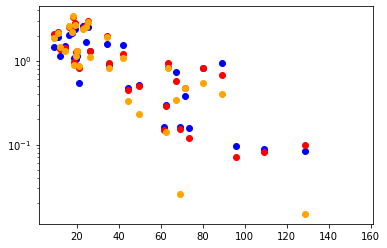

In [474]:
plt.scatter(isol_9_abs["B_KPC"], isol_9_abs["REW_2796"], color = "blue")
plt.scatter(isol_9_noabs["B_KPC"], isol_9_noabs["REW_2796"], color = "blue", marker = "$\downarrow$")

REW_z_corrected =  10**(np.log10(isol_9_abs["REW_2796"]) \
                        - z_coeff*np.log10(isol_9_abs["Z"]+1) + z_coeff*np.log10(1+1))
REW_corrected =  10**(np.log10(isol_9_abs["REW_2796"]) \
                        - z_coeff*np.log10(isol_9_abs["Z"]+1) + z_coeff*np.log10(1+1)) \
                        - sfr_coeff*isol_9_abs["logSFR"] + sfr_coeff*0.
plt.scatter(isol_9_abs["B_KPC"], REW_z_corrected, color = "red")
plt.scatter(isol_9_abs["B_KPC"], REW_corrected, color = "orange")
plt.yscale("log")

/home/cherrey/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


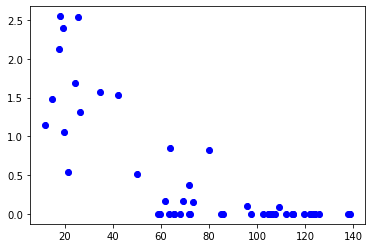

In [475]:
plt.scatter(sample_DM_profile["B_KPC"], sample_DM_profile["REW_2796"], color = "blue")
plt.scatter(sample_DM_profile["B_KPC"], sample_DM_profile["REW_2796"], color = "blue", marker = "$\downarrow$")

REW_z_corrected =  10**(np.log10(sample_DM_profile["REW_2796"]) \
                        - z_coeff*np.log10(sample_DM_profile["Z"]+1) + z_coeff*np.log10(1+1))
REW_corrected =  10**(np.log10(sample_DM_profile["REW_2796"]) \
                        - z_coeff*np.log10(sample_DM_profile["Z"]+1) + z_coeff*np.log10(1+1)) \
                        - sfr_coeff*sample_DM_profile["logSFR"] + sfr_coeff*0.5

Text(0.5, 0, 'b/Rvir')

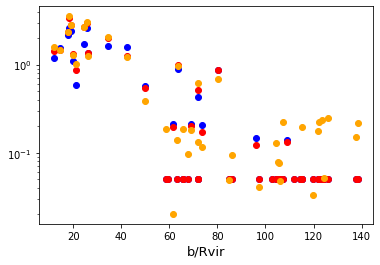

In [476]:
plt.scatter(sample_DM_profile["B_KPC"], sample_DM_profile["REW_2796"]+0.05, c = "b")
plt.scatter(sample_DM_profile["B_KPC"], REW_z_corrected+0.05, c = "r")
plt.scatter(sample_DM_profile["B_KPC"], REW_corrected+0.05, c = "orange")

#plt.xscale("log")
plt.yscale("log")
plt.xlabel("b/Rvir", size = 13)

Text(0.5, 0, 'b/Rvir')

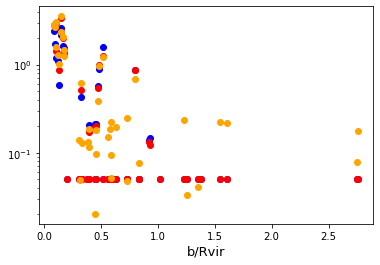

In [477]:
plt.scatter(sample_DM_profile["B_KPC"]/sample_DM_profile["Rvir"], sample_DM_profile["REW_2796"]+0.05, c = "b")
plt.scatter(sample_DM_profile["B_KPC"]/sample_DM_profile["Rvir"], REW_z_corrected+0.05, c = "r")
plt.scatter(sample_DM_profile["B_KPC"]/sample_DM_profile["Rvir"], REW_corrected+0.05, c = "orange")

#plt.xscale("log")
plt.yscale("log")
plt.xlabel("b/Rvir", size = 13)

Text(0.5, 0, 'b [kpc]')

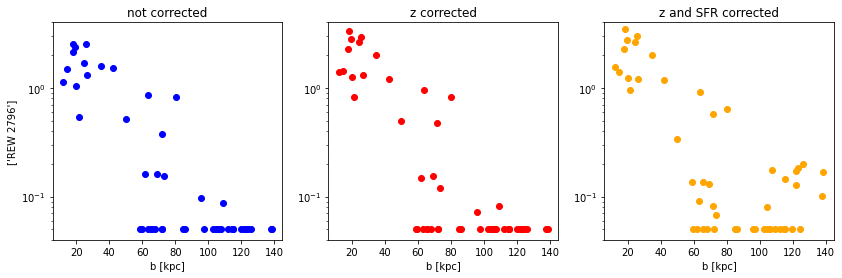

In [478]:
plt.figure(figsize = (14,4))
plt.subplot(131)
plt.title("not corrected")
plt.scatter(sample_DM_profile["B_KPC"], np.maximum(sample_DM_profile["REW_2796"], 0.05), color = "blue")
plt.xlabel("b [kpc]")
plt.ylabel(["REW 2796"])
plt.ylim((0.04, 4))
plt.yscale("log")
plt.subplot(132)
plt.title("z corrected")
plt.scatter(sample_DM_profile["B_KPC"], np.maximum(REW_z_corrected,0.05), color = "red")
plt.ylim((0.04, 4))
plt.xlabel("b [kpc]")
plt.yscale("log")
plt.subplot(133)
plt.title("z and SFR corrected")
plt.scatter(sample_DM_profile["B_KPC"], np.maximum(REW_corrected,0.05), color = "orange")
plt.ylim((0.04, 4))
plt.yscale("log")
plt.xlabel("b [kpc]")

Text(0.5, 0, 'b/Rvir')

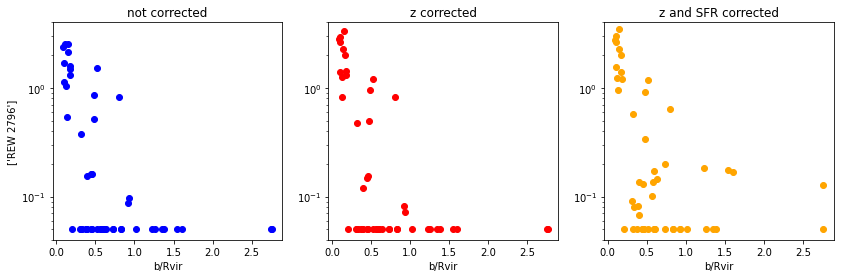

In [479]:
plt.figure(figsize = (14,4))
plt.subplot(131)
plt.title("not corrected")
plt.scatter(sample_DM_profile["B_KPC"]/sample_DM_profile["Rvir"], np.maximum(sample_DM_profile["REW_2796"], 0.05), color = "blue")
plt.xlabel("b/Rvir")
plt.ylabel(["REW 2796"])
plt.ylim((0.04, 4))
plt.yscale("log")
plt.subplot(132)
plt.title("z corrected")
plt.scatter(sample_DM_profile["B_KPC"]/sample_DM_profile["Rvir"], np.maximum(REW_z_corrected,0.05), color = "red")
plt.ylim((0.04, 4))
plt.xlabel("b/Rvir")
plt.yscale("log")
plt.subplot(133)
plt.title("z and SFR corrected")
plt.scatter(sample_DM_profile["B_KPC"]/sample_DM_profile["Rvir"], np.maximum(REW_corrected,0.05), color = "orange")
plt.ylim((0.04, 4))
plt.yscale("log")
plt.xlabel("b/Rvir")

Text(0.5, 0, 'b/rs')

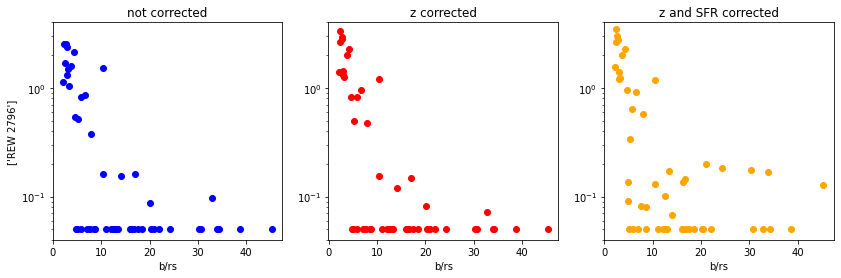

In [480]:
plt.figure(figsize = (14,4))
plt.subplot(131)
plt.title("not corrected")
plt.scatter(sample_DM_profile["B_KPC"]/sample_DM_profile["rs_kpc"], np.maximum(sample_DM_profile["REW_2796"], 0.05), color = "blue")
plt.xlabel("b/rs")
plt.ylabel(["REW 2796"])
plt.ylim((0.04, 4))
plt.yscale("log")
plt.subplot(132)
plt.title("z corrected")
plt.scatter(sample_DM_profile["B_KPC"]/sample_DM_profile["rs_kpc"], np.maximum(REW_z_corrected,0.05), color = "red")
plt.ylim((0.04, 4))
plt.xlabel("b/rs")
plt.yscale("log")
plt.subplot(133)
plt.title("z and SFR corrected")
plt.scatter(sample_DM_profile["B_KPC"]/sample_DM_profile["rs_kpc"], np.maximum(REW_corrected,0.05), color = "orange")
plt.ylim((0.04, 4))
plt.yscale("log")
plt.xlabel("b/rs")

### Correction of $b$

Instead of correction the REW (that can be problematic can limits of detection can get quite high), we can correct b. By doing so the points are just shifted left and right. To do that we start from the fitted equation:

\begin{equation}
    \log(W^{2796}) = a_0 + a_1 b + a_2 \log(1+z) + a_3 \log(\mathrm{SFR})
\end{equation}

and we transform it, to make appear a new B coefficient that is a linear combination of the other terms:
\begin{equation}
    \log(W^{2796}) = a_0 + a_1 \left(b + \frac{a_2}{a_1} \log(1+z) + \frac{a_3}{a_1} \log(\mathrm{SFR}) \right)
\end{equation}

if we want to get the have the $b$ rescaled to a given redshift $z_0$ and SFR$_0$ we just have to do:
\begin{equation}
    \log(W^{2796}) = a_0 + a_1 \left(b + \frac{a_2}{a_1} (\log(1+z) - \log(1+z_0)) + \frac{a_3}{a_1}( \log(\mathrm{SFR}) - \log(\mathrm{SFR_0})) \right)
\end{equation}

We then just have to note:
\begin{equation}
    B = b + \frac{a_2}{a_1} (\log(1+z) - \log(1+z_0)) + \frac{a_3}{a_1}( \log(\mathrm{SFR}) - \log(\mathrm{SFR_0}))
\end{equation}
Such that:
\begin{equation}
    \log(W^{2796}) = a_0 + a_1 B
\end{equation}

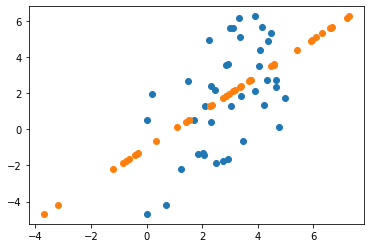

In [779]:
def toto(x, z):
    return 3 + 1*x - 4*z

xx = np.random.uniform(0,5, size = 40)
zz = np.random.uniform(0,2, size = 40)

plt.scatter(xx, toto(xx, zz))
plt.scatter(xx -4*zz/1 + 4*np.ones(len(zz))/1, toto(xx, zz))

In [781]:
b_z_corrected = sample_DM_profile["B_KPC"] + \
                z_coeff/b_coeff*(np.log10(sample_DM_profile["Z"]+1) - z_coeff*np.log10(1+1))

b_corrected = sample_DM_profile["B_KPC"] + \
                z_coeff/b_coeff*(np.log10(sample_DM_profile["Z"]+1) - z_coeff*np.log10(1+1)) + \
                sfr_coeff/b_coeff*(sample_DM_profile["logSFR"] - 0.0)


Text(0.5, 0, 'b [kpc]')

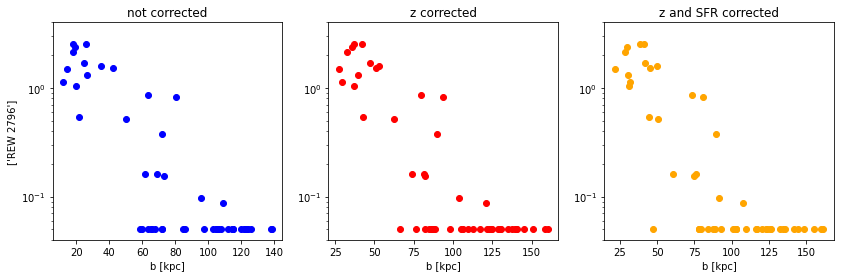

In [782]:
plt.figure(figsize = (14,4))
plt.subplot(131)
plt.title("not corrected")
plt.scatter(sample_DM_profile["B_KPC"], np.maximum(sample_DM_profile["REW_2796"], 0.05), color = "blue")
plt.xlabel("b [kpc]")
plt.ylabel(["REW 2796"])
plt.ylim((0.04, 4))
plt.yscale("log")
plt.subplot(132)
plt.title("z corrected")
plt.scatter(b_z_corrected, np.maximum(sample_DM_profile["REW_2796"], 0.05), color = "red")
plt.ylim((0.04, 4))
plt.xlabel("b [kpc]")
plt.yscale("log")
plt.subplot(133)
plt.title("z and SFR corrected")
plt.scatter(b_corrected, np.maximum(sample_DM_profile["REW_2796"], 0.05), color = "orange")
plt.ylim((0.04, 4))
plt.yscale("log")
plt.xlabel("b [kpc]")

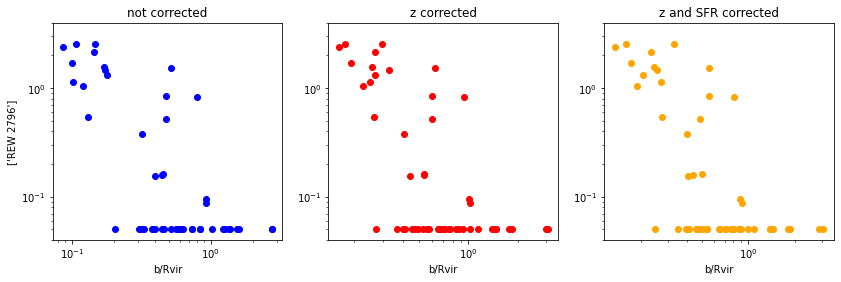

In [785]:
plt.figure(figsize = (14,4))
plt.subplot(131)
plt.title("not corrected")
plt.scatter(sample_DM_profile["B_KPC"]/sample_DM_profile["Rvir"],\
            np.maximum(sample_DM_profile["REW_2796"], 0.05), color = "blue")
plt.xlabel("b/Rvir")
plt.ylabel(["REW 2796"])
plt.xscale("log")
plt.ylim((0.04, 4))
plt.yscale("log")
plt.subplot(132)
plt.title("z corrected")
plt.scatter(b_z_corrected / sample_DM_profile["Rvir"], \
            np.maximum(sample_DM_profile["REW_2796"], 0.05), color = "red")
plt.ylim((0.04, 4))
plt.xlabel("b/Rvir")
plt.yscale("log")
plt.xscale("log")
plt.subplot(133)
plt.title("z and SFR corrected")
plt.scatter(b_corrected/sample_DM_profile["Rvir"], \
            np.maximum(sample_DM_profile["REW_2796"], 0.05), color = "orange")
plt.ylim((0.04, 4))
plt.yscale("log")
plt.xlabel("b/Rvir")
plt.xscale("log")

Text(0.5, 0, 'b/Rvir')

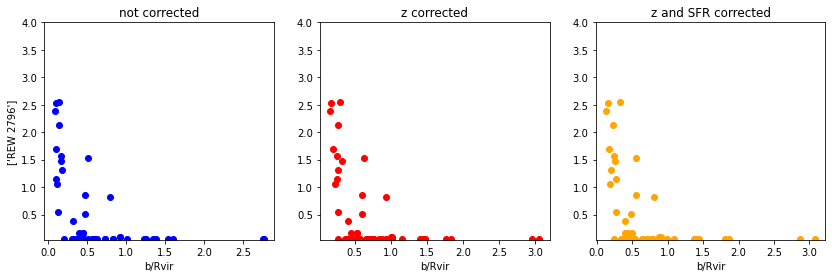

In [813]:
plt.figure(figsize = (14,4))
plt.subplot(131)
plt.title("not corrected")
plt.scatter(sample_DM_profile["B_KPC"]/sample_DM_profile["Rvir"],\
            np.maximum(sample_DM_profile["REW_2796"], 0.05), color = "blue")
plt.xlabel("b/Rvir")
plt.ylabel(["REW 2796"])
#plt.xscale("log")
plt.ylim((0.04, 4))
#plt.yscale("log")
plt.subplot(132)
plt.title("z corrected")
plt.scatter(b_z_corrected / sample_DM_profile["Rvir"], \
            np.maximum(sample_DM_profile["REW_2796"], 0.05), color = "red")
plt.ylim((0.04, 4))
plt.xlabel("b/Rvir")
#plt.yscale("log")
#plt.xscale("log")
plt.subplot(133)
plt.title("z and SFR corrected")
plt.scatter(b_corrected/sample_DM_profile["Rvir"], \
            np.maximum(sample_DM_profile["REW_2796"], 0.05), color = "orange")
plt.ylim((0.04, 4))
#plt.yscale("log")
plt.xlabel("b/Rvir")
#plt.xscale("log")

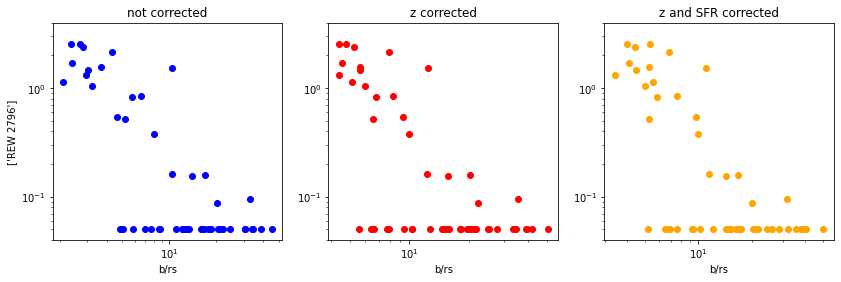

In [786]:
plt.figure(figsize = (14,4))
plt.subplot(131)
plt.title("not corrected")
plt.scatter(sample_DM_profile["B_KPC"]/sample_DM_profile["rs_kpc"],\
            np.maximum(sample_DM_profile["REW_2796"], 0.05), color = "blue")
plt.xlabel("b/rs")
plt.ylabel(["REW 2796"])
plt.xscale("log")
plt.ylim((0.04, 4))
plt.yscale("log")
plt.subplot(132)
plt.title("z corrected")
plt.scatter(b_z_corrected / sample_DM_profile["rs_kpc"], \
            np.maximum(sample_DM_profile["REW_2796"], 0.05), color = "red")
plt.ylim((0.04, 4))
plt.xlabel("b/rs")
plt.yscale("log")
plt.xscale("log")
plt.subplot(133)
plt.title("z and SFR corrected")
plt.scatter(b_corrected/sample_DM_profile["rs_kpc"], \
            np.maximum(sample_DM_profile["REW_2796"], 0.05), color = "orange")
plt.ylim((0.04, 4))
plt.yscale("log")
plt.xlabel("b/rs")
plt.xscale("log")

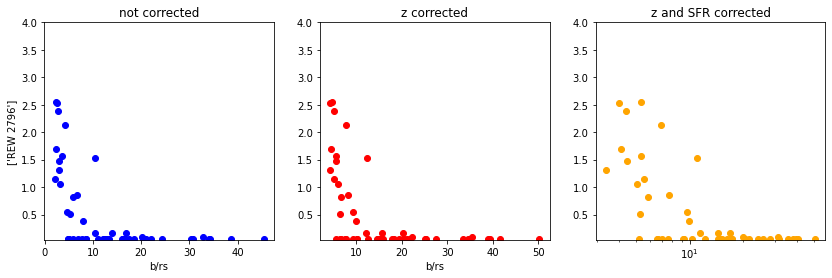

In [812]:
plt.figure(figsize = (14,4))
plt.subplot(131)
plt.title("not corrected")
plt.scatter(sample_DM_profile["B_KPC"]/sample_DM_profile["rs_kpc"],\
            np.maximum(sample_DM_profile["REW_2796"], 0.05), color = "blue")
plt.xlabel("b/rs")
plt.ylabel(["REW 2796"])
#plt.xscale("log")
plt.ylim((0.04, 4))
#plt.yscale("log")
plt.subplot(132)
plt.title("z corrected")
plt.scatter(b_z_corrected / sample_DM_profile["rs_kpc"], \
            np.maximum(sample_DM_profile["REW_2796"], 0.05), color = "red")
plt.ylim((0.04, 4))
plt.xlabel("b/rs")
#plt.yscale("log")
#plt.xscale("log")
plt.subplot(133)
plt.title("z and SFR corrected")
plt.scatter(b_corrected/sample_DM_profile["rs_kpc"], \
            np.maximum(sample_DM_profile["REW_2796"], 0.05), color = "orange")
plt.ylim((0.04, 4))
#plt.yscale("log")
#plt.xlabel("b/rs")
plt.xscale("log")

# Comparaison de la dispersion

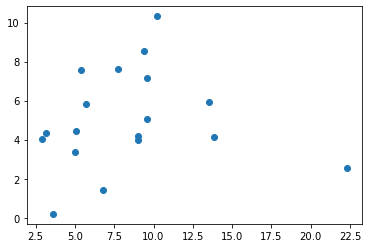

In [1429]:
plt.scatter(high_a["rs_kpc"], high_a["rs_kpc_err"])

In [1430]:
incl = sample_DM_profile["inclination"]>30
al1 = sample_DM_profile["alpha"]>30
al2 = sample_DM_profile["alpha"]>60
kabs = sample_DM_profile["bool_absorption"] == 1
high_a = sample_DM_profile[incl & al2]
high_a_abs = sample_DM_profile[incl & al2 & kabs]
high_a_noabs = sample_DM_profile[incl & al2 & ~kabs]
mid_a = sample_DM_profile[incl & al1 & ~al2]
low_a = sample_DM_profile[incl & ~al1]

In [1431]:
len(high_a)

18

In [1432]:
len(isol_visu_high_alpha)

21

In [1433]:
x1 = np.array(sample_DM_profile_abs["B_KPC"])
x2 = np.array(sample_DM_profile_noabs["B_KPC"])
k = x2>100
x2 = x2[k]
y1 = np.array(np.log10(sample_DM_profile_abs["REW_2796"]))
y2 = np.array(np.log10(sample_DM_profile_noabs["detection_limit_p75"]))
y2 = y2[k]
sig_y1 = np.array(np.maximum(sample_DM_profile_abs["sig_REW_2796"], 0.05)/sample_DM_profile_abs["REW_2796"]/np.log(10))
sig_y2 = np.array(np.ones(len(x2))*0.15)

In [1150]:
fit_b = minimize(gt.logL_stats_total, np.array([0.5,-0.03, 0.1]), \
               args = (x1, y1, sig_y1, x2, y2, sig_y2), method = "BFGS")

fit_b_1sig = np.diag(fit_b.hess_inv)**0.5
fit_b_1sig_inf = fit_b['x'] - fit_b_1sig
fit_b_1sig_sup = fit_b['x'] + fit_b_1sig
fit_b

      fun: 7.492912136223639
 hess_inv: array([[ 9.41535865e-03, -1.29272969e-04,  6.90286713e-04],
       [-1.29272969e-04,  2.59452315e-06, -2.65041573e-05],
       [ 6.90286713e-04, -2.65041573e-05,  1.92394571e-03]])
      jac: array([3.57627869e-07, 8.34465027e-07, 0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 140
      nit: 27
     njev: 35
   status: 0
  success: True
        x: array([ 0.64591333, -0.01864693,  0.26572814])

Text(0, 0.5, '$W^{2796}_{\\mathrm{r}}$ $[\\AA]$')

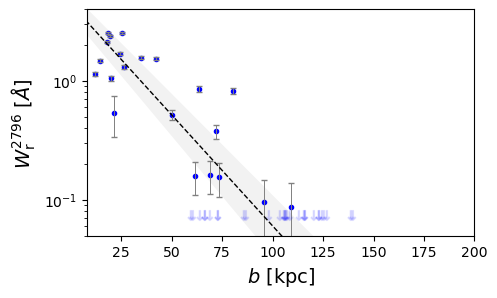

In [1197]:
X = np.linspace(0, 150, 200)
plt.figure(dpi = 100, figsize = (5, 3))

plt.plot(X, 10**gt.model(fit_b['x'], X), linewidth = 1.0, c = "black", \
         linestyle = "--", label = "best fit all", zorder = 3)
plt.fill_between(X, 10**gt.model(fit_b_1sig_inf, X), 10**gt.model(fit_b_1sig_sup, X), \
                 color = "gray", alpha = 0.1, linewidth = 0)

plt.scatter(sample_DM_profile_abs["B_KPC"], sample_DM_profile_abs["REW_2796"], marker = ".", c = "blue",\
           label = "$\log(M_*/M_{\odot})$<9")
plt.errorbar(np.array(sample_DM_profile_abs["B_KPC"]), np.array(sample_DM_profile_abs["REW_2796"]), \
             yerr = np.maximum(sample_DM_profile_abs["sig_REW_2796"], 0.05),\
            linestyle = "none", linewidth = 0.7, c = "grey", capsize=2, zorder = 1)
plt.scatter(sample_DM_profile_noabs["B_KPC"], sample_DM_profile_noabs["detection_limit_p75"], c = "blue",\
             marker = "$\downarrow$",  s = 50, alpha = 0.1)

plt.xlim((8, 200))
plt.ylim((0.05, 4))
#plt.xscale("log")
plt.yscale("log")
plt.xlabel("$b$ [kpc]", size = 14)
plt.ylabel("$W^{2796}_{\mathrm{r}}$ $[\AA]$", size = 14)
#plt.legend()

**résidus et dispersion:**

Text(0, 0.5, 'res $[\\AA]$')

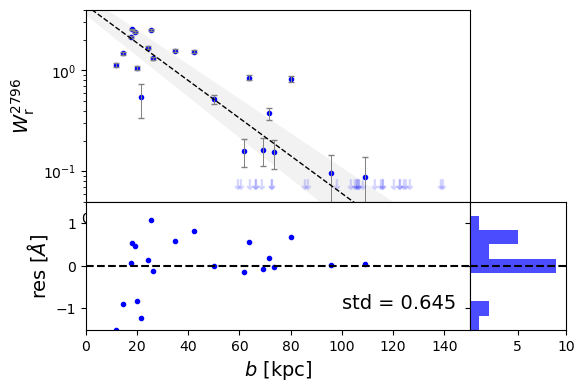

In [1217]:
fig = plt.figure(figsize=(6, 4), dpi = 100)
gs = fig.add_gridspec(5, 5, left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.0, hspace=0.0)
ax = fig.add_subplot(gs[0:3, 0:4])
ax_res = fig.add_subplot(gs[3:5, 0:4])
ax_histy = fig.add_subplot(gs[3:5, 4:5])

X = np.linspace(0, 150, 200)

ax.plot(X, 10**gt.model(fit_b['x'], X), linewidth = 1.0, c = "black", \
         linestyle = "--", label = "best fit all", zorder = 3)
ax.fill_between(X, 10**gt.model(fit_b_1sig_inf, X), 10**gt.model(fit_b_1sig_sup, X), \
                 color = "gray", alpha = 0.1, linewidth = 0)

ax.scatter(sample_DM_profile_abs["B_KPC"], sample_DM_profile_abs["REW_2796"], marker = ".", c = "blue",\
           label = "$\log(M_*/M_{\odot})$<9")
ax.errorbar(np.array(sample_DM_profile_abs["B_KPC"]), np.array(sample_DM_profile_abs["REW_2796"]), \
             yerr = np.maximum(sample_DM_profile_abs["sig_REW_2796"], 0.05),\
            linestyle = "none", linewidth = 0.7, c = "grey", capsize=2, zorder = 1)
ax.scatter(sample_DM_profile_noabs["B_KPC"], sample_DM_profile_noabs["detection_limit_p75"], c = "blue",\
             marker = "$\downarrow$",  s = 50, alpha = 0.1)

ax.set_xlim((0, 150))
ax.set_ylim((0.05, 4))
ax.set_yscale("log")


ax_res.scatter(sample_DM_profile_abs["B_KPC"],\
            sample_DM_profile_abs["REW_2796"] - 10**gt.model(fit_b['x'], sample_DM_profile_abs["B_KPC"]),\
            marker = ".", c = "blue", label = "$\log(M_*/M_{\odot})$<9")
#ax.scatter(sample_DM_profile_noabs["B_KPC"],\
#            sample_DM_profile_noabs["REW_2796"] - 10**gt.model(fit_b['x'], sample_DM_profile_noabs["B_KPC"]), \
#            c = "blue",  marker = ".")
ax_res.set_ylim((-1.5, 1.5))
ax_res.set_xlim((0, 150))


std = np.std(sample_DM_profile_abs["REW_2796"] - 10**gt.model(fit_b['x'], sample_DM_profile_abs["B_KPC"]))
label = "std = " + str(np.round(std, 3))
ax_histy.hist(sample_DM_profile_abs["REW_2796"] - 10**gt.model(fit_b['x'], sample_DM_profile_abs["B_KPC"]),\
              bins = 9, range = (-1.5,1.5), \
             orientation='horizontal', color='blue', alpha = 0.7, label = label);
ax_histy.set_ylim((-1.5, 1.5))
ax_histy.set_yticklabels([])
ax_histy.set_xticks([5, 10])
ax_res.text(100, -1, label, fontsize = 14)

plt.axhline(0, c = "black", linestyle = "--")
#plt.xlim((0, 200))
ax_res.axhline(0, color = "black", linestyle = "--")
ax_res.set_xlabel("$b$ [kpc]", size = 14)
ax.set_ylabel("$W^{2796}_{\mathrm{r}}$", size = 14)
ax_res.set_ylabel("res $[\AA]$", size = 14)
#plt.legend()

In [1688]:
x1 = np.array(isol_rs["B_KPC"])
y1 = np.array(np.log10(np.maximum(isol_rs["REW_2796"],0.075))) 
sig_x1 = np.ones(len(isol_rs["B_KPC"]))
sig_y1 = np.array(np.maximum(isol_rs["sig_REW_2796"], 0.05)/np.maximum(isol_rs["REW_2796"],0.075)/np.log(10))

Paramètres ajustés: slope = 0.559007599113492, intercept = -0.010270020318594864
Incertitudes sur les paramètres: slope_err = 0.055807356841629685, intercept_err = 0.0019700786362706513


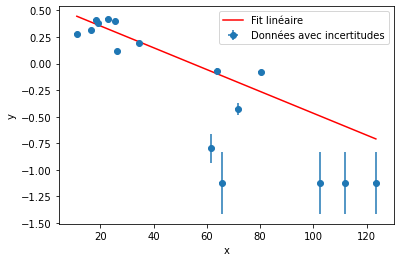

In [1689]:
# Configuration de l'ODR avec la fonction modèle, les données et les incertitudes
linear = odr.Model(gt.model)
data = odr.RealData(x1, y1, sx=sig_x1, sy=sig_y1)
odr_instance = odr.ODR(data, linear, beta0=[1., 1.])

# Exécuter l'ajustement
output_b = odr_instance.run()

# Afficher les résultats
print("Paramètres ajustés: slope = {}, intercept = {}".format(output_b.beta[0], output_b.beta[1]))
print("Incertitudes sur les paramètres: slope_err = {}, intercept_err = {}".format(output_b.sd_beta[0], output_b.sd_beta[1]))

output_b_1sig_inf = output_b.beta - output_b.sd_beta
output_b_1sig_sup = output_b.beta + output_b.sd_beta

# Tracé des données et du fit
x_fit = np.linspace(min(x1), max(x1), 100)
y_fit = gt.model(output_b.beta, x_fit)

plt.errorbar(x1, y1, xerr=sig_x1, yerr=sig_y1, fmt='o', label='Données avec incertitudes')
plt.plot(x_fit, y_fit, label='Fit linéaire', color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


Text(50, 2, 'weighted std = 8.03')

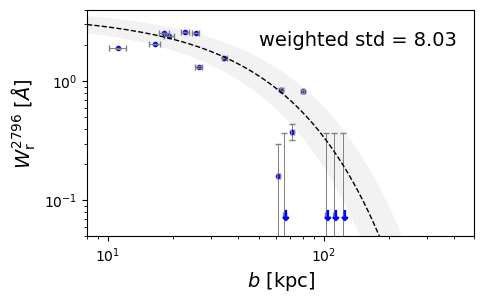

In [1691]:
plt.figure(figsize = (5,3), dpi = 100)
X = np.linspace(0, 300, 300)
plt.plot(X, 10**gt.model(output_b.beta, X), linewidth = 1.0, c = "black", \
         linestyle = "--", label = "best fit all", zorder = 3)
plt.fill_between(X, 10**gt.model(output_b_1sig_inf, X), 10**gt.model(output_b_1sig_sup, X), \
                 color = "gray", alpha = 0.1, linewidth = 0)


plt.errorbar(x1, 10**y1, xerr = sig_x1, yerr = sig_y1,\
            linestyle = "none", linewidth = 0.7, c = "grey", capsize=2, zorder = 1)
plt.scatter(isol_rs_abs["B_KPC"], isol_rs_abs["REW_2796"], marker = ".", c = "blue",\
           label = "$\log(M_*/M_{\odot})$<9")
plt.scatter(isol_rs_noabs["B_KPC"], isol_rs_noabs["detection_limit_p75"], c = "blue",\
             marker = "$\downarrow$",  s = 50, zorder = 2)

plt.xlim((8, 500))
plt.ylim((0.05, 4))
plt.yscale("log")
plt.xscale("log")
plt.xlabel("$b$ [kpc]", size = 14)
plt.ylabel("$W^{2796}_{\mathrm{r}}$ $[\AA]$", size = 14)

residuals = isol_rs_abs["REW_2796"] - 10**gt.model(output_b.beta, isol_rs_abs["B_KPC"])
weighted_residuals = residuals / np.maximum(isol_rs_abs["sig_REW_2796"], 0.05)

# Calcul de la déviation standard des résidus pondérés
dof = len(x1) - len(output_b.beta)  # Degrés de liberté
weighted_residuals_std = np.sqrt(np.sum(weighted_residuals**2) / len(x1))

label = "weighted std = " + str(np.round(weighted_residuals_std, 2))
plt.text(50, 2, label, fontsize = 14)


### b/rvir

In [1669]:
x1 = np.array(sample_DM_profile_abs["B_KPC"]/sample_DM_profile_abs["Rvir"])
x2 = np.array(sample_DM_profile_noabs["B_KPC"]/sample_DM_profile_noabs["Rvir"])
k = x2>100
x2 = x2[k]
y1 = np.array(np.log10(sample_DM_profile_abs["REW_2796"]))
y2 = np.array(np.log10(sample_DM_profile_noabs["detection_limit_p75"]))
y2 = y2[k]
sig_y1 = np.array(np.maximum(sample_DM_profile_abs["sig_REW_2796"], 0.05)/sample_DM_profile_abs["REW_2796"]/np.log(10))
sig_y2 = np.array(np.ones(len(x2))*0.25)

In [1670]:
fit_b_Rvir = minimize(gt.logL_stats_total, np.array([0.5,-0.01, 0.1]), \
               args = (x1, y1, sig_y1, x2, y2, sig_y2), method = "BFGS")

fit_b_Rvir_1sig = np.diag(fit_b_Rvir.hess_inv)**0.5
fit_b_Rvir_1sig_inf = fit_b_Rvir['x'] - fit_b_Rvir_1sig
fit_b_Rvir_1sig_sup = fit_b_Rvir['x'] + fit_b_Rvir_1sig
fit_b_Rvir

      fun: 6.22776397411489
 hess_inv: array([[ 1.30850159e-02, -2.55159459e-02, -4.53605975e-05],
       [-2.55159459e-02,  7.98937700e-02, -9.82088469e-04],
       [-4.53605975e-05, -9.82088469e-04,  2.77359197e-03]])
      jac: array([2.38418579e-07, 1.19209290e-07, 1.19209290e-07])
  message: 'Optimization terminated successfully.'
     nfev: 100
      nit: 21
     njev: 25
   status: 0
  success: True
        x: array([ 0.29706814, -1.2261769 ,  0.30885127])

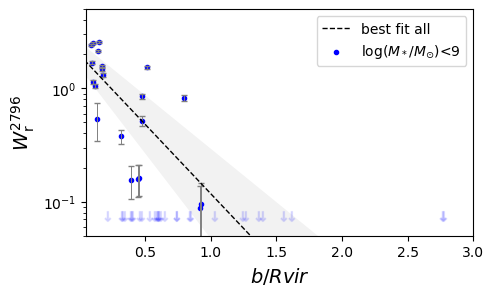

In [1671]:
X = np.linspace(0, 3, 200)
plt.figure(dpi = 100, figsize = (5, 3))

plt.plot(X, 10**gt.model(fit_b_Rvir['x'], X), linewidth = 1.0, c = "black", \
         linestyle = "--", label = "best fit all", zorder = 3)
plt.fill_between(X, 10**gt.model(fit_b_Rvir_1sig_inf, X), 10**gt.model(fit_b_Rvir_1sig_sup, X), \
                 color = "gray", alpha = 0.1, linewidth = 0)

plt.scatter(sample_DM_profile_abs["B_KPC"]/sample_DM_profile_abs["Rvir"], \
            sample_DM_profile_abs["REW_2796"], marker = ".", c = "blue",\e
           label = "$\log(M_*/M_{\odot})$<9")
plt.errorbar(np.array(sample_DM_profile_abs["B_KPC"]/sample_DM_profile_abs["Rvir"]),\
             np.array(sample_DM_profile_abs["REW_2796"]), \
             yerr = np.maximum(sample_DM_profile_abs["sig_REW_2796"], 0.05),\
            linestyle = "none", linewidth = 0.7, c = "grey", capsize=2, zorder = 1)
plt.scatter(sample_DM_profile_noabs["B_KPC"]/sample_DM_profile_noabs["Rvir"],\
            sample_DM_profile_noabs["detection_limit_p75"], c = "blue",\
             marker = "$\downarrow$",  s = 50, alpha = 0.1)

plt.xlim((0.05, 3))
plt.ylim((0.05, 5))
#plt.xscale("log")
plt.yscale("log")
plt.xlabel("$b/Rvir$", size = 14)
plt.ylabel("$W^{2796}_{\mathrm{r}}$", size = 14)
plt.legend()

Text(0, 0.5, '$W^{2796}_{\\mathrm{r}}$')

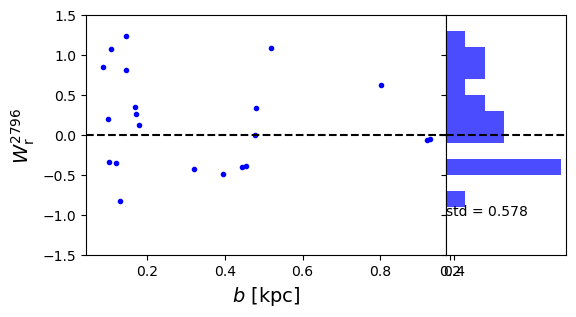

In [1672]:
fig = plt.figure(figsize=(6, 3), dpi = 100)
gs = fig.add_gridspec(1, 4, left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.0, hspace=0.0)
ax = fig.add_subplot(gs[0:1, 0:3])
ax_histy = fig.add_subplot(gs[0:1, 3:4])

X = np.linspace(0, 150, 200)

ax.scatter(sample_DM_profile_abs["B_KPC"]/sample_DM_profile_abs["Rvir"],\
            sample_DM_profile_abs["REW_2796"] - 10**gt.model(fit_b_Rvir['x'], sample_DM_profile_abs["B_KPC"]/sample_DM_profile_abs["Rvir"]),\
            marker = ".", c = "blue", label = "$\log(M_*/M_{\odot})$<9")
#ax.scatter(sample_DM_profile_noabs["B_KPC"]/sample_DM_profile_noabs["Rvir"],\
#            sample_DM_profile_noabs["REW_2796"] - 10**gt.model(fit_b_Rvir['x'], sample_DM_profile_noabs["B_KPC"]/sample_DM_profile_noabs["Rvir"]), \
#            c = "blue",  marker = ".")
ax.set_ylim((-1.5, 1.5))

std = np.std(sample_DM_profile_abs["REW_2796"] - 10**gt.model(fit_b_Rvir['x'], sample_DM_profile_abs["B_KPC"]/sample_DM_profile_abs["Rvir"]))
label = "std = " + str(np.round(std, 3))
ax_histy.hist(sample_DM_profile_abs["REW_2796"] - 10**gt.model(fit_b_Rvir['x'], sample_DM_profile_abs["B_KPC"]/sample_DM_profile_abs["Rvir"]),\
              bins = 15, range = (-1.5,1.5), \
             orientation='horizontal', color='blue', alpha = 0.7, label = label);
ax_histy.set_ylim((-1.5, 1.5))
ax_histy.set_yticklabels([])
ax_histy.set_xticks([0.2, 0.4])
ax_histy.text(0, -1, label)

plt.axhline(0, c = "black", linestyle = "--")
#plt.xlim((0, 200))
ax.axhline(0, color = "black", linestyle = "--")
ax.set_xlabel("$b$ [kpc]", size = 14)
ax.set_ylabel("$W^{2796}_{\mathrm{r}}$", size = 14)
#plt.legend()

Text(0, 0.5, 'res $[\\AA]$')

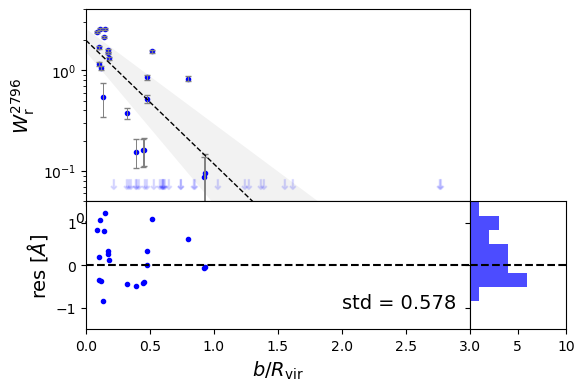

In [1673]:
fig = plt.figure(figsize=(6, 4), dpi = 100)
gs = fig.add_gridspec(5, 5, left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.0, hspace=0.0)
ax = fig.add_subplot(gs[0:3, 0:4])
ax_res = fig.add_subplot(gs[3:5, 0:4])
ax_histy = fig.add_subplot(gs[3:5, 4:5])

X = np.linspace(0, 5, 200)

ax.plot(X, 10**gt.model(fit_b_Rvir['x'], X), linewidth = 1.0, c = "black", \
         linestyle = "--", label = "best fit all", zorder = 3)
ax.fill_between(X, 10**gt.model(fit_b_Rvir_1sig_inf, X), 10**gt.model(fit_b_Rvir_1sig_sup, X), \
                 color = "gray", alpha = 0.1, linewidth = 0)

ax.scatter(sample_DM_profile_abs["B_KPC"]/sample_DM_profile_abs["Rvir"], sample_DM_profile_abs["REW_2796"], marker = ".", c = "blue",\
           label = "$\log(M_*/M_{\odot})$<9")
ax.errorbar(np.array(sample_DM_profile_abs["B_KPC"]/sample_DM_profile_abs["Rvir"]), np.array(sample_DM_profile_abs["REW_2796"]), \
             yerr = np.maximum(sample_DM_profile_abs["sig_REW_2796"], 0.05),\
            linestyle = "none", linewidth = 0.7, c = "grey", capsize=2, zorder = 1)
ax.scatter(sample_DM_profile_noabs["B_KPC"]/sample_DM_profile_noabs["Rvir"], sample_DM_profile_noabs["detection_limit_p75"], c = "blue",\
             marker = "$\downarrow$",  s = 50, alpha = 0.1)

ax.set_xlim((0, 3))
ax.set_ylim((0.05, 4))
ax.set_yscale("log")


ax_res.scatter(sample_DM_profile_abs["B_KPC"]/sample_DM_profile_abs["Rvir"],\
            sample_DM_profile_abs["REW_2796"] - 10**gt.model(fit_b_Rvir['x'], sample_DM_profile_abs["B_KPC"]/sample_DM_profile_abs["Rvir"]),\
            marker = ".", c = "blue", label = "$\log(M_*/M_{\odot})$<9")
#ax.scatter(sample_DM_profile_noabs["B_KPC"],\
#            sample_DM_profile_noabs["REW_2796"] - 10**gt.model(fit_b['x'], sample_DM_profile_noabs["B_KPC"]), \
#            c = "blue",  marker = ".")
ax_res.set_ylim((-1.5, 1.5))
ax_res.set_xlim((0, 3))


std = np.std(sample_DM_profile_abs["REW_2796"] - 10**gt.model(fit_b_Rvir['x'], sample_DM_profile_abs["B_KPC"]/sample_DM_profile_abs["Rvir"]))
label = "std = " + str(np.round(std, 3))
ax_histy.hist(sample_DM_profile_abs["REW_2796"] - 10**gt.model(fit_b_Rvir['x'], sample_DM_profile_abs["B_KPC"]/sample_DM_profile_abs["Rvir"]),\
              bins = 9, range = (-1.5,1.5), \
             orientation='horizontal', color='blue', alpha = 0.7, label = label);
ax_histy.set_ylim((-1.5, 1.5))
ax_histy.set_yticklabels([])
ax_histy.set_xticks([5, 10])
ax_res.text(2, -1, label, fontsize = 14)

plt.axhline(0, c = "black", linestyle = "--")
#plt.xlim((0, 200))
ax_res.axhline(0, color = "black", linestyle = "--")
ax_res.set_xlabel("$b/R_{\mathrm{vir}}$", size = 14)
ax.set_ylabel("$W^{2796}_{\mathrm{r}}$", size = 14)
ax_res.set_ylabel("res $[\AA]$", size = 14)
#plt.legend()

### b/rvir avec incertitudes horizontales

In [1674]:
x1 = np.array(isol_rs["B_KPC"]/isol_rs["Rvir"])
y1 = np.array(np.log10(np.maximum(isol_rs["REW_2796"],0.075))) 
sig_x1 = np.array(isol_rs["Rvir_err"]*isol_rs["B_KPC"]/(isol_rs["Rvir"]**2))
sig_y1 = np.array(np.maximum(isol_rs["sig_REW_2796"], 0.05)/np.maximum(isol_rs["REW_2796"],0.075)/np.log(10))

Paramètres ajustés: slope = 0.6533572282640735, intercept = -2.9428562971012178
Incertitudes sur les paramètres: slope_err = 0.11170471155767905, intercept_err = 0.7339555285042823


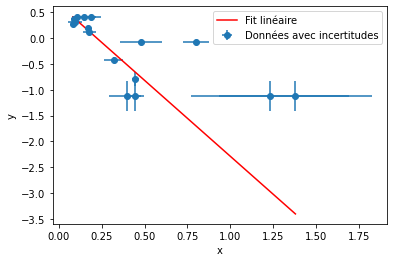

In [1675]:
# Configuration de l'ODR avec la fonction modèle, les données et les incertitudes
linear = odr.Model(gt.model)
data = odr.RealData(x1, y1, sx=sig_x1, sy=sig_y1)
odr_instance = odr.ODR(data, linear, beta0=[1., 1.])

# Exécuter l'ajustement
output_brvir = odr_instance.run()

# Afficher les résultats
print("Paramètres ajustés: slope = {}, intercept = {}".format(output_brvir.beta[0], output_brvir.beta[1]))
print("Incertitudes sur les paramètres: slope_err = {}, intercept_err = {}".format(output_brvir.sd_beta[0], output_brvir.sd_beta[1]))

output_brvir_1sig_inf = output_brvir.beta - output_brvir.sd_beta
output_brvir_1sig_sup = output_brvir.beta + output_brvir.sd_beta

# Tracé des données et du fit
x_fit = np.linspace(min(x1), max(x1), 100)
y_fit = gt.model(output_brvir.beta, x_fit)

plt.errorbar(x1, y1, xerr=sig_x1, yerr=sig_y1, fmt='o', label='Données avec incertitudes')
plt.plot(x_fit, y_fit, label='Fit linéaire', color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


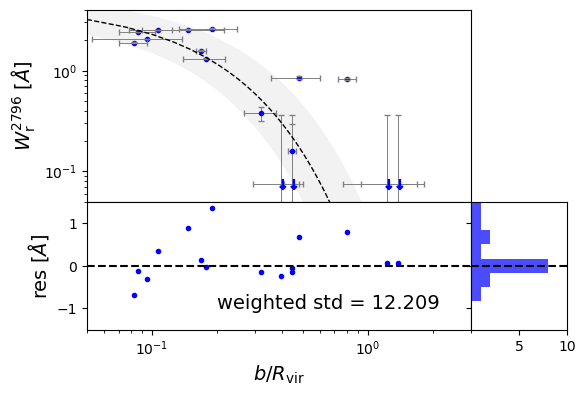

In [1676]:
fig = plt.figure(figsize=(6, 4), dpi = 100)
gs = fig.add_gridspec(5, 5, left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.0, hspace=0.0)
ax = fig.add_subplot(gs[0:3, 0:4])
ax_res = fig.add_subplot(gs[3:5, 0:4])
ax_histy = fig.add_subplot(gs[3:5, 4:5])

X = np.linspace(0, 5, 200)

ax.plot(X, 10**gt.model(output_brvir.beta, X), linewidth = 1.0, c = "black", \
         linestyle = "--", label = "best fit all", zorder = 3)
ax.fill_between(X, 10**gt.model(output_brvir_1sig_inf, X), 10**gt.model(output_brvir_1sig_sup, X), \
                 color = "gray", alpha = 0.1, linewidth = 0)


ax.errorbar(x1, 10**y1, xerr = sig_x1, yerr = sig_y1,\
            linestyle = "none", linewidth = 0.7, c = "grey", capsize=2, zorder = 1)
ax.scatter(isol_rs_abs["B_KPC"]/isol_rs_abs["Rvir"], isol_rs_abs["REW_2796"], marker = ".", c = "blue",\
           label = "$\log(M_*/M_{\odot})$<9")
ax.scatter(isol_rs_noabs["B_KPC"]/isol_rs_noabs["Rvir"], isol_rs_noabs["detection_limit_p75"], c = "blue",\
             marker = "$\downarrow$",  s = 50, zorder = 2)

ax.set_xlim((0.05, 3))
ax.set_ylim((0.05, 4))
ax.set_yscale("log")


ax_res.scatter(x1,\
            10**y1 - 10**gt.model(output_brvir.beta, x1),\
            marker = ".", c = "blue", label = "$\log(M_*/M_{\odot})$<9")
#ax.scatter(sample_DM_profile_noabs["B_KPC"],\
#            sample_DM_profile_noabs["REW_2796"] - 10**gt.model(fit_b['x'], sample_DM_profile_noabs["B_KPC"]), \
#            c = "blue",  marker = ".")
ax_res.set_ylim((-1.5, 1.5))
ax_res.set_xlim((0.05, 3))


std = np.std(isol_rs_abs["REW_2796"] - 10**gt.model(fit_b_Rvir['x'], isol_rs_abs["B_KPC"]/isol_rs_abs["Rvir"]))
# Calcul des résidus pondérés
#residuals = y1 - gt.model(output_brvir.beta, x1)
#weighted_residuals = residuals / sig_y1

residuals = isol_rs_abs["REW_2796"] - 10**gt.model(output_brvir.beta, isol_rs_abs["B_KPC"]/isol_rs_abs["Rvir"])
weighted_residuals = residuals / np.maximum(isol_rs_abs["sig_REW_2796"], 0.05)

# Calcul de la déviation standard des résidus pondérés
dof = len(isol_rs_abs["REW_2796"]) - len(output.beta)  # Degrés de liberté
weighted_residuals_std = np.sqrt(np.sum(weighted_residuals**2) / len(isol_rs_abs["REW_2796"]))

label = "weighted std = " + str(np.round(weighted_residuals_std, 3))
ax_histy.hist(10**y1 - 10**gt.model(output_brvir.beta, x1),\
              bins = 9, range = (-1.5,1.5), \
             orientation='horizontal', color='blue', alpha = 0.7, label = label);
ax_histy.set_ylim((-1.5, 1.5))
ax_histy.set_yticklabels([])
ax_histy.set_xticks([5, 10])
ax_res.text(0.2, -1, label, fontsize = 14)

plt.axhline(0, c = "black", linestyle = "--")
#plt.xlim((0, 200))
ax_res.axhline(0, color = "black", linestyle = "--")
ax_res.set_xlabel("$b/R_{\mathrm{vir}}$", size = 14)
ax.set_ylabel("$W^{2796}_{\mathrm{r}}$ $[\AA]$", size = 14)
ax_res.set_ylabel("res $[\AA]$", size = 14)
ax_res.set_xscale("log")
ax.set_xscale("log")
#plt.legend()

Text(0.3, 2, 'weighted std = 10.57')

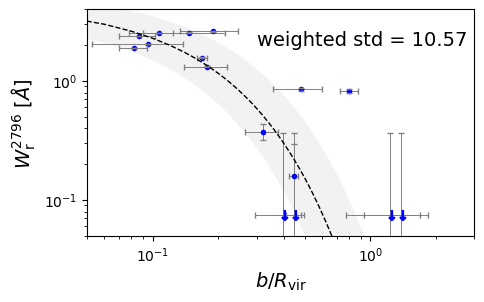

In [1677]:
plt.figure(figsize = (5,3), dpi = 100)
X = np.linspace(0, 4, 200)
plt.plot(X, 10**gt.model(output_brvir.beta, X), linewidth = 1.0, c = "black", \
         linestyle = "--", label = "best fit all", zorder = 3)
plt.fill_between(X, 10**gt.model(output_brvir_1sig_inf, X), 10**gt.model(output_brvir_1sig_sup, X), \
                 color = "gray", alpha = 0.1, linewidth = 0)


plt.errorbar(x1, 10**y1, xerr = sig_x1, yerr = sig_y1,\
            linestyle = "none", linewidth = 0.7, c = "grey", capsize=2, zorder = 1)
plt.scatter(isol_rs_abs["B_KPC"]/isol_rs_abs["Rvir"], isol_rs_abs["REW_2796"], marker = ".", c = "blue",\
           label = "$\log(M_*/M_{\odot})$<9")
plt.scatter(isol_rs_noabs["B_KPC"]/isol_rs_noabs["Rvir"], isol_rs_noabs["detection_limit_p75"], c = "blue",\
             marker = "$\downarrow$",  s = 50, zorder = 2)

plt.xlim((0.05, 3))
plt.ylim((0.05, 4))
plt.yscale("log")
plt.xscale("log")
plt.xlabel("$b/R_{\mathrm{vir}}$", size = 14)
plt.ylabel("$W^{2796}_{\mathrm{r}}$ $[\AA]$", size = 14)

residuals = isol_rs_abs["REW_2796"] - 10**gt.model(output_brvir.beta, isol_rs_abs["B_KPC"]/isol_rs_abs["Rvir"])
weighted_residuals = residuals / np.maximum(isol_rs_abs["sig_REW_2796"], 0.05)

# Calcul de la déviation standard des résidus pondérés
dof = len(x1) - len(output_brs.beta)  # Degrés de liberté
weighted_residuals_std = np.sqrt(np.sum(weighted_residuals**2) / len(x1))

label = "weighted std = " + str(np.round(weighted_residuals_std, 2))
plt.text(0.3, 2, label, fontsize = 14)


### Rs

In [1678]:
x1 = np.array(sample_DM_profile_abs["B_KPC"]/sample_DM_profile_abs["rs_kpc"])
x2 = np.array(sample_DM_profile_noabs["B_KPC"]/sample_DM_profile_noabs["rs_kpc"])
k = x2>100
x2 = x2[k]
y1 = np.array(np.log10(sample_DM_profile_abs["REW_2796"]))
y2 = np.array(np.log10(sample_DM_profile_noabs["detection_limit_p75"]))
y2 = y2[k]
sig_y1 = np.array(np.maximum(sample_DM_profile_abs["sig_REW_2796"], 0.05)/sample_DM_profile_abs["REW_2796"]/np.log(10))
sig_y2 = np.array(np.ones(len(x2))*0.25)
#sig_y2 = sig_y2[k]

<ErrorbarContainer object of 3 artists>

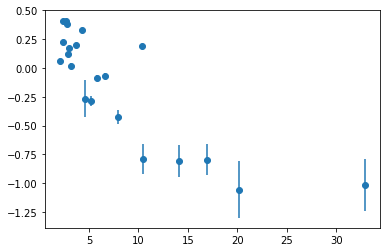

In [1679]:
plt.errorbar(x1, y1, yerr = sig_y1, linestyle = "none", marker = "o")
plt.errorbar(x2, y2, yerr = sig_y2, linestyle = "none", marker = "o")

In [1680]:
fit_b_rs = minimize(gt.logL_stats_total, np.array([0.4,-0.01, 0.1]), \
               args = (x1, y1, sig_y1, x2, y2, sig_y2), method = "BFGS")

fit_b_rs_1sig = np.diag(fit_b_rs.hess_inv)**0.5
fit_b_rs_1sig_inf = fit_b_rs['x'] - fit_b_rs_1sig
fit_b_rs_1sig_sup = fit_b_rs['x'] + fit_b_rs_1sig
fit_b_rs

      fun: 1.0089918944355176
 hess_inv: array([[ 5.92251622e-03, -4.88710088e-04, -4.36008510e-04],
       [-4.88710088e-04,  7.35351218e-05,  3.36373609e-05],
       [-4.36008510e-04,  3.36373609e-05,  1.62820084e-03]])
      jac: array([-2.68220901e-07, -1.63912773e-06, -4.17232513e-07])
  message: 'Optimization terminated successfully.'
     nfev: 96
      nit: 17
     njev: 24
   status: 0
  success: True
        x: array([ 0.30049839, -0.05565792,  0.23055543])

Text(0, 0.5, '$W^{2796}_{\\mathrm{r}}$')

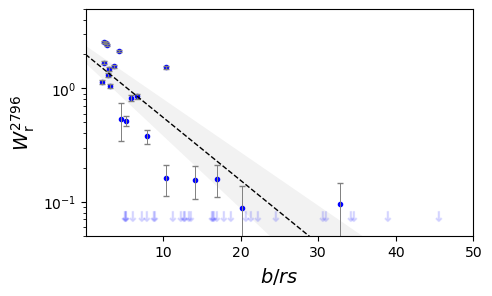

In [1681]:
X = np.linspace(0, 50, 200)
plt.figure(dpi = 100, figsize = (5, 3))

plt.plot(X, 10**gt.model(fit_b_rs['x'], X), linewidth = 1.0, c = "black", \
         linestyle = "--", label = "best fit all", zorder = 3)
plt.fill_between(X, 10**gt.model(fit_b_rs_1sig_inf, X), 10**gt.model(fit_b_rs_1sig_sup, X), \
                 color = "gray", alpha = 0.1, linewidth = 0)

plt.scatter(sample_DM_profile_abs["B_KPC"]/sample_DM_profile_abs["rs_kpc"], \
            sample_DM_profile_abs["REW_2796"], marker = ".", c = "blue",\
           label = "$\log(M_*/M_{\odot})$<9")
plt.errorbar(np.array(sample_DM_profile_abs["B_KPC"]/sample_DM_profile_abs["rs_kpc"]),\
             np.array(sample_DM_profile_abs["REW_2796"]), \
             yerr = np.maximum(sample_DM_profile_abs["sig_REW_2796"], 0.05),\
            linestyle = "none", linewidth = 0.7, c = "grey", capsize=2, zorder = 1)
plt.scatter(sample_DM_profile_noabs["B_KPC"]/sample_DM_profile_noabs["rs_kpc"],\
            sample_DM_profile_noabs["detection_limit_p75"], c = "blue",\
             marker = "$\downarrow$",  s = 50, alpha = 0.1)

plt.xlim((0.05, 50))
plt.ylim((0.05, 5))
#plt.xscale("log")
plt.yscale("log")
plt.xlabel("$b/rs$", size = 14)
plt.ylabel("$W^{2796}_{\mathrm{r}}$", size = 14)
#plt.legend()

Text(0, 0.5, '$W^{2796}_{\\mathrm{r}}$')

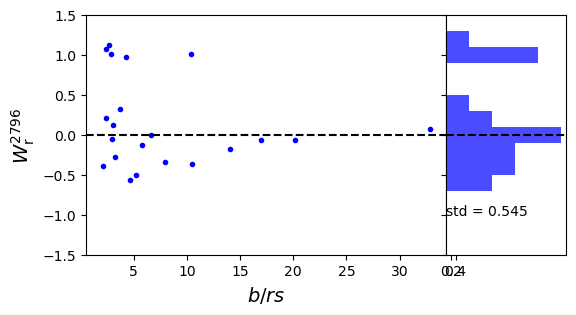

In [1682]:
fig = plt.figure(figsize=(6, 3), dpi = 100)
gs = fig.add_gridspec(1, 4, left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.0, hspace=0.0)
ax = fig.add_subplot(gs[0:1, 0:3])
ax_histy = fig.add_subplot(gs[0:1, 3:4])

X = np.linspace(0, 150, 200)

ax.scatter(sample_DM_profile_abs["B_KPC"]/sample_DM_profile_abs["rs_kpc"],\
            sample_DM_profile_abs["REW_2796"] - 10**gt.model(fit_b_rs['x'], sample_DM_profile_abs["B_KPC"]/sample_DM_profile_abs["rs_kpc"]),\
            marker = ".", c = "blue", label = "$\log(M_*/M_{\odot})$<9")
#ax.scatter(sample_DM_profile_noabs["B_KPC"]/sample_DM_profile_noabs["Rvir"],\
#            sample_DM_profile_noabs["REW_2796"] - 10**gt.model(fit_b_Rvir['x'], sample_DM_profile_noabs["B_KPC"]/sample_DM_profile_noabs["Rvir"]), \
#            c = "blue",  marker = ".")
ax.set_ylim((-1.5, 1.5))

std = np.std(sample_DM_profile_abs["REW_2796"] - 10**gt.model(fit_b_rs['x'], sample_DM_profile_abs["B_KPC"]/sample_DM_profile_abs["rs_kpc"]))
label = "std = " + str(np.round(std, 3))
ax_histy.hist(sample_DM_profile_abs["REW_2796"] - 10**gt.model(fit_b_rs['x'], sample_DM_profile_abs["B_KPC"]/sample_DM_profile_abs["rs_kpc"]),\
              bins = 15, range = (-1.5,1.5), \
             orientation='horizontal', color='blue', alpha = 0.7, label = label);
ax_histy.set_ylim((-1.5, 1.5))
ax_histy.set_yticklabels([])
ax_histy.set_xticks([0.2, 0.4])
ax_histy.text(0, -1, label)

plt.axhline(0, c = "black", linestyle = "--")
#plt.xlim((0, 200))
ax.axhline(0, color = "black", linestyle = "--")
ax.set_xlabel("$b/rs$", size = 14)
ax.set_ylabel("$W^{2796}_{\mathrm{r}}$", size = 14)
#plt.legend()

Text(0, 0.5, 'res $[\\AA]$')

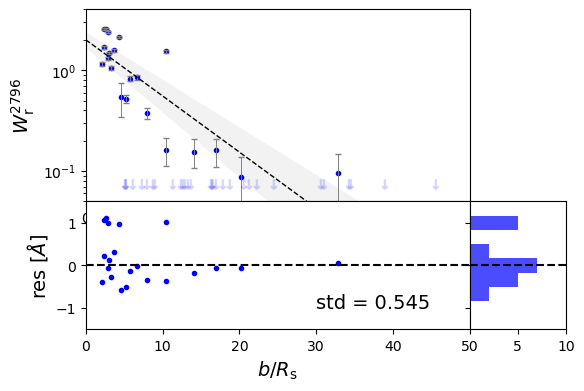

In [1683]:
fig = plt.figure(figsize=(6, 4), dpi = 100)
gs = fig.add_gridspec(5, 5, left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.0, hspace=0.0)
ax = fig.add_subplot(gs[0:3, 0:4])
ax_res = fig.add_subplot(gs[3:5, 0:4])
ax_histy = fig.add_subplot(gs[3:5, 4:5])

X = np.linspace(0, 50, 200)

ax.plot(X, 10**gt.model(fit_b_rs['x'], X), linewidth = 1.0, c = "black", \
         linestyle = "--", label = "best fit all", zorder = 3)
ax.fill_between(X, 10**gt.model(fit_b_rs_1sig_inf, X), 10**gt.model(fit_b_rs_1sig_sup, X), \
                 color = "gray", alpha = 0.1, linewidth = 0)

ax.scatter(sample_DM_profile_abs["B_KPC"]/sample_DM_profile_abs["rs_kpc"], sample_DM_profile_abs["REW_2796"], marker = ".", c = "blue",\
           label = "$\log(M_*/M_{\odot})$<9")
ax.errorbar(np.array(sample_DM_profile_abs["B_KPC"]/sample_DM_profile_abs["rs_kpc"]), np.array(sample_DM_profile_abs["REW_2796"]), \
             yerr = np.maximum(sample_DM_profile_abs["sig_REW_2796"], 0.05),\
            linestyle = "none", linewidth = 0.7, c = "grey", capsize=2, zorder = 1)
ax.scatter(sample_DM_profile_noabs["B_KPC"]/sample_DM_profile_noabs["rs_kpc"], sample_DM_profile_noabs["detection_limit_p75"], c = "blue",\
             marker = "$\downarrow$",  s = 50, alpha = 0.1)

ax.set_xlim((0, 50))
ax.set_ylim((0.05, 4))
ax.set_yscale("log")


ax_res.scatter(sample_DM_profile_abs["B_KPC"]/sample_DM_profile_abs["rs_kpc"],\
            sample_DM_profile_abs["REW_2796"] - 10**gt.model(fit_b_rs['x'], sample_DM_profile_abs["B_KPC"]/sample_DM_profile_abs["rs_kpc"]),\
            marker = ".", c = "blue", label = "$\log(M_*/M_{\odot})$<9")
#ax.scatter(sample_DM_profile_noabs["B_KPC"],\
#            sample_DM_profile_noabs["REW_2796"] - 10**gt.model(fit_b['x'], sample_DM_profile_noabs["B_KPC"]), \
#            c = "blue",  marker = ".")
ax_res.set_ylim((-1.5, 1.5))
ax_res.set_xlim((0, 50))


std = np.std(sample_DM_profile_abs["REW_2796"] - 10**gt.model(fit_b_rs['x'], sample_DM_profile_abs["B_KPC"]/sample_DM_profile_abs["rs_kpc"]))
label = "std = " + str(np.round(std, 3))
ax_histy.hist(sample_DM_profile_abs["REW_2796"] - 10**gt.model(fit_b_rs['x'], sample_DM_profile_abs["B_KPC"]/sample_DM_profile_abs["rs_kpc"]),\
              bins = 9, range = (-1.5,1.5), \
             orientation='horizontal', color='blue', alpha = 0.7, label = label);
ax_histy.set_ylim((-1.5, 1.5))
ax_histy.set_yticklabels([])
ax_histy.set_xticks([5, 10])
ax_res.text(30, -1, label, fontsize = 14)

plt.axhline(0, c = "black", linestyle = "--")
#plt.xlim((0, 200))
ax_res.axhline(0, color = "black", linestyle = "--")
ax_res.set_xlabel("$b/R_{\mathrm{s}}$", size = 14)
ax.set_ylabel("$W^{2796}_{\mathrm{r}}$", size = 14)
ax_res.set_ylabel("res $[\AA]$", size = 14)
#plt.legend()

### b/rs avec incertitudes horizontales

In [1692]:
x1 = np.array(isol_rs["B_KPC"]/isol_rs["rs_kpc"])
y1 = np.array(np.log10(np.maximum(isol_rs["REW_2796"],0.075))) 
sig_x1 = np.array(isol_rs["rs_kpc_err"]*isol_rs["B_KPC"]/(isol_rs["rs_kpc"]**2))
sig_y1 = np.array(np.maximum(isol_rs["sig_REW_2796"], 0.05)/np.maximum(isol_rs["REW_2796"],0.075)/np.log(10))

Paramètres ajustés: slope = 0.4932041323939904, intercept = -0.09598200606243253
Incertitudes sur les paramètres: slope_err = 0.07186007267349921, intercept_err = 0.018580349412945202


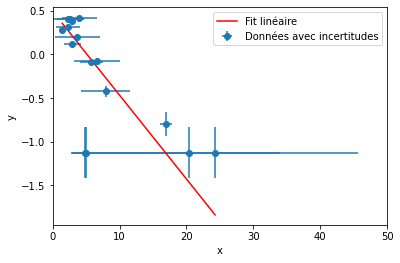

In [1693]:
# Configuration de l'ODR avec la fonction modèle, les données et les incertitudes
linear = odr.Model(gt.model)
data = odr.RealData(x1, y1, sx=sig_x1, sy=sig_y1)
odr_instance = odr.ODR(data, linear, beta0=[1., 1.])

# Exécuter l'ajustement
output_brs = odr_instance.run()

# Afficher les résultats
print("Paramètres ajustés: slope = {}, intercept = {}".format(output_brs.beta[0], output_brs.beta[1]))
print("Incertitudes sur les paramètres: slope_err = {}, intercept_err = {}".format(output_brs.sd_beta[0], output_brs.sd_beta[1]))

output_brs_1sig_inf = output_brs.beta - output_brs.sd_beta
output_brs_1sig_sup = output_brs.beta + output_brs.sd_beta

# Tracé des données et du fit
x_fit = np.linspace(min(x1), max(x1), 100)
y_fit = gt.model(output_brs.beta, x_fit)

plt.errorbar(x1, y1, xerr=sig_x1, yerr=sig_y1, fmt='o', label='Données avec incertitudes')
plt.plot(x_fit, y_fit, label='Fit linéaire', color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim((0, 50))
plt.legend()
#plt.show()


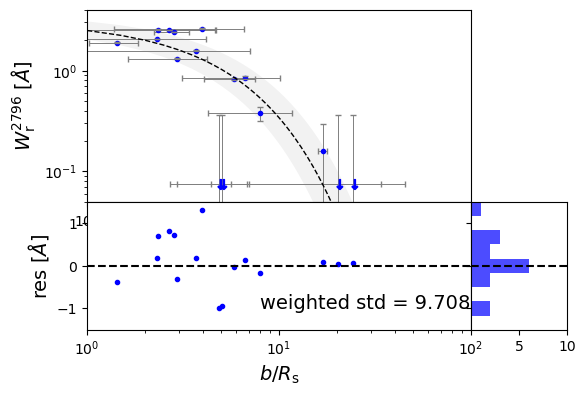

In [1694]:
fig = plt.figure(figsize=(6, 4), dpi = 100)
gs = fig.add_gridspec(5, 5, left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.0, hspace=0.0)
ax = fig.add_subplot(gs[0:3, 0:4])
ax_res = fig.add_subplot(gs[3:5, 0:4])
ax_histy = fig.add_subplot(gs[3:5, 4:5])

X = np.linspace(0, 100, 200)

ax.plot(X, 10**gt.model(output_brs.beta, X), linewidth = 1.0, c = "black", \
         linestyle = "--", label = "best fit all", zorder = 3)
ax.fill_between(X, 10**gt.model(output_brs_1sig_inf, X), 10**gt.model(output_brs_1sig_sup, X), \
                 color = "gray", alpha = 0.1, linewidth = 0)


ax.errorbar(x1, 10**y1, xerr = sig_x1, yerr = sig_y1,\
            linestyle = "none", linewidth = 0.7, c = "grey", capsize=2, zorder = 1)
ax.scatter(isol_rs_abs["B_KPC"]/isol_rs_abs["rs_kpc"], isol_rs_abs["REW_2796"], marker = ".", c = "blue",\
           label = "$\log(M_*/M_{\odot})$<9")
ax.scatter(isol_rs_noabs["B_KPC"]/isol_rs_noabs["rs_kpc"], isol_rs_noabs["detection_limit_p75"], c = "blue",\
             marker = "$\downarrow$",  s = 50, zorder = 2)

ax.set_xlim((1, 100))
ax.set_ylim((0.05, 4))
ax.set_yscale("log")


ax_res.scatter(x1,\
            10**y1 - 10**gt.model(output_brs.beta, x1),\
            marker = ".", c = "blue", label = "$\log(M_*/M_{\odot})$<9")
#ax.scatter(sample_DM_profile_noabs["B_KPC"],\
#            sample_DM_profile_noabs["REW_2796"] - 10**gt.model(fit_b['x'], sample_DM_profile_noabs["B_KPC"]), \
#            c = "blue",  marker = ".")
ax_res.set_ylim((-1.5, 1.5))
ax_res.set_xlim((1, 100))


std = np.std(isol_rs_abs["REW_2796"] - 10**gt.model(output_brs.beta, isol_rs_abs["B_KPC"]/isol_rs_abs["rs_kpc"]))
# Calcul des résidus pondérés
residuals = 10**y1 - 10**gt.model(output_brs.beta, x1)
weighted_residuals = residuals / np.maximum(isol_rs["sig_REW_2796"], 0.05)

residuals = isol_rs_abs["REW_2796"] - 10**gt.model(output_brs.beta, isol_rs_abs["B_KPC"]/isol_rs_abs["rs_kpc"])
weighted_residuals = residuals / np.maximum(isol_rs_abs["sig_REW_2796"], 0.05)

# Calcul de la déviation standard des résidus pondérés
dof = len(x1) - len(output_brs.beta)  # Degrés de liberté
weighted_residuals_std = np.sqrt(np.sum(weighted_residuals**2) / len(x1))

label = "weighted std = " + str(np.round(weighted_residuals_std, 3))
ax_histy.hist(10**y1 - 10**gt.model(output_brs.beta, x1),\
              bins = 9, range = (-1.5,1.5), \
             orientation='horizontal', color='blue', alpha = 0.7, label = label);
ax_histy.set_ylim((-1.5, 1.5))
ax_histy.set_yticklabels([])
ax_histy.set_xticks([5, 10])
ax_res.text(8, -1, label, fontsize = 14)

plt.axhline(0, c = "black", linestyle = "--")
#plt.xlim((0, 200))
ax_res.axhline(0, color = "black", linestyle = "--")
ax_res.set_xlabel("$b/R_{\mathrm{s}}$", size = 14)
ax.set_ylabel("$W^{2796}_{\mathrm{r}}$ $[\AA]$", size = 14)
ax_res.set_ylabel("res $[\AA]$", size = 14)
ax_res.set_xscale("log")
ax.set_xscale("log")
#plt.legend()

Text(8, 2, 'weighted std = 9.71')

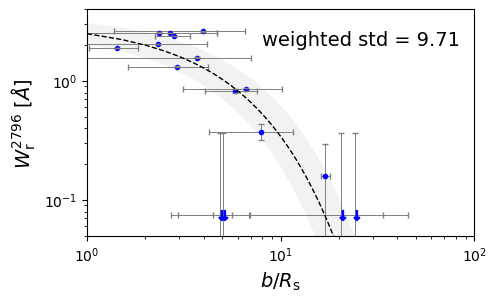

In [1695]:
plt.figure(figsize = (5,3), dpi = 100)
X = np.linspace(0, 100, 200)
plt.plot(X, 10**gt.model(output_brs.beta, X), linewidth = 1.0, c = "black", \
         linestyle = "--", label = "best fit all", zorder = 3)
plt.fill_between(X, 10**gt.model(output_brs_1sig_inf, X), 10**gt.model(output_brs_1sig_sup, X), \
                 color = "gray", alpha = 0.1, linewidth = 0)


plt.errorbar(x1, 10**y1, xerr = sig_x1, yerr = sig_y1,\
            linestyle = "none", linewidth = 0.7, c = "grey", capsize=2, zorder = 1)
plt.scatter(isol_rs_abs["B_KPC"]/isol_rs_abs["rs_kpc"], isol_rs_abs["REW_2796"], marker = ".", c = "blue",\
           label = "$\log(M_*/M_{\odot})$<9")
plt.scatter(isol_rs_noabs["B_KPC"]/isol_rs_noabs["rs_kpc"], isol_rs_noabs["detection_limit_p75"], c = "blue",\
             marker = "$\downarrow$",  s = 50, zorder = 2)

plt.xlim((1, 100))
plt.ylim((0.05, 4))
plt.yscale("log")
plt.xscale("log")
plt.xlabel("$b/R_{\mathrm{s}}$", size = 14)
plt.ylabel("$W^{2796}_{\mathrm{r}}$ $[\AA]$", size = 14)

residuals = isol_rs_abs["REW_2796"] - 10**gt.model(output_brs.beta, isol_rs_abs["B_KPC"]/isol_rs_abs["rs_kpc"])
weighted_residuals = residuals / np.maximum(isol_rs_abs["sig_REW_2796"], 0.05)

# Calcul de la déviation standard des résidus pondérés
dof = len(x1) - len(output_brs.beta)  # Degrés de liberté
weighted_residuals_std = np.sqrt(np.sum(weighted_residuals**2) / len(x1))

label = "weighted std = " + str(np.round(weighted_residuals_std, 2))
plt.text(8, 2, label, fontsize = 14)


(1.0, 80.0)

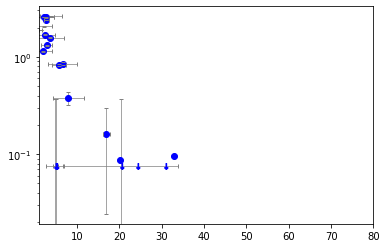

In [1566]:
plt.errorbar(x1, 10**y1, xerr = sig_x1, yerr = sig_y1,\
            linestyle = "none", linewidth = 0.7, c = "grey", capsize=2, zorder = 1)
plt.scatter(high_a_abs["B_KPC"]/high_a_abs["rs_kpc"], high_a_abs["REW_2796"], marker = "o", c = "blue",\
           label = "$\log(M_*/M_{\odot})$<9")
plt.scatter(high_a_noabs["B_KPC"]/high_a_noabs["rs_kpc"], high_a_noabs["detection_limit_p75"], c = "blue",\
             marker = "$\downarrow$", zorder = 2)
#plt.xscale("log")
plt.yscale("log")
plt.xlim((1, 80))

### b/rvir (from Behroozi)

In [1256]:
Mvir_1 = []
Mvir_2 = []
for i, r in sample_DM_profile_abs.iterrows():
    Mvir_1.append(gt.Behroozi_2019(r["sed_logMass"], r["Z"]))
                  
for i, r in sample_DM_profile_noabs.iterrows():
    Mvir_2.append(gt.Behroozi_2019(r["sed_logMass"], r["Z"]))
                  
Mvir_1 = 10**np.array(Mvir_1)
Mvir_2 = 10**np.array(Mvir_2)
Rvir_1 = gt.get_Rvir(Mvir_1, sample_DM_profile_abs["Z"])
Rvir_2 = gt.get_Rvir(Mvir_2, sample_DM_profile_noabs["Z"])

x1 = np.array(sample_DM_profile_abs["B_KPC"]/Rvir_1)
x2 = np.array(sample_DM_profile_noabs["B_KPC"]/Rvir_2)
k = x2>100
x2 = x2[k]
y1 = np.array(np.log10(sample_DM_profile_abs["REW_2796"]))
y2 = np.array(np.log10(sample_DM_profile_noabs["detection_limit_p75"]))
y2 = y2[k]
sig_y1 = np.array(np.maximum(sample_DM_profile_abs["sig_REW_2796"], 0.05)/sample_DM_profile_abs["REW_2796"]/np.log(10))
sig_y2 = np.array(np.ones(len(x2))*0.25)

In [1257]:
fit_b_Rvir = minimize(gt.logL_stats_total, np.array([0.9,-0.01, 0.1]), \
               args = (x1, y1, sig_y1, x2, y2, sig_y2), method = "BFGS")

fit_b_Rvir_1sig = np.diag(fit_b_Rvir.hess_inv)**0.5
fit_b_Rvir_1sig_inf = fit_b_Rvir['x'] - fit_b_Rvir_1sig
fit_b_Rvir_1sig_sup = fit_b_Rvir['x'] + fit_b_Rvir_1sig
fit_b_Rvir

      fun: 1.5569039999291492
 hess_inv: array([[ 0.01032944, -0.02324726,  0.00017588],
       [-0.02324726,  0.07418331, -0.00171623],
       [ 0.00017588, -0.00171623,  0.0018789 ]])
      jac: array([-3.45706940e-06, -5.03659248e-06,  5.12599945e-06])
  message: 'Optimization terminated successfully.'
     nfev: 124
      nit: 19
     njev: 31
   status: 0
  success: True
        x: array([ 0.45140668, -1.66992376,  0.23809735])

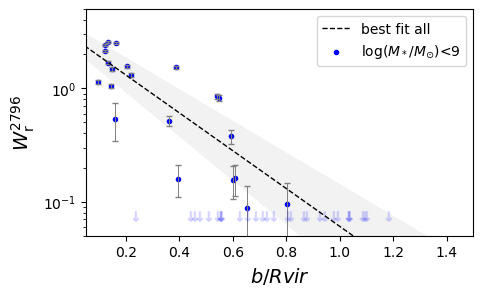

In [1259]:
X = np.linspace(0, 3, 200)
plt.figure(dpi = 100, figsize = (5, 3))

plt.plot(X, 10**gt.model(fit_b_Rvir['x'], X), linewidth = 1.0, c = "black", \
         linestyle = "--", label = "best fit all", zorder = 3)
plt.fill_between(X, 10**gt.model(fit_b_Rvir_1sig_inf, X), 10**gt.model(fit_b_Rvir_1sig_sup, X), \
                 color = "gray", alpha = 0.1, linewidth = 0)

plt.scatter(sample_DM_profile_abs["B_KPC"]/Rvir_1, \
            sample_DM_profile_abs["REW_2796"], marker = ".", c = "blue",\
           label = "$\log(M_*/M_{\odot})$<9")
plt.errorbar(np.array(sample_DM_profile_abs["B_KPC"]/Rvir_1),\
             np.array(sample_DM_profile_abs["REW_2796"]), \
             yerr = np.maximum(sample_DM_profile_abs["sig_REW_2796"], 0.05),\
            linestyle = "none", linewidth = 0.7, c = "grey", capsize=2, zorder = 1)
plt.scatter(sample_DM_profile_noabs["B_KPC"]/Rvir_2,\
            sample_DM_profile_noabs["detection_limit_p75"], c = "blue",\
             marker = "$\downarrow$",  s = 50, alpha = 0.1)

plt.xlim((0.05, 1.5))
plt.ylim((0.05, 5))
#plt.xscale("log")
plt.yscale("log")
plt.xlabel("$b/Rvir$", size = 14)
plt.ylabel("$W^{2796}_{\mathrm{r}}$", size = 14)
plt.legend()

Text(0, 0.5, '$W^{2796}_{\\mathrm{r}}$')

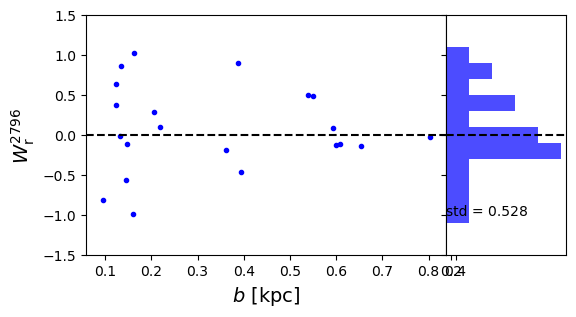

In [1260]:
fig = plt.figure(figsize=(6, 3), dpi = 100)
gs = fig.add_gridspec(1, 4, left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.0, hspace=0.0)
ax = fig.add_subplot(gs[0:1, 0:3])
ax_histy = fig.add_subplot(gs[0:1, 3:4])

X = np.linspace(0, 150, 200)

ax.scatter(sample_DM_profile_abs["B_KPC"]/Rvir_1,\
            sample_DM_profile_abs["REW_2796"] - 10**gt.model(fit_b_Rvir['x'], sample_DM_profile_abs["B_KPC"]/Rvir_1),\
            marker = ".", c = "blue", label = "$\log(M_*/M_{\odot})$<9")
#ax.scatter(sample_DM_profile_noabs["B_KPC"]/sample_DM_profile_noabs["Rvir"],\
#            sample_DM_profile_noabs["REW_2796"] - 10**gt.model(fit_b_Rvir['x'], sample_DM_profile_noabs["B_KPC"]/sample_DM_profile_noabs["Rvir"]), \
#            c = "blue",  marker = ".")
ax.set_ylim((-1.5, 1.5))

std = np.std(sample_DM_profile_abs["REW_2796"] - 10**gt.model(fit_b_Rvir['x'], sample_DM_profile_abs["B_KPC"]/Rvir_1))
label = "std = " + str(np.round(std, 3))
ax_histy.hist(sample_DM_profile_abs["REW_2796"] - 10**gt.model(fit_b_Rvir['x'], sample_DM_profile_abs["B_KPC"]/Rvir_1),\
              bins = 15, range = (-1.5,1.5), \
             orientation='horizontal', color='blue', alpha = 0.7, label = label);
ax_histy.set_ylim((-1.5, 1.5))
ax_histy.set_yticklabels([])
ax_histy.set_xticks([0.2, 0.4])
ax_histy.text(0, -1, label)

plt.axhline(0, c = "black", linestyle = "--")
#plt.xlim((0, 200))
ax.axhline(0, color = "black", linestyle = "--")
ax.set_xlabel("$b$ [kpc]", size = 14)
ax.set_ylabel("$W^{2796}_{\mathrm{r}}$", size = 14)
#plt.legend()

Text(0, 0.5, 'res $[\\AA]$')

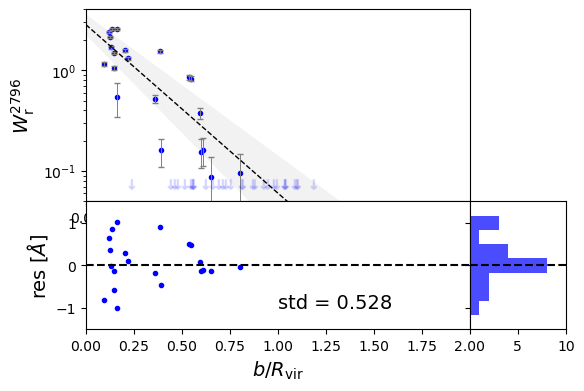

In [1264]:
fig = plt.figure(figsize=(6, 4), dpi = 100)
gs = fig.add_gridspec(5, 5, left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.0, hspace=0.0)
ax = fig.add_subplot(gs[0:3, 0:4])
ax_res = fig.add_subplot(gs[3:5, 0:4])
ax_histy = fig.add_subplot(gs[3:5, 4:5])

X = np.linspace(0, 5, 200)

ax.plot(X, 10**gt.model(fit_b_Rvir['x'], X), linewidth = 1.0, c = "black", \
         linestyle = "--", label = "best fit all", zorder = 3)
ax.fill_between(X, 10**gt.model(fit_b_Rvir_1sig_inf, X), 10**gt.model(fit_b_Rvir_1sig_sup, X), \
                 color = "gray", alpha = 0.1, linewidth = 0)

ax.scatter(sample_DM_profile_abs["B_KPC"]/Rvir_1, sample_DM_profile_abs["REW_2796"], marker = ".", c = "blue",\
           label = "$\log(M_*/M_{\odot})$<9")
ax.errorbar(np.array(sample_DM_profile_abs["B_KPC"]/Rvir_1), np.array(sample_DM_profile_abs["REW_2796"]), \
             yerr = np.maximum(sample_DM_profile_abs["sig_REW_2796"], 0.05),\
            linestyle = "none", linewidth = 0.7, c = "grey", capsize=2, zorder = 1)
ax.scatter(sample_DM_profile_noabs["B_KPC"]/Rvir_2, sample_DM_profile_noabs["detection_limit_p75"], c = "blue",\
             marker = "$\downarrow$",  s = 50, alpha = 0.1)
ax.set_xlim((0, 2))
ax.set_ylim((0.05, 4))
ax.set_yscale("log")


ax_res.scatter(sample_DM_profile_abs["B_KPC"]/Rvir_1,\
            sample_DM_profile_abs["REW_2796"] - 10**gt.model(fit_b_Rvir['x'], sample_DM_profile_abs["B_KPC"]/Rvir_1),\
            marker = ".", c = "blue", label = "$\log(M_*/M_{\odot})$<9")
#ax.scatter(sample_DM_profile_noabs["B_KPC"],\
#            sample_DM_profile_noabs["REW_2796"] - 10**gt.model(fit_b['x'], sample_DM_profile_noabs["B_KPC"]), \
#            c = "blue",  marker = ".")
ax_res.set_ylim((-1.5, 1.5))
ax_res.set_xlim((0, 2))


std = np.std(sample_DM_profile_abs["REW_2796"] - 10**gt.model(fit_b_Rvir['x'], sample_DM_profile_abs["B_KPC"]/Rvir_1))
label = "std = " + str(np.round(std, 3))
ax_histy.hist(sample_DM_profile_abs["REW_2796"] - 10**gt.model(fit_b_Rvir['x'], sample_DM_profile_abs["B_KPC"]/Rvir_1),\
              bins = 9, range = (-1.5,1.5), \
             orientation='horizontal', color='blue', alpha = 0.7, label = label);
ax_histy.set_ylim((-1.5, 1.5))
ax_histy.set_yticklabels([])
ax_histy.set_xticks([5, 10])
ax_res.text(1, -1, label, fontsize = 14)

plt.axhline(0, c = "black", linestyle = "--")
#plt.xlim((0, 200))
ax_res.axhline(0, color = "black", linestyle = "--")
ax_res.set_xlabel("$b/R_{\mathrm{vir}}$", size = 14)
ax.set_ylabel("$W^{2796}_{\mathrm{r}}$", size = 14)
ax_res.set_ylabel("res $[\AA]$", size = 14)
#plt.legend()

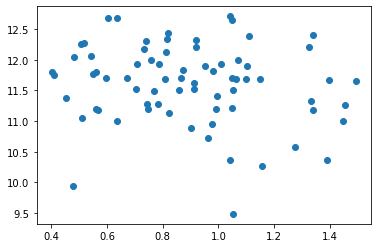

In [1267]:
plt.scatter(isol_9["Z"], isol_9["log_Mvir"])

Text(0, 0.5, '$W^{2796}_{\\mathrm{r}}$')

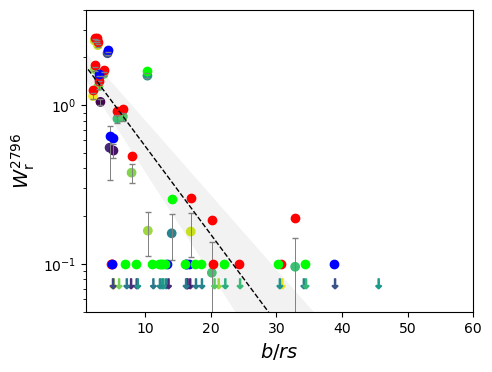

In [1078]:
X = np.linspace(0, 50, 200)
plt.figure(dpi = 100, figsize = (5, 4))

plt.plot(X, 10**gt.model(fit_b_rs['x'], X), linewidth = 1.0, c = "black", \
         linestyle = "--", label = "best fit all", zorder = 3)
plt.fill_between(X, 10**gt.model(fit_b_rs_1sig_inf, X), 10**gt.model(fit_b_rs_1sig_sup, X), \
                 color = "gray", alpha = 0.1, linewidth = 0)

plt.scatter(sample_DM_profile_abs["B_KPC"]/sample_DM_profile_abs["rs_kpc"], \
            sample_DM_profile_abs["REW_2796"], marker = "o",\
           label = "$\log(M_*/M_{\odot})$<9", c = sample_DM_profile_abs["alpha"], vmin = 0, vmax = 90)
plt.errorbar(np.array(sample_DM_profile_abs["B_KPC"]/sample_DM_profile_abs["rs_kpc"]),\
             np.array(sample_DM_profile_abs["REW_2796"]), \
             yerr = np.maximum(sample_DM_profile_abs["sig_REW_2796"], 0.05),\
            linestyle = "none", linewidth = 0.7, c = "grey", capsize=2, zorder = 1)
#plt.scatter(sample_DM_profile_noabs["B_KPC"]/sample_DM_profile_noabs["rs_kpc"],\
#            sample_DM_profile_noabs["detection_limit_p75"], c = "blue",\
#             marker = "$\downarrow$",  s = 50)
plt.scatter(sample_DM_profile_noabs["B_KPC"]/sample_DM_profile_noabs["rs_kpc"],\
            sample_DM_profile_noabs["detection_limit_p75"],\
             marker = "$\downarrow$",  s = 50, c = sample_DM_profile_noabs["alpha"], vmin = 0, vmax = 90)

plt.scatter(high_a["B_KPC"]/high_a["rs_kpc"], high_a["REW_2796"]+0.1, c = "r")
plt.scatter(low_a["B_KPC"]/low_a["rs_kpc"], low_a["REW_2796"]+0.1, c = "b")
plt.scatter(mid_a["B_KPC"]/mid_a["rs_kpc"], mid_a["REW_2796"]+0.1, c = "lime")


plt.xlim((1., 60))
plt.ylim((0.05, 4))
#plt.xscale("log")
plt.yscale("log")
plt.xlabel("$b/rs$", size = 14)
plt.ylabel("$W^{2796}_{\mathrm{r}}$", size = 14)
#plt.legend()

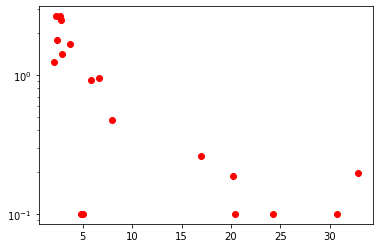

In [1285]:
plt.scatter(high_a["B_KPC"]/high_a["rs_kpc"], high_a["REW_2796"]+0.1, c = "r")
#plt.scatter(low_a["B_KPC"]/low_a["rs_kpc"], low_a["REW_2796"]+0.1, c = "b")

plt.yscale("log")

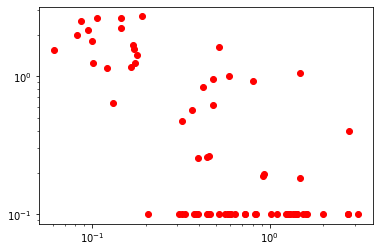

In [1292]:
plt.scatter(isol_9["B_KPC"]/isol_9["Rvir"], isol_9["REW_2796"]+0.1, c = "r")
plt.yscale("log")
plt.xscale("log")

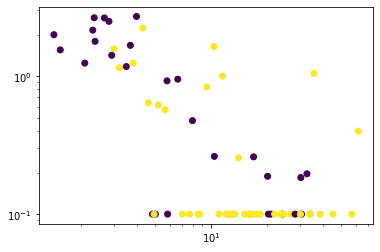

In [1296]:
plt.scatter(isol_9["B_KPC"]/isol_9["rs_kpc"], isol_9["REW_2796"]+0.1, c = isol_9["alpha"]<60)
#plt.scatter(low_a["B_KPC"]/low_a["rs_kpc"], low_a["REW_2796"]+0.1, c = "b")

plt.yscale("log")
plt.xscale("log")

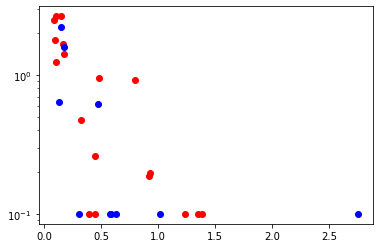

In [1104]:
plt.scatter(high_a["B_KPC"]/high_a["Rvir"], high_a["REW_2796"]+0.1, c = "r")
plt.scatter(low_a["B_KPC"]/low_a["Rvir"], low_a["REW_2796"]+0.1, c = "b")

plt.yscale("log")

## Idem only for high alpha

In [1106]:
incl = sample_DM_profile["inclination"]>30
al1 = sample_DM_profile["alpha"]>30
al2 = sample_DM_profile["alpha"]>60
kabs = sample_DM_profile["bool_absorption"] == 1
high_a = sample_DM_profile[incl & al2]
high_a_abs = sample_DM_profile[incl & al2 & kabs]
high_a_noabs = sample_DM_profile[incl & al2 & ~kabs]

x1 = np.array(high_a_abs["B_KPC"])
x2 = np.array(high_a_noabs["B_KPC"])
y1 = np.array(np.log10(high_a_abs["REW_2796"]))
y2 = np.array(np.log10(high_a_noabs["detection_limit_p75"]))
sig_y1 = np.array(np.maximum(high_a_abs["sig_REW_2796"], 0.05)/high_a_abs["REW_2796"]/np.log(10))
sig_y2 = np.array(np.ones(len(x2))*0.15)

In [1107]:
fit_b = minimize(gt.logL_stats_total, np.array([0.5,-0.01, 0.1]), \
               args = (x1, y1, sig_y1, x2, y2, sig_y2), method = "BFGS")

fit_b_1sig = np.diag(fit_b.hess_inv)**0.5
fit_b_1sig_inf = fit_b['x'] - fit_b_1sig
fit_b_1sig_sup = fit_b['x'] + fit_b_1sig
fit_b

      fun: 7.775002995457622
 hess_inv: array([[ 2.51165351e-02, -3.42069843e-04,  8.84379673e-04],
       [-3.42069843e-04,  6.62870976e-06, -3.93268286e-05],
       [ 8.84379673e-04, -3.93268286e-05,  5.00607978e-03]])
      jac: array([ 5.96046448e-08, -3.33786011e-06,  1.19209290e-07])
  message: 'Optimization terminated successfully.'
     nfev: 116
      nit: 24
     njev: 29
   status: 0
  success: True
        x: array([ 0.66770021, -0.0181702 ,  0.32827437])

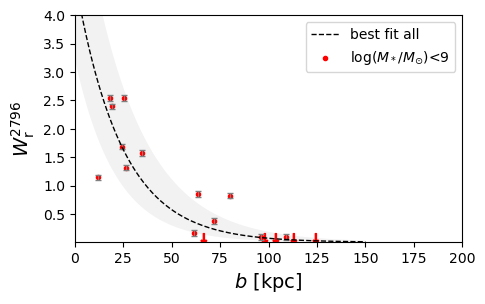

In [1112]:
X = np.linspace(0, 150, 200)
plt.figure(dpi = 100, figsize = (5, 3))

plt.plot(X, 10**gt.model(fit_b['x'], X), linewidth = 1.0, c = "black", \
         linestyle = "--", label = "best fit all", zorder = 3)
plt.fill_between(X, 10**gt.model(fit_b_1sig_inf, X), 10**gt.model(fit_b_1sig_sup, X), \
                 color = "gray", alpha = 0.1, linewidth = 0)

plt.scatter(high_a_abs["B_KPC"], high_a_abs["REW_2796"], marker = ".", c = "red",\
           label = "$\log(M_*/M_{\odot})$<9")
plt.errorbar(np.array(high_a_abs["B_KPC"]), np.array(high_a_abs["REW_2796"]), \
             yerr = np.maximum(high_a_abs["sig_REW_2796"], 0.05),\
            linestyle = "none", linewidth = 0.7, c = "grey", capsize=2, zorder = 1)
plt.scatter(high_a_noabs["B_KPC"], high_a_noabs["detection_limit_p75"], c = "red",\
             marker = "$\downarrow$",  s = 50)

plt.xlim((0, 200))
plt.ylim((0.01, 4))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("$b$ [kpc]", size = 14)
plt.ylabel("$W^{2796}_{\mathrm{r}}$", size = 14)
plt.legend()

**résidus et dispersion:**

Text(0, 0.5, '$W^{2796}_{\\mathrm{r}}$')

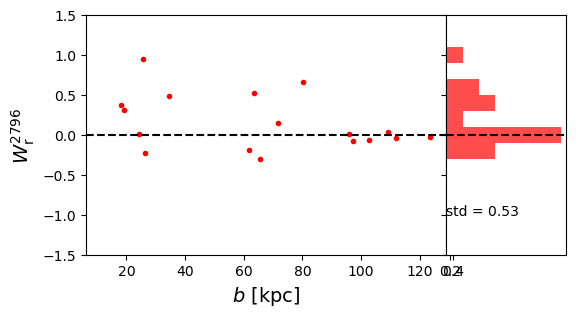

In [1132]:
fig = plt.figure(figsize=(6, 3), dpi = 100)
gs = fig.add_gridspec(1, 4, left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.0, hspace=0.0)
ax = fig.add_subplot(gs[0:1, 0:3])
ax_histy = fig.add_subplot(gs[0:1, 3:4])

X = np.linspace(0, 150, 200)

ax.scatter(high_a_abs["B_KPC"],\
            high_a_abs["REW_2796"] - 10**gt.model(fit_b['x'], high_a_abs["B_KPC"]),\
            marker = ".", c = "red", label = "$\log(M_*/M_{\odot})$<9")
ax.scatter(high_a_noabs["B_KPC"],\
            high_a_noabs["REW_2796"] - 10**gt.model(fit_b['x'], high_a_noabs["B_KPC"]), \
            c = "red",  marker = ".")
ax.set_ylim((-1.5, 1.5))

std = np.std(high_a["REW_2796"] - 10**gt.model(fit_b['x'], high_a["B_KPC"]))
label = "std = " + str(np.round(std, 3))
ax_histy.hist(high_a["REW_2796"] - 10**gt.model(fit_b['x'], high_a["B_KPC"]),\
              bins = 15, range = (-1.5,1.5), \
             orientation='horizontal', color='red', alpha = 0.7, label = label);
ax_histy.set_ylim((-1.5, 1.5))
ax_histy.set_yticklabels([])
ax_histy.set_xticks([0.2, 0.4])
ax_histy.text(0, -1, label)

plt.axhline(0, c = "black", linestyle = "--")
#plt.xlim((0, 200))
ax.axhline(0, color = "black", linestyle = "--")
ax.set_xlabel("$b$ [kpc]", size = 14)
ax.set_ylabel("$W^{2796}_{\mathrm{r}}$", size = 14)
#plt.legend()

b/Rvir

In [1124]:
x1 = np.array(high_a_abs["B_KPC"]/high_a_abs["Rvir"])
x2 = np.array(high_a_noabs["B_KPC"]/high_a_noabs["Rvir"])
y1 = np.array(np.log10(high_a_abs["REW_2796"]))
y2 = np.array(np.log10(high_a_noabs["detection_limit_p75"]))
sig_y1 = np.array(np.maximum(high_a_abs["sig_REW_2796"], 0.05)/high_a_abs["REW_2796"]/np.log(10))
sig_y2 = np.array(np.ones(len(x2))*0.15)

In [1125]:
fit_b_Rvir = minimize(gt.logL_stats_total, np.array([0.5,-0.01, 0.1]), \
               args = (x1, y1, sig_y1, x2, y2, sig_y2), method = "BFGS")

fit_b_Rvir_1sig = np.diag(fit_b_Rvir.hess_inv)**0.5
fit_b_Rvir_1sig_inf = fit_b_Rvir['x'] - fit_b_Rvir_1sig
fit_b_Rvir_1sig_sup = fit_b_Rvir['x'] + fit_b_Rvir_1sig
fit_b_Rvir

      fun: 11.477590882705723
 hess_inv: array([[ 0.03259693, -0.04802376,  0.00030611],
       [-0.04802376,  0.12558121, -0.00606898],
       [ 0.00030611, -0.00606898,  0.00940022]])
      jac: array([-3.57627869e-06, -2.14576721e-06,  2.38418579e-07])
  message: 'Optimization terminated successfully.'
     nfev: 92
      nit: 17
     njev: 23
   status: 0
  success: True
        x: array([ 0.31101563, -1.60063388,  0.44504328])

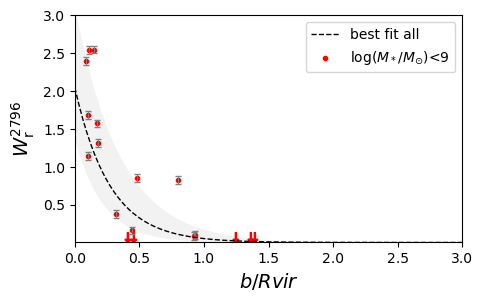

In [1126]:
X = np.linspace(0, 3, 200)
plt.figure(dpi = 100, figsize = (5, 3))

plt.plot(X, 10**gt.model(fit_b_Rvir['x'], X), linewidth = 1.0, c = "black", \
         linestyle = "--", label = "best fit all", zorder = 3)
plt.fill_between(X, 10**gt.model(fit_b_Rvir_1sig_inf, X), 10**gt.model(fit_b_Rvir_1sig_sup, X), \
                 color = "gray", alpha = 0.1, linewidth = 0)

plt.scatter(high_a_abs["B_KPC"]/high_a_abs["Rvir"], \
            high_a_abs["REW_2796"], marker = ".", c = "red",\
           label = "$\log(M_*/M_{\odot})$<9")
plt.errorbar(np.array(high_a_abs["B_KPC"]/high_a_abs["Rvir"]),\
             np.array(high_a_abs["REW_2796"]), \
             yerr = np.maximum(high_a_abs["sig_REW_2796"], 0.05),\
            linestyle = "none", linewidth = 0.7, c = "grey", capsize=2, zorder = 1)
plt.scatter(high_a_noabs["B_KPC"]/high_a_noabs["Rvir"],\
            high_a_noabs["detection_limit_p75"], c = "red",\
             marker = "$\downarrow$",  s = 50)

plt.xlim((0, 3))
plt.ylim((0.01, 3))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("$b/Rvir$", size = 14)
plt.ylabel("$W^{2796}_{\mathrm{r}}$", size = 14)
plt.legend()

Text(0, 0.5, '$W^{2796}_{\\mathrm{r}}$')

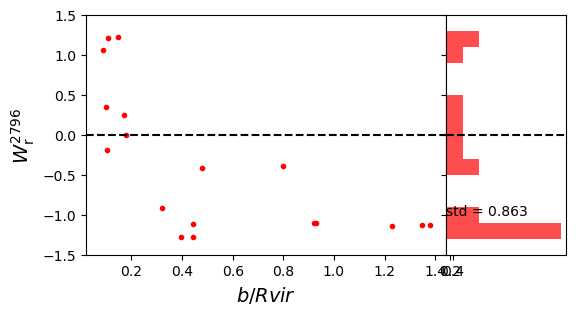

In [1140]:
fig = plt.figure(figsize=(6, 3), dpi = 100)
gs = fig.add_gridspec(1, 4, left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.0, hspace=0.0)
ax = fig.add_subplot(gs[0:1, 0:3])
ax_histy = fig.add_subplot(gs[0:1, 3:4])

X = np.linspace(0, 150, 200)

ax.scatter(high_a_abs["B_KPC"]/high_a_abs["Rvir"],\
            high_a_abs["REW_2796"] - 10**gt.model(fit_b_Rvir['x'], high_a_abs["B_KPC"]/high_a_abs["Rvir"]),\
            marker = ".", c = "red", label = "$\log(M_*/M_{\odot})$<9")
ax.scatter(high_a_noabs["B_KPC"]/high_a_noabs["Rvir"],\
            high_a_noabs["REW_2796"] - 10**gt.model(fit_b_Rvir['x'], high_a_noabs["B_KPC"]/high_a_noabs["Rvir"]), \
            c = "red",  marker = ".")
ax.set_ylim((-1.5, 1.5))

std = np.std(high_a["REW_2796"] - 10**gt.model(fit_b_Rvir['x'], high_a["B_KPC"]/high_a["Rvir"]))
label = "std = " + str(np.round(std, 3))
ax_histy.hist(high_a["REW_2796"] - 10**gt.model(fit_b_Rvir['x'], high_a["B_KPC"]/high_a["Rvir"]),\
              bins = 15, range = (-1.5,1.5), \
             orientation='horizontal', color='red', alpha = 0.7, label = label);
ax_histy.set_ylim((-1.5, 1.5))
ax_histy.set_yticklabels([])
ax_histy.set_xticks([0.2, 0.4])
ax_histy.text(0, -1, label)

plt.axhline(0, c = "black", linestyle = "--")
#plt.xlim((0, 200))
ax.axhline(0, color = "black", linestyle = "--")
ax.set_xlabel("$b/Rvir$", size = 14)
ax.set_ylabel("$W^{2796}_{\mathrm{r}}$", size = 14)
#plt.legend()

b/rs

In [1141]:
x1 = np.array(high_a_abs["B_KPC"]/high_a_abs["rs_kpc"])
x2 = np.array(high_a_noabs["B_KPC"]/high_a_noabs["rs_kpc"])
y1 = np.array(np.log10(high_a_abs["REW_2796"]))
y2 = np.array(np.log10(high_a_noabs["detection_limit_p75"]))
sig_y1 = np.array(np.maximum(high_a_abs["sig_REW_2796"], 0.05)/high_a_abs["REW_2796"]/np.log(10))
sig_y2 = np.array(np.ones(len(x2))*0.15)

In [1142]:
fit_b_Rvir = minimize(gt.logL_stats_total, np.array([0.5,-0.01, 0.1]), \
               args = (x1, y1, sig_y1, x2, y2, sig_y2), method = "BFGS")

fit_b_Rvir_1sig = np.diag(fit_b_Rvir.hess_inv)**0.5
fit_b_Rvir_1sig_inf = fit_b_Rvir['x'] - fit_b_Rvir_1sig
fit_b_Rvir_1sig_sup = fit_b_Rvir['x'] + fit_b_Rvir_1sig
fit_b_Rvir

      fun: 13.986005549444837
 hess_inv: array([[ 2.81929038e-02, -1.47111230e-03, -1.92821154e-03],
       [-1.47111230e-03,  1.70541143e-04, -7.99517766e-05],
       [-1.92821154e-03, -7.99517766e-05,  1.13278681e-02]])
      jac: array([-1.19209290e-07, -9.53674316e-07,  1.19209290e-07])
  message: 'Optimization terminated successfully.'
     nfev: 112
      nit: 22
     njev: 28
   status: 0
  success: True
        x: array([ 0.13167615, -0.05887589,  0.48596541])

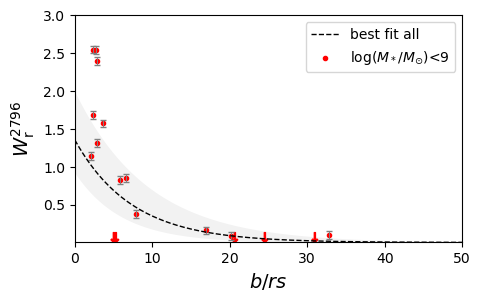

In [1143]:
X = np.linspace(0, 50, 200)
plt.figure(dpi = 100, figsize = (5, 3))

plt.plot(X, 10**gt.model(fit_b_Rvir['x'], X), linewidth = 1.0, c = "black", \
         linestyle = "--", label = "best fit all", zorder = 3)
plt.fill_between(X, 10**gt.model(fit_b_Rvir_1sig_inf, X), 10**gt.model(fit_b_Rvir_1sig_sup, X), \
                 color = "gray", alpha = 0.1, linewidth = 0)

plt.scatter(high_a_abs["B_KPC"]/high_a_abs["rs_kpc"], \
            high_a_abs["REW_2796"], marker = ".", c = "red",\
           label = "$\log(M_*/M_{\odot})$<9")
plt.errorbar(np.array(high_a_abs["B_KPC"]/high_a_abs["rs_kpc"]),\
             np.array(high_a_abs["REW_2796"]), \
             yerr = np.maximum(high_a_abs["sig_REW_2796"], 0.05),\
            linestyle = "none", linewidth = 0.7, c = "grey", capsize=2, zorder = 1)
plt.scatter(high_a_noabs["B_KPC"]/high_a_noabs["rs_kpc"],\
            high_a_noabs["detection_limit_p75"], c = "red",\
             marker = "$\downarrow$",  s = 50)

plt.xlim((0, 50))
plt.ylim((0.01, 3))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("$b/rs$", size = 14)
plt.ylabel("$W^{2796}_{\mathrm{r}}$", size = 14)
plt.legend()

Text(0, 0.5, '$W^{2796}_{\\mathrm{r}}$')

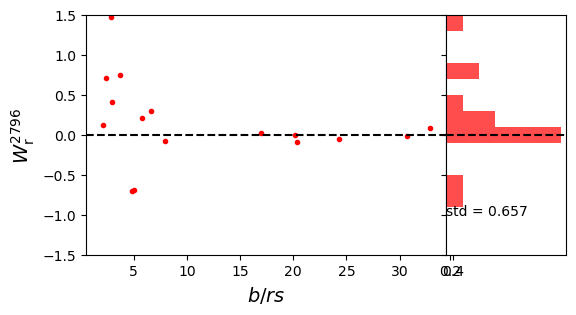

In [1144]:
fig = plt.figure(figsize=(6, 3), dpi = 100)
gs = fig.add_gridspec(1, 4, left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.0, hspace=0.0)
ax = fig.add_subplot(gs[0:1, 0:3])
ax_histy = fig.add_subplot(gs[0:1, 3:4])

X = np.linspace(0, 150, 200)

ax.scatter(high_a_abs["B_KPC"]/high_a_abs["rs_kpc"],\
            high_a_abs["REW_2796"] - 10**gt.model(fit_b_Rvir['x'], high_a_abs["B_KPC"]/high_a_abs["rs_kpc"]),\
            marker = ".", c = "red", label = "$\log(M_*/M_{\odot})$<9")
ax.scatter(high_a_noabs["B_KPC"]/high_a_noabs["rs_kpc"],\
            high_a_noabs["REW_2796"] - 10**gt.model(fit_b_Rvir['x'], high_a_noabs["B_KPC"]/high_a_noabs["rs_kpc"]), \
            c = "red",  marker = ".")
ax.set_ylim((-1.5, 1.5))

std = np.std(high_a["REW_2796"] - 10**gt.model(fit_b_Rvir['x'], high_a["B_KPC"]/high_a["rs_kpc"]))
label = "std = " + str(np.round(std, 3))
ax_histy.hist(high_a["REW_2796"] - 10**gt.model(fit_b_Rvir['x'], high_a["B_KPC"]/high_a["rs_kpc"]),\
              bins = 15, range = (-1.5,1.5), \
             orientation='horizontal', color='red', alpha = 0.7, label = label);
ax_histy.set_ylim((-1.5, 1.5))
ax_histy.set_yticklabels([])
ax_histy.set_xticks([0.2, 0.4])
ax_histy.text(0, -1, label)

plt.axhline(0, c = "black", linestyle = "--")
#plt.xlim((0, 200))
ax.axhline(0, color = "black", linestyle = "--")
ax.set_xlabel("$b/rs$", size = 14)
ax.set_ylabel("$W^{2796}_{\mathrm{r}}$", size = 14)
#plt.legend()

<ErrorbarContainer object of 3 artists>

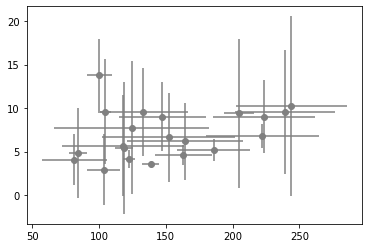

In [1238]:
plt.errorbar(np.array(sample_DM_profile_abs["Rvir"]), np.array(sample_DM_profile_abs["rs_kpc"]), \
            xerr = np.array(sample_DM_profile_abs["Rvir_err"]), yerr = np.array(sample_DM_profile_abs["rs_kpc_err"]),\
            linestyle = "none", marker = "o", color = "grey")

Text(0, 0.5, 'sed_logMass')

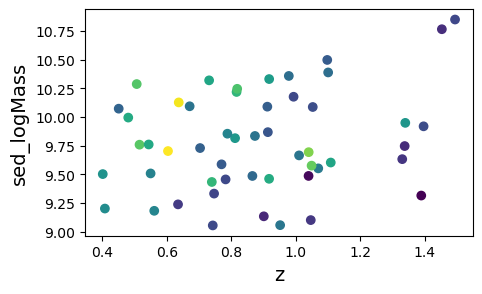

In [1284]:
plt.figure(figsize =  (5,3), dpi = 100)
plt.scatter(sample_DM_profile["Z"], sample_DM_profile["sed_logMass"], c = sample_DM_profile["Rvir"])
plt.xlabel("z", size = 14)
plt.ylabel("sed_logMass", size = 14)

Text(0, 0.5, 'Mdisk')

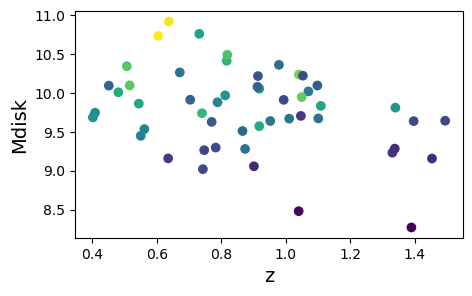

In [1280]:
plt.figure(figsize =  (5,3), dpi = 100)
plt.scatter(sample_DM_profile["Z"], sample_DM_profile["log_Mdisk"], c = sample_DM_profile["Rvir"])
plt.xlabel("z", size = 14)
plt.ylabel("Mdisk", size = 14)

Text(0, 0.5, 'Mvir')

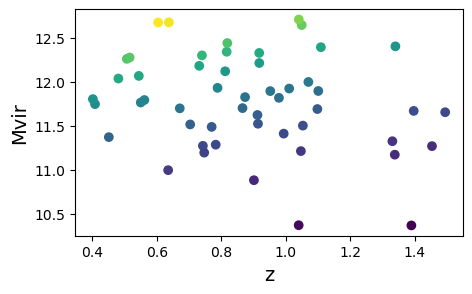

In [1281]:
plt.figure(figsize =  (5,3), dpi = 100)
plt.scatter(sample_DM_profile["Z"], sample_DM_profile["log_Mvir"], c = sample_DM_profile["Rvir"])
plt.xlabel("z", size = 14)
plt.ylabel("Mvir", size = 14)

Text(0, 0.5, 'Rvir')

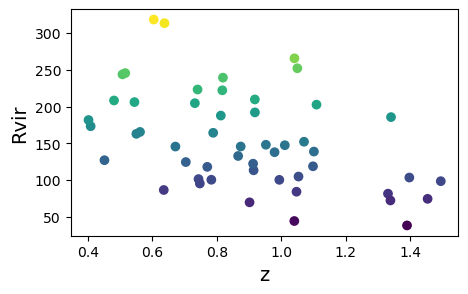

In [1282]:
plt.figure(figsize =  (5,3), dpi = 100)
plt.scatter(sample_DM_profile["Z"], sample_DM_profile["Rvir"], c = sample_DM_profile["Rvir"])
plt.xlabel("z", size = 14)
plt.ylabel("Rvir", size = 14)

Text(0, 0.5, 'rs')

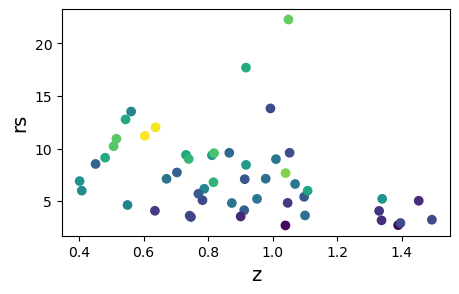

In [1274]:
plt.figure(figsize =  (5,3), dpi = 100)
plt.scatter(sample_DM_profile["Z"], sample_DM_profile["rs_kpc"], c = sample_DM_profile["Rvir"])
plt.xlabel("z", size = 14)
plt.ylabel("rs", size = 14)

Text(0.5, 0, 'Z')

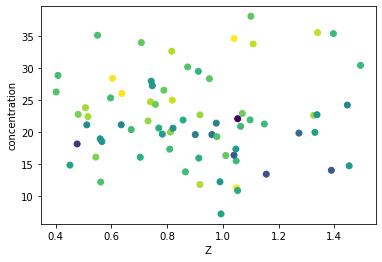

In [1105]:
plt.scatter(isol_9["Z"], isol_9["Rvir"]/isol_9["rs_kpc"], c = isol_9["log_Mvir"])
plt.ylabel("concentration")
plt.xlabel("Z")

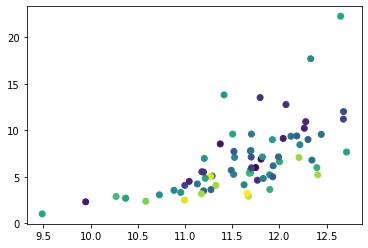

In [1094]:
plt.scatter(isol_9["log_Mvir"], isol_9["rs_kpc"], c = isol_9["Z"])

Text(0, 0.5, '$W^{2796}_{\\mathrm{r}}$ [$\\AA$]')

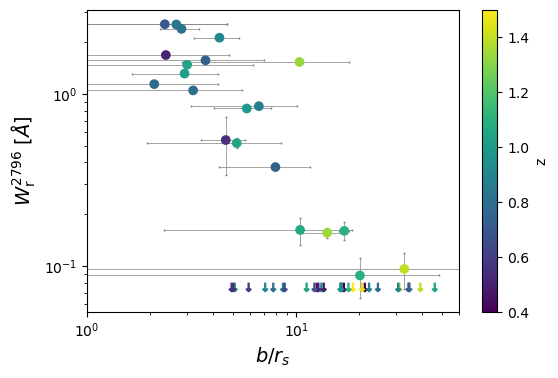

In [1062]:
plt.figure(figsize = (6,4), dpi = 100)
plt.errorbar(np.array(sample_DM_profile["B_KPC"]/sample_DM_profile["rs_kpc"]), np.array(sample_DM_profile["REW_2796"]),\
            xerr = np.array(sample_DM_profile["rs_kpc_err"]*sample_DM_profile["B_KPC"]/(sample_DM_profile["rs_kpc"]**2)),\
            yerr = np.array(sample_DM_profile["sig_REW_2796"]), \
             linestyle = "none", color = "gray", linewidth = 0.5, capsize = 1);
plt.scatter(np.array(sample_DM_profile_abs["B_KPC"]/sample_DM_profile_abs["rs_kpc"]), \
            np.array(sample_DM_profile_abs["REW_2796"]), \
            c = sample_DM_profile_abs["Z"], zorder = 3, vmin = 0.4, vmax = 1.5);
plt.colorbar(label = "z")
#plt.scatter(np.array(inner_slope["B_KPC"]/inner_slope["rs_kpc"]), np.array(inner_slope["REW_2796"]), \
#            c = "lime", zorder = 3);
plt.scatter(np.array(sample_DM_profile_noabs["B_KPC"]/sample_DM_profile_noabs["rs_kpc"]), \
            np.array(sample_DM_profile_noabs["detection_limit_p75"]), \
            c = sample_DM_profile_noabs["Z"], zorder = 3, vmin = 0.4, vmax = 1.5, marker = "$\downarrow$");
plt.xlim((1,60))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$b/r_s$", size = 14)
plt.ylabel("$W^{2796}_{\mathrm{r}}$ [$\AA$]", size= 14)

Text(0, 0.5, '$W^{2796}_{\\mathrm{r}}$')

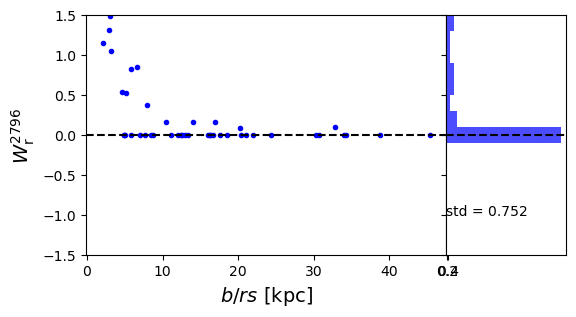

In [1063]:
fig = plt.figure(figsize=(6, 3), dpi = 100)
gs = fig.add_gridspec(1, 4, left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.0, hspace=0.0)
ax = fig.add_subplot(gs[0:1, 0:3])
ax_histy = fig.add_subplot(gs[0:1, 3:4])

X = np.linspace(0, 150, 200)

ax.scatter(sample_DM_profile_abs["B_KPC"]/sample_DM_profile_abs["rs_kpc"],\
            sample_DM_profile_abs["REW_2796"] - 10**gt.model(fit_b_Rvir['x'], sample_DM_profile_abs["B_KPC"]),\
            marker = ".", c = "blue", label = "$\log(M_*/M_{\odot})$<9")
ax.scatter(sample_DM_profile_noabs["B_KPC"]/sample_DM_profile_noabs["rs_kpc"],\
            sample_DM_profile_noabs["REW_2796"] - 10**gt.model(fit_b_Rvir['x'], sample_DM_profile_noabs["B_KPC"]), \
            c = "blue",  marker = ".")
ax.set_ylim((-1.5, 1.5))

std = np.std(sample_DM_profile["REW_2796"] - 10**gt.model(fit_b_Rvir['x'], sample_DM_profile["B_KPC"]/sample_DM_profile["rs_kpc"]))
label = "std = " + str(np.round(std, 3))
ax_histy.hist(sample_DM_profile["REW_2796"] - 10**gt.model(fit_b_Rvir['x'], sample_DM_profile["B_KPC"]/sample_DM_profile["rs_kpc"]),\
              bins = 15, range = (-1.5,1.5), \
             orientation='horizontal', color='blue', alpha = 0.7, label = label);
ax_histy.set_ylim((-1.5, 1.5))
ax_histy.set_yticklabels([])
ax_histy.set_xticks([0.2, 0.4])
ax_histy.text(0, -1, label)

plt.axhline(0, c = "black", linestyle = "--")
#plt.xlim((0, 200))
ax.axhline(0, color = "black", linestyle = "--")
ax.set_xlabel("$b/rs$ [kpc]", size = 14)
ax.set_ylabel("$W^{2796}_{\mathrm{r}}$", size = 14)
#plt.legend()

/home/cherrey/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, '$W^{2796}_{\\mathrm{r}}$')

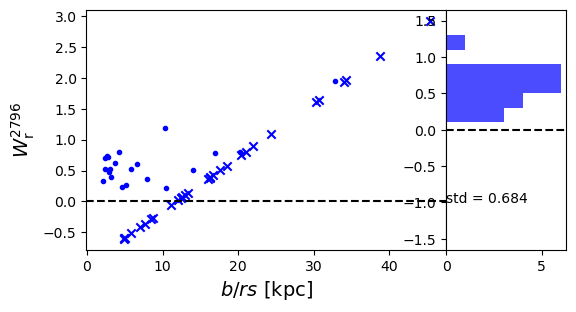

In [981]:
fig = plt.figure(figsize=(6, 3), dpi = 100)
gs = fig.add_gridspec(1, 4, left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.0, hspace=0.0)
ax = fig.add_subplot(gs[0:1, 0:3])
ax_histy = fig.add_subplot(gs[0:1, 3:4])

X = np.linspace(0, 150, 200)

ax.scatter(sample_DM_profile_abs["B_KPC"]/sample_DM_profile_abs["rs_kpc"],\
            np.log10(sample_DM_profile_abs["REW_2796"]) - gt.model(fit_b_rs['x'], sample_DM_profile_abs["B_KPC"]/sample_DM_profile_abs["rs_kpc"]),\
            marker = ".", c = "blue", label = "$\log(M_*/M_{\odot})$<9")
ax.scatter(sample_DM_profile_noabs["B_KPC"]/sample_DM_profile_noabs["rs_kpc"],\
            np.log10(sample_DM_profile_noabs["detection_limit_p75"]) - gt.model(fit_b_rs['x'], sample_DM_profile_noabs["B_KPC"]/sample_DM_profile_noabs["rs_kpc"]), \
            c = "blue",  marker = "x")
#ax.set_ylim((-1.5, 1.5))

std = np.std(sample_DM_profile_abs["REW_2796"] - 10**gt.model(fit_b_rs['x'], sample_DM_profile_abs["B_KPC"]/sample_DM_profile["rs_kpc"]))
label = "std = " + str(np.round(std, 3))
ax_histy.hist(np.log10(sample_DM_profile["REW_2796"]) - gt.model(fit_b_rs['x'], sample_DM_profile["B_KPC"]/sample_DM_profile["rs_kpc"]),\
              bins = 15, range = (-1.5,1.5), \
             orientation='horizontal', color='blue', alpha = 0.7, label = label);
#ax_histy.set_ylim((-1.5, 1.5))
#ax_histy.set_yticklabels([])
#ax_histy.set_xticks([0.2, 0.4])
ax_histy.text(0, -1, label)

plt.axhline(0, c = "black", linestyle = "--")
#plt.xlim((0, 200))
ax.axhline(0, color = "black", linestyle = "--")
ax.set_xlabel("$b/rs$ [kpc]", size = 14)
ax.set_ylabel("$W^{2796}_{\mathrm{r}}$", size = 14)
#plt.legend()

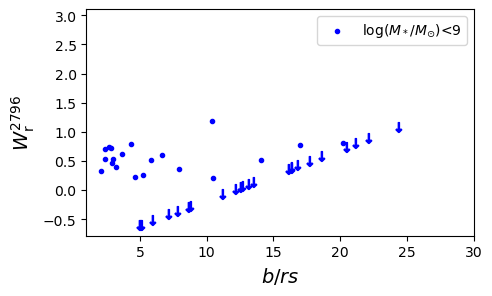

In [980]:
X = np.linspace(0, 50, 200)
plt.figure(dpi = 100, figsize = (5, 3))

plt.scatter(sample_DM_profile_abs["B_KPC"]/sample_DM_profile_abs["rs_kpc"], \
            np.log10(sample_DM_profile_abs["REW_2796"]) - gt.model(fit_b_rs['x'], sample_DM_profile_abs["B_KPC"]/sample_DM_profile_abs["rs_kpc"]), marker = ".", c = "blue",\
           label = "$\log(M_*/M_{\odot})$<9")
plt.scatter(sample_DM_profile_noabs["B_KPC"]/sample_DM_profile_noabs["rs_kpc"],\
            np.log10(sample_DM_profile_noabs["detection_limit_p75"]) - gt.model(fit_b_rs['x'], sample_DM_profile_noabs["B_KPC"]/sample_DM_profile_noabs["rs_kpc"]), c = "blue",\
             marker = "$\downarrow$",  s = 50)

plt.xlim((1, 30))
#plt.ylim((0.01, 4))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("$b/rs$", size = 14)
plt.ylabel("$W^{2796}_{\mathrm{r}}$", size = 14)
plt.legend()

# MgII Column densities

 ### comparison with Liang+16

Text(0, 0.5, 'logN')

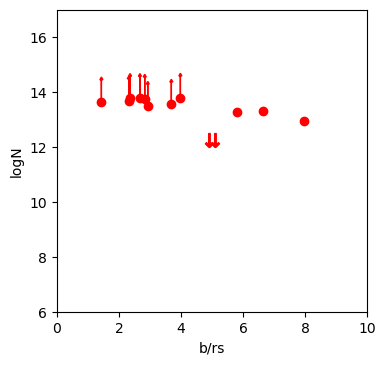

In [1793]:
plt.figure(figsize = (4, 4), dpi = 100)
saturated = isol_rs_abs[isol_rs_abs["REW_2796"]>1]
plt.scatter(isol_rs_abs["B_KPC"]/isol_rs_abs["rs_kpc"], isol_rs_abs["log_NMgII"], c = "red")
plt.scatter(isol_rs_noabs["B_KPC"]/isol_rs_noabs["rs_kpc"], isol_rs_noabs["log_NMgII_limit"], \
            marker = "$\downarrow$", c = "red", s = 100)
#plt.scatter(saturated["B_KPC"], saturated["log_NMgII"], marker = "$uparrow$", c = "blue", s = 100)
for x, y in zip(np.array(saturated["B_KPC"]/saturated["rs_kpc"]), np.array(saturated["log_NMgII"])):
    plt.arrow(x, y, 0, 0.8, head_width=0.1, head_length=0.1, fc='red', ec='red')
plt.ylim((6, 17))
plt.xlim((0, 10))
plt.xlabel("b/rs")
plt.ylabel("logN")

Text(0, 0.5, 'logN')

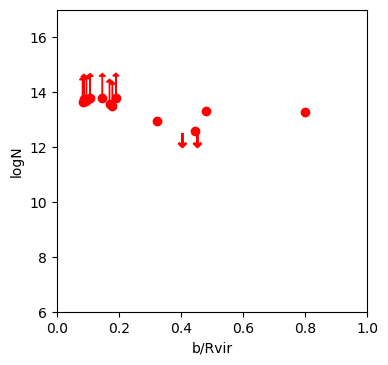

In [1825]:
plt.figure(figsize = (4, 4), dpi = 100)
saturated = isol_rs_abs[isol_rs_abs["REW_2796"]>1]
plt.scatter(isol_rs_abs["B_KPC"]/isol_rs_abs["Rvir"], isol_rs_abs["log_NMgII"], c = "red")
plt.scatter(isol_rs_noabs["B_KPC"]/isol_rs_noabs["Rvir"], isol_rs_noabs["log_NMgII_limit"], \
            marker = "$\downarrow$", c = "red", s = 100)
#plt.scatter(saturated["B_KPC"], saturated["log_NMgII"], marker = "$uparrow$", c = "blue", s = 100)
for x, y in zip(np.array(saturated["B_KPC"]/saturated["Rvir"]), np.array(saturated["log_NMgII"])):
    plt.arrow(x, y, 0, 0.8, head_width=0.02, head_length=0.1, fc='red', ec='red')
plt.ylim((6, 17))
plt.xlim((0, 1))
plt.xlabel("b/Rvir")
plt.ylabel("logN")

Text(0, 0.5, '$\\log N_{\\mathrm{MgII}}$ [cm$^{-2}$]')

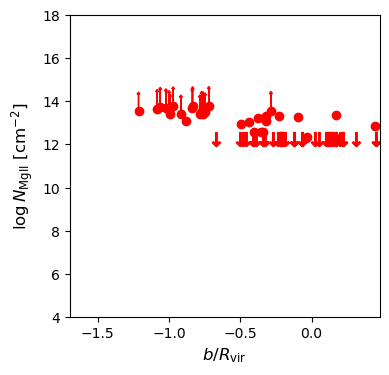

In [1839]:
plt.figure(figsize = (4, 4), dpi = 100)
saturated = isol_9_abs[isol_9_abs["REW_2796"]>1]

#plt.errorbar(np.array(isol_9["B_KPC"]/isol_9["Rvir"]), np.array(isol_9["log_NMgII"]), \
#             xerr = np.array(isol_9["Rvir_err"]*isol_9["B_KPC"]/(isol_9["Rvir"]**2)),\
#            linestyle = "none", linewidth = 0.7, c = "grey", capsize=2, zorder = 1)
plt.scatter(np.log10(isol_9_abs["B_KPC"]/isol_9_abs["Rvir"]), isol_9_abs["log_NMgII"], c = "red")
plt.scatter(np.log10(isol_9_noabs["B_KPC"]/isol_9_noabs["Rvir"]), isol_9_noabs["log_NMgII_limit"], \
            marker = "$\downarrow$", c = "red", s = 100)
#plt.scatter(saturated["B_KPC"], saturated["log_NMgII"], marker = "$uparrow$", c = "blue", s = 100)
for x, y in zip(np.array(np.log10(saturated["B_KPC"]/saturated["Rvir"])), np.array(saturated["log_NMgII"])):
    plt.arrow(x, y, 0, 0.8, head_width=0.02, head_length=0.1, fc='red', ec='red')
plt.ylim((4, 18))
plt.xlim((-1.6989700043360187, 0.4771))
plt.xlabel("$b/R_{\mathrm{vir}}$", size = 12)
plt.ylabel("$\log N_{\mathrm{MgII}}$ [cm$^{-2}$]", size = 12)
#plt.legend()

In [1836]:
np.log10(3)

0.47712125471966244

Text(0, 0.5, 'logN')

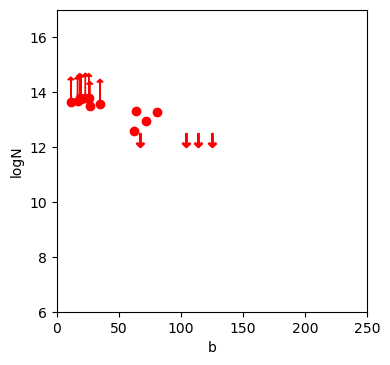

In [1813]:
plt.figure(figsize = (4, 4), dpi = 100)
saturated = isol_rs_abs[isol_rs_abs["REW_2796"]>1]
plt.scatter(isol_rs_abs["B_KPC"], isol_rs_abs["log_NMgII"], c = "red")
plt.scatter(isol_rs_noabs["B_KPC"], isol_rs_noabs["log_NMgII_limit"], \
            marker = "$\downarrow$", c = "red", s = 100)
#plt.scatter(saturated["B_KPC"], saturated["log_NMgII"], marker = "$uparrow$", c = "blue", s = 100)
for x, y in zip(np.array(saturated["B_KPC"]), np.array(saturated["log_NMgII"])):
    plt.arrow(x, y, 0, 0.8, head_width=5, head_length=0.1, fc='red', ec='red')
plt.ylim((6, 17))
plt.xlim((0, 250))
plt.xlabel("b")
plt.ylabel("logN")

### Comparison with Ji 2020 (FIRE 2)

In [1812]:
Ji_2020_MHD = pd.read_csv("simu_data/Ji_2020_MHD.csv")
Ji_2020_CR = pd.read_csv("simu_data/Ji_2020_CR.csv")

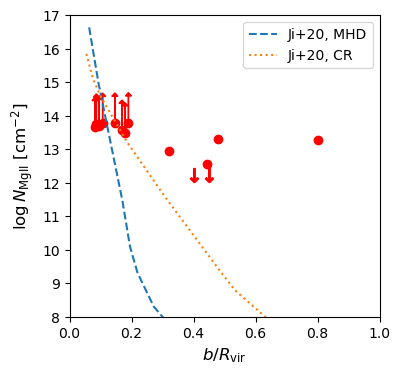

In [1811]:
plt.figure(figsize = (4, 4), dpi = 100)
saturated = isol_rs_abs[isol_rs_abs["REW_2796"]>1]
plt.plot(np.array(Ji_2020_MHD["R_Rvir"]), np.array(Ji_2020_MHD["log_NMgII"]), \
         linestyle = "--", label = "Ji+20, MHD")
plt.plot(np.array(Ji_2020_CR["R_Rvir"]), np.array(Ji_2020_CR["log_NMgII"]), \
         linestyle = "dotted", label = "Ji+20, CR")
plt.scatter(isol_rs_abs["B_KPC"]/isol_rs_abs["Rvir"], isol_rs_abs["log_NMgII"], c = "red")
plt.scatter(isol_rs_noabs["B_KPC"]/isol_rs_noabs["Rvir"], isol_rs_noabs["log_NMgII_limit"], \
            marker = "$\downarrow$", c = "red", s = 100)
#plt.scatter(saturated["B_KPC"], saturated["log_NMgII"], marker = "$uparrow$", c = "blue", s = 100)
for x, y in zip(np.array(saturated["B_KPC"]/saturated["Rvir"]), np.array(saturated["log_NMgII"])):
    plt.arrow(x, y, 0, 0.8, head_width=0.02, head_length=0.1, fc='red', ec='red')
plt.ylim((8, 17))
plt.xlim((0, 1))
plt.xlabel("$b/R_{\mathrm{vir}}$", size = 12)
plt.ylabel("$\log N_{\mathrm{MgII}}$ [cm$^{-2}$]", size = 12)
plt.legend()

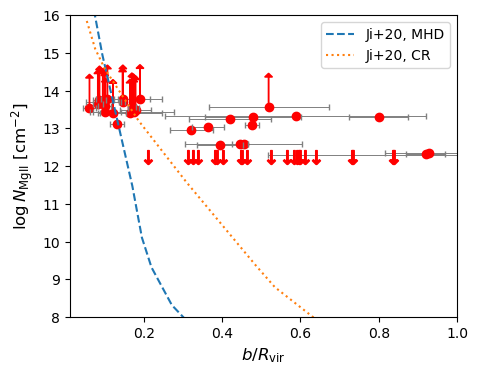

In [1824]:
sig_x1 = np.array(isol_rs["rs_kpc_err"]*isol_rs["B_KPC"]/(isol_rs["rs_kpc"]**2))
sig_y1 = np.array(np.maximum(isol_rs["sig_REW_2796"], 0.05)/np.maximum(isol_rs["REW_2796"],0.075)/np.log(10))


plt.figure(figsize = (5, 4), dpi = 100)
saturated = isol_9_abs[isol_9_abs["REW_2796"]>1]
plt.plot(np.array(Ji_2020_MHD["R_Rvir"]), np.array(Ji_2020_MHD["log_NMgII"]), \
         linestyle = "--", label = "Ji+20, MHD")
plt.plot(np.array(Ji_2020_CR["R_Rvir"]), np.array(Ji_2020_CR["log_NMgII"]), \
         linestyle = "dotted", label = "Ji+20, CR")
plt.errorbar(np.array(isol_9["B_KPC"]/isol_9["Rvir"]), np.array(isol_9["log_NMgII"]), \
             xerr = np.array(isol_9["Rvir_err"]*isol_9["B_KPC"]/(isol_9["Rvir"]**2)),\
            linestyle = "none", linewidth = 0.7, c = "grey", capsize=2, zorder = 1)
plt.scatter(isol_9_abs["B_KPC"]/isol_9_abs["Rvir"], isol_9_abs["log_NMgII"], c = "red")
plt.scatter(isol_9_noabs["B_KPC"]/isol_9_noabs["Rvir"], isol_9_noabs["log_NMgII_limit"], \
            marker = "$\downarrow$", c = "red", s = 100)
#plt.scatter(saturated["B_KPC"], saturated["log_NMgII"], marker = "$uparrow$", c = "blue", s = 100)
for x, y in zip(np.array(saturated["B_KPC"]/saturated["Rvir"]), np.array(saturated["log_NMgII"])):
    plt.arrow(x, y, 0, 0.8, head_width=0.02, head_length=0.1, fc='red', ec='red')
plt.ylim((8, 16))
plt.xlim((0.01, 1))
plt.xlabel("$b/R_{\mathrm{vir}}$", size = 12)
plt.ylabel("$\log N_{\mathrm{MgII}}$ [cm$^{-2}$]", size = 12)
plt.legend()

Text(8, 2, 'weighted std = 9.71')

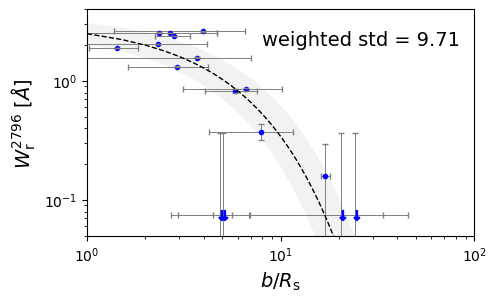

In [1769]:
plt.figure(figsize = (5,3), dpi = 100)
X = np.linspace(0, 100, 200)
plt.plot(X, 10**gt.model(output_brs.beta, X), linewidth = 1.0, c = "black", \
         linestyle = "--", label = "best fit all", zorder = 3)
plt.fill_between(X, 10**gt.model(output_brs_1sig_inf, X), 10**gt.model(output_brs_1sig_sup, X), \
                 color = "gray", alpha = 0.1, linewidth = 0)


plt.errorbar(x1, 10**y1, xerr = sig_x1, yerr = sig_y1,\
            linestyle = "none", linewidth = 0.7, c = "grey", capsize=2, zorder = 1)
plt.scatter(isol_rs_abs["B_KPC"]/isol_rs_abs["rs_kpc"], isol_rs_abs["REW_2796"], marker = ".", c = "blue",\
           label = "$\log(M_*/M_{\odot})$<9")
plt.scatter(isol_rs_noabs["B_KPC"]/isol_rs_noabs["rs_kpc"], isol_rs_noabs["detection_limit_p75"], c = "blue",\
             marker = "$\downarrow$",  s = 50, zorder = 2)

plt.xlim((1, 100))
plt.ylim((0.05, 4))
plt.yscale("log")
plt.xscale("log")
plt.xlabel("$b/R_{\mathrm{s}}$", size = 14)
plt.ylabel("$W^{2796}_{\mathrm{r}}$ $[\AA]$", size = 14)

residuals = isol_rs_abs["REW_2796"] - 10**gt.model(output_brs.beta, isol_rs_abs["B_KPC"]/isol_rs_abs["rs_kpc"])
weighted_residuals = residuals / np.maximum(isol_rs_abs["sig_REW_2796"], 0.05)

# Calcul de la déviation standard des résidus pondérés
dof = len(x1) - len(output_brs.beta)  # Degrés de liberté
weighted_residuals_std = np.sqrt(np.sum(weighted_residuals**2) / len(x1))

label = "weighted std = " + str(np.round(weighted_residuals_std, 2))
plt.text(8, 2, label, fontsize = 14)


In [ ]:
dv = cdz/(1+z)
dz = dv*(1+z)/c

In [1846]:
dz = 0.5*1e6*2.5/const.c.value
dz

0.004169551189976901

In [1847]:
0.5/dz

119.91698319999999

Text(0, 0.5, 'logMdisk')

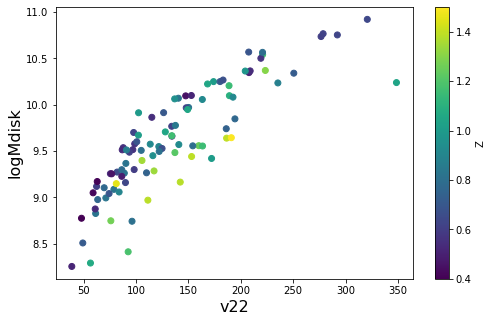

In [213]:
plt.figure(figsize = (8,5))
#plt.errorbar(np.array(T["Z"]), np.array(T["rs_kpc"]), \
#            yerr = np.array(T["log_Mvir_err"]), \
#            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5)
vvv = np.linspace(50, 300, 50)
mmm = np.log10(8*vvv**4)
plt.scatter(T["v22"], T["log_Mdisk"], c = T["Z"], zorder = 2, vmax = 1.5, vmin = 0.4)
#plt.plot(vvv, mmm)
plt.xlabel("v22", size = 16)
plt.colorbar(label = "Z")
plt.ylabel("logMdisk", size = 16)

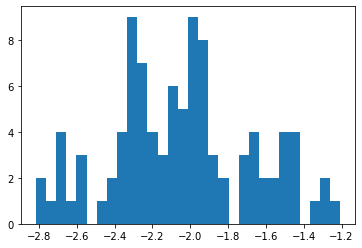

In [217]:
plt.hist(T["log_X"], bins = 30);

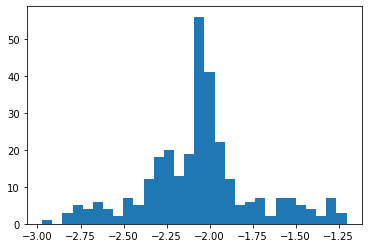

In [218]:
plt.hist(R_04_15_zconf1["log_X"], bins = 30);

In [219]:
p1 = T["log_X"]> -2.1
p2 = T["log_X"]< -1.9
p3 = T["Z"]< 1
Xpeak = T[p1 & p2 & p3]

(0.0, 1.4)

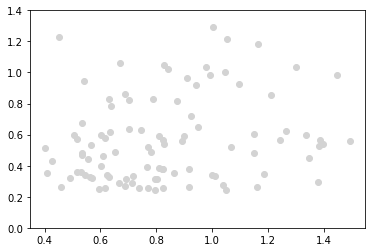

In [220]:
current = Xpeak[Xpeak["ID"] == 11127]
plt.scatter(T["Z"], T["gamma"], c = "lightgray")
#plt.scatter(Xpeak["Z"], Xpeak["gamma"])
plt.scatter(current["Z"], current["gamma"], c = "r")
plt.ylim((0,1.4))

In [221]:
Xpeak["ID"].unique()

array([11111, 11114, 11124, 12093, 12108, 13080, 13081, 13083, 13086,
       13128, 17035, 18053, 18088, 25068, 26095, 27041, 28055, 31100])

Text(0, 0.5, 'inner slope')

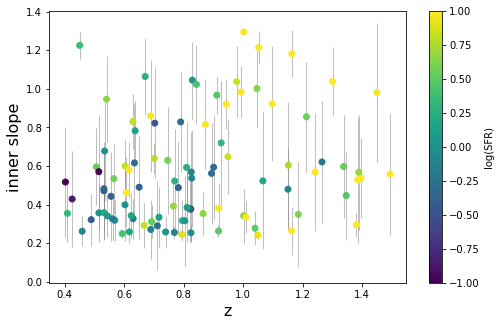

In [222]:
plt.figure(figsize = (8,5))
plt.errorbar(np.array(T["Z"]), np.array(T["gamma"]), \
            yerr = np.array(T["gamma_err"]), \
            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5)
plt.scatter(T["Z"], T["gamma"], c = T["logSFR"], zorder = 2, vmin = -1, vmax = 1)
plt.xlabel("z", size = 16)
plt.colorbar(label = "log(SFR)")
plt.ylabel("inner slope", size = 16)

In [223]:
len(T)

97

Text(0, 0.5, 'sed log(M*)')

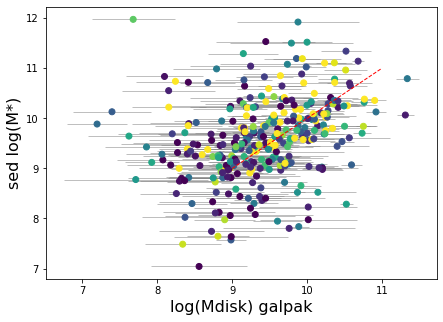

In [224]:
plt.figure(figsize = (7,5))
plt.errorbar(np.array(R_04_15_zconf1["log_Mdisk"]), np.array(R_04_15_zconf1["sed_logMass"]), \
            xerr = np.array(R_04_15_zconf1["log_Mdisk_err"]), \
            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5)
plt.scatter(R_04_15_zconf1["log_Mdisk"], R_04_15_zconf1["sed_logMass"], c = R_04_15_zconf1["snr_eff"],\
            zorder = 2, vmin = 1, vmax = 8)
plt.plot([9,11], [9,11], c = 'r', linestyle = "--", linewidth = 1)
plt.xlabel("log(Mdisk) galpak", size = 16)
plt.ylabel("sed log(M*)", size = 16)

(array([161.,  65.,  43.,  17.,  12.,   0.,   5.,   2.,   1.,   3.]),
 array([ 0.80127945,  1.86760453,  2.93392961,  4.00025469,  5.06657977,
         6.13290485,  7.19922993,  8.26555501,  9.33188009, 10.39820517,
        11.46453024]),
 <BarContainer object of 10 artists>)

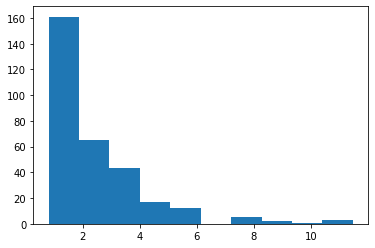

In [225]:
plt.hist(R_04_15_zconf1["radius"])

(0.0, 50.0)

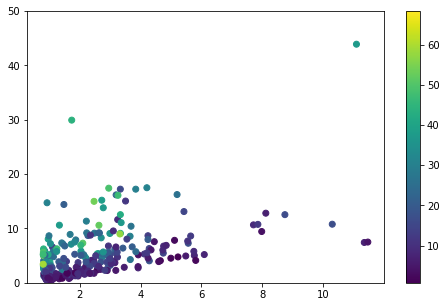

In [226]:
plt.figure(figsize = (8,5))
plt.scatter(R_04_15_zconf1["radius"], R_04_15_zconf1["snr_eff"], c = R_04_15_zconf1["snr_from_src"])
plt.colorbar()
plt.ylim((0,50))

Text(0, 0.5, 'inner slope')

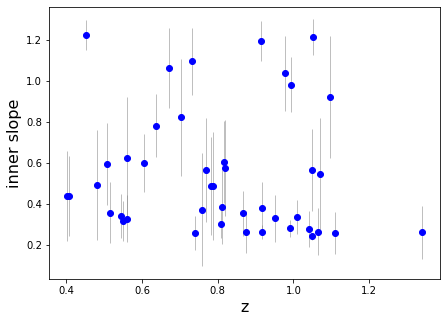

In [227]:
plt.figure(figsize = (7,5))
plt.errorbar(np.array(inner_slope["Z"]), np.array(inner_slope["gamma"]), \
            yerr = np.array(inner_slope["gamma_err"]), \
            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5)
plt.scatter(inner_slope["Z"], inner_slope["gamma"], color = "blue", zorder = 2)
plt.xlabel("z", size = 16)
plt.ylabel("inner slope", size = 16)

Text(0, 0.5, 'sed log(M*)')

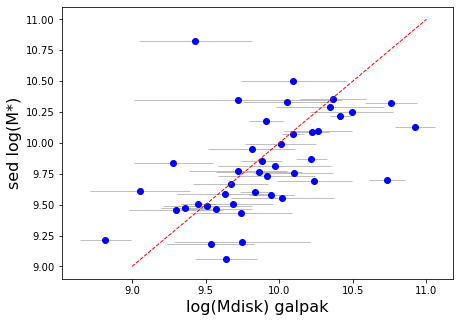

In [228]:
plt.figure(figsize = (7,5))
plt.errorbar(np.array(inner_slope["log_Mdisk"]), np.array(inner_slope["sed_logMass"]), \
            xerr = np.array(inner_slope["log_Mdisk_err"]), \
            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5)
plt.scatter(inner_slope["log_Mdisk"], inner_slope["sed_logMass"], color = "blue", zorder = 2)
plt.plot([9,11], [9,11], c = 'r', linestyle = "--", linewidth = 1)
plt.xlabel("log(Mdisk) galpak", size = 16)
plt.ylabel("sed log(M*)", size = 16)

Text(0, 0.5, 'REW 2796')

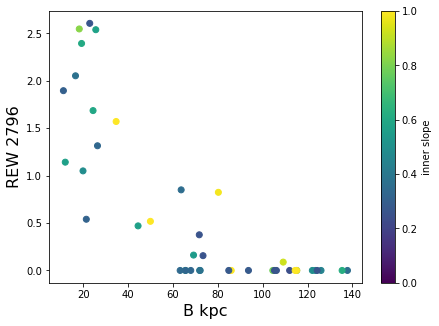

In [229]:
plt.figure(figsize = (7,5))
#plt.errorbar(np.array(inner_slope["B_KPC"]), np.array(inner_slope["REW_2796"]), \
#            yerr = np.array(inner_slope["gamma_err"]), \
#            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5)
plt.scatter(inner_slope["B_KPC"], inner_slope["REW_2796"], \
            c = inner_slope["gamma"], vmin = 0, vmax = 1, zorder = 2)
plt.colorbar(label = "inner slope")
plt.xlabel("B kpc", size = 16)
plt.ylabel("REW 2796", size = 16)

In [230]:
low_gamma = inner_slope[inner_slope["gamma"]<0.5]
high_gamma = inner_slope[inner_slope["gamma"]>0.5]

Text(0, 0.5, 'REW 2796')

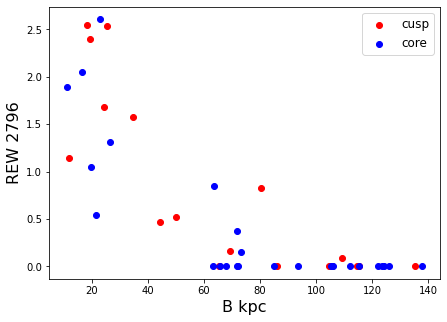

In [231]:
plt.figure(figsize = (7,5))
#plt.errorbar(np.array(inner_slope["B_KPC"]), np.array(inner_slope["REW_2796"]), \
#            yerr = np.array(inner_slope["gamma_err"]), \
#            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5)
plt.scatter(high_gamma["B_KPC"], high_gamma["REW_2796"], \
            c = "r", zorder = 2, label = "cusp")
plt.scatter(low_gamma["B_KPC"], low_gamma["REW_2796"], \
            c = "b", zorder = 2, label = "core")
#plt.colorbar(label = "inner slope")
plt.legend(fontsize = 12)
plt.xlabel("B kpc", size = 16)
plt.ylabel("REW 2796", size = 16)

(0.0, 150.0)

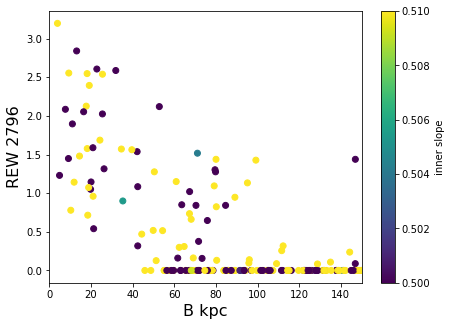

In [232]:
plt.figure(figsize = (7,5))
#plt.errorbar(np.array(inner_slope["B_KPC"]), np.array(inner_slope["REW_2796"]), \
#            yerr = np.array(inner_slope["gamma_err"]), \
#            linestyle = "none", color = "gray", zorder = 1, linewidth = 0.5)
plt.scatter(R_04_15_zconf1["B_KPC"], R_04_15_zconf1["REW_2796"], \
            c = R_04_15_zconf1["gamma"], vmin = 0.5, vmax = 0.51, zorder = 2)
plt.colorbar(label = "inner slope")
plt.xlabel("B kpc", size = 16)
plt.ylabel("REW 2796", size = 16)
plt.xlim((0,150))

In [233]:
isol_9["ID"].unique()

array([11097, 11117, 12108, 13063, 13088, 13128, 13129, 14109, 14112,
       14148, 15003, 15040, 16063, 16070, 16079, 16093, 17035, 17066,
       17072, 17080, 17102, 18049, 18063, 18097, 19072, 19103, 20052,
       20064, 20066, 20077, 21107, 21111, 21117, 21126, 21127, 22047,
       22048, 22066, 23086, 23092, 23102, 23120, 23122, 24038, 24044,
       25087, 25095, 26056, 26095, 27094, 27102, 28002, 28055, 28056,
       29002, 29059, 29066, 29073, 29077, 29084, 30015, 30047, 30060,
       30070, 31005, 31079, 31087, 31100, 31107, 32055, 32059, 32081])

Text(0, 0.5, 'inner slope')

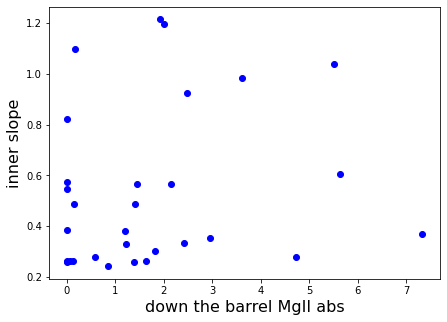

In [234]:
plt.figure(figsize = (7,5))
plt.scatter(inner_slope["MGII2796_ABS_EQW"], inner_slope["gamma"], \
            c = "blue", zorder = 2)
plt.xlabel("down the barrel MgII abs", size = 16)
plt.ylabel("inner slope", size = 16)

Text(0, 0.5, 'inner slope')

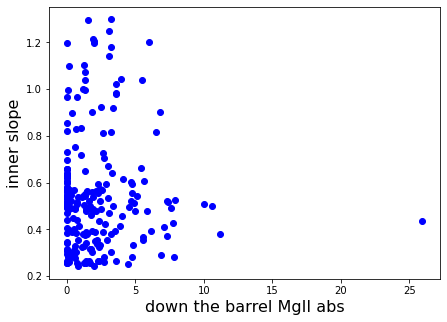

In [235]:
plt.figure(figsize = (7,5))
plt.scatter(R_04_15_zconf1["MGII2796_ABS_EQW"], R_04_15_zconf1["gamma"], \
            c = "blue", zorder = 2)
plt.xlabel("down the barrel MgII abs", size = 16)
plt.ylabel("inner slope", size = 16)

In [ ]:
inner_slope["MGII2796_ABS_EQW"]

In [ ]:
z1 = 9500/2796 - 1
z2 = 9500/2803 - 1
z3 = 3200/2796 - 1
z4 = 3200/2803 - 1

print(z1, z2, z3, z4)

In [ ]:
cosmo.lookback_time(z1), cosmo.lookback_time(z4)

In [ ]:
T_mgii = 2*(7.6*(u.eV)).to(u.J)/3/const.k_B
T_mgii

In [ ]:
T_mgii2 = 2*(15.3*(u.eV)).to(u.J)/3/const.k_B
T_mgii2

In [ ]:
T_hi = 2*(13.6*(u.eV)).to(u.J)/3/const.k_B
T_hi

In [ ]:
const.k_B

In [ ]:
2*(15.3*(u.eV)).to(u.Joule)

In [ ]:
(1*u.eV).to(u.Joule)

In [ ]:
isol_9["MGII2796_EMI_FLUX"]

In [ ]:
plt.scatter(isol_9["B_KPC"], isol_9["REW_2796"], c = isol_9["MGII2796_ABS_EQW"]+isol_9["MGII2803_ABS_EQW"],\
           vmin = 0, vmax = 5)

In [ ]:
np.max(isol_9["MGII2796_ABS_EQW"])

In [ ]:
plt.scatter(isol["B_KPC"], isol["REW_2796"], c = isol["MGII2796_ABS_EQW"]+isol["MGII2803_ABS_EQW"],\
           vmin = 0, vmax = 5)

In [ ]:
plt.scatter(isol_9["B_KPC"], isol_9["REW_2796"], \
            c = np.log10(isol_9["MGII2796_EMI_FLUX"]+isol_9["MGII2803_EMI_FLUX"]),\
           vmin = 0, vmax = 2.5)

In [ ]:
plt.scatter(R["B_KPC"], R["REW_2796"], \
            c = np.log10(R["MGII2796_EMI_FLUX"]+R["MGII2803_EMI_FLUX"]),\
           vmin = 0, vmax = 2.5)

In [ ]:
plt.scatter(R["B_KPC"], R["REW_2796"], \
            c = R["MGII2796_ABS_EQW"],\
           vmin = 0, vmax = 10)

In [ ]:
plt.scatter(R["sed_logMass"], R["Z"], \
            c = np.log10(R["MGII2796_EMI_FLUX"]+R["MGII2803_EMI_FLUX"]),\
           vmin = 0, vmax = 2.5)

In [ ]:
plt.scatter(R["Z"], R["sed_logMass"])
plt.scatter(R["Z"], R["sed_logMass"], c = np.log10(R["MGII2796_EMI_FLUX"]+R["MGII2803_EMI_FLUX"]),\
           vmin = 0, vmax = 2.5)
plt.xlim((0,1.5))

In [ ]:
plt.figure(figsize = (15,4))
plt.scatter(R["Z"], R["sed_logMass"], c = np.log10(R["MGII2796_EMI_FLUX"]+R["MGII2803_EMI_FLUX"]),\
           vmin = 0, vmax = 2.5)

In [ ]:
plt.hist(np.log10(R["MGII2796_EMI_FLUX"]+R["MGII2803_EMI_FLUX"]), range = (-10,10))

In [ ]:
plt.figure(figsize = (8,5))
plt.scatter(np.log10(R["MGII2796_EMI_FLUX"]+R["MGII2803_EMI_FLUX"]),\
            np.log10(R["OII3726_FLUX"]+R["OII3729_FLUX"]), c  = "lightgray")
plt.scatter(np.log10(R["MGII2796_EMI_FLUX"]+R["MGII2803_EMI_FLUX"]),\
            np.log10(R["OII3726_FLUX"]+R["OII3729_FLUX"]), \
           c = R["gamma"], zorder = 3, vmin = 0, vmax = 1, cmap = "inferno")
plt.ylim((1,5))
plt.xlim((0,4))

In [ ]:
plt.figure(figsize = (8,5))
plt.scatter(np.log10(R["MGII2796_EMI_FLUX"]+R["MGII2803_EMI_FLUX"]),\
            R["MGII2796_ABS_EQW"], c  = "lightgray")
plt.ylim((0,15))
plt.xlim((-2,5))

In [ ]:
plt.scatter(np.log10(R["MGII2796_EMI_FLUX"]+R["MGII2803_EMI_FLUX"]),\
            R["gamma"])
plt.xlim((0,4))

In [ ]:
plt.scatter(R["logSFR"], R["gamma"], c = R["snr_from_src"], vmin = 1, vmax = 10)
plt.xlim((-2,3))
plt.xlabel("logSFR")
plt.ylabel("gamma")

In [ ]:
plt.hist(R["log_X"], range = (-3, -1))

# Test decomposition DM, gas, stars

I would like to see if we can avoid to assume a shape for the DM. but instead just look at the residual profile once we remove gas and stars and adrift components. The problem is that gas is degenerated with DM I believe. I test that here:

from Freundlich for nfw: 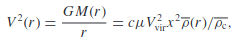

From Salucci 1997 for exponential thin disk: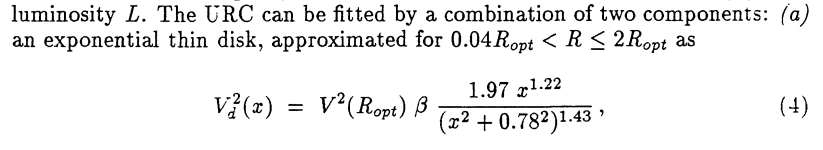

In [ ]:
def nfw(r, rs, rhos):
    x = r/rs
    return rhos/(x*(1+x)**2)

def v_nfw(r, rvir, rs, v200):
    c = rs/rvir
    x = r/rs
    num = np.log(1+c*x) -c*x/(1+c*x)
    denum = np.log(1+c) - c/(1+c)
    return v200*(num/denum/x)**0.5

def v_gas(r, K):
    return (K*r)**0.5

def v_disk(r, Ropt, beta):
    x = r/Ropt
    return (beta*x**1.22/((x**2 + 0.78**2)**1.43))**0.5

In [ ]:
rr = np.linspace(1,100,100)
dm = nfw(rr, 10, 1)
vdm = v_nfw(rr, 200, 15, 100)
vgas = v_gas(rr, 40)
vdisk = v_disk(rr, 10, 1e4)
vobs = (vdm**2 + vgas**2 + vdisk**2)**0.5

In [ ]:
plt.plot(rr, dm)
plt.yscale("log")
plt.xscale("log")

In [ ]:
plt.plot(rr, vdm, c = "black")
plt.plot(rr, vdisk, c = "blue")
plt.plot(rr, vgas, c = "green")
plt.plot(rr, vobs, c = "red")
#adrift
#disk = from MGE ou freeman
plt.xlim((0,100))

Proprement:
pour un disk exponentiel de freeman:
\begin{equation}
    \Sigma(r) = A \times exp(-kr)
\end{equation}
On considère que la distribution de masse suit la distribution de luminosité. Donc la masse enclose dans une sphère de rayon R est: 
\begin{equation}
    M(<R) = \int_0^R 2\pi r \Sigma(r) dr \\
    M(<R) = A 2\pi \int_0^R r e^{-kr} dr 
\end{equation}
